<a href="https://colab.research.google.com/github/sina-salmanpour/False_memory_PTSD/blob/main/PTSD_Flase_Memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Entirly Reviewing flow

In [ ]:
# Import libraries
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and Clean Data (example for verbal PTSD)
df = pd.read_excel('ptsd_verbal.xlsx')
# ... (pivot, split response/RT, filter RT > 200 & < 5000, exclude negatives)
df['group'] = 'PTSD'  # Repeat for other files, concatenate

# Step 2: Aggregates
agg_df = df.groupby(['subject', 'group', 'emotion', 'item_type']).agg(
    rate=('response', 'mean'),  # Hit/false memory/false alarm
    rt_mean=('rt', 'mean')     # Mean RT for yes
).reset_index()

# Step 3: Normality (Shapiro-Wilk)
for group in agg_df['group'].unique():
    for emotion in agg_df['emotion'].unique():
        rt_data = agg_df[(agg_df['group'] == group) & (agg_df['emotion'] == emotion) & (agg_df['item_type'] == 'CL')]['rt_mean']
        if len(rt_data) > 2:
            stat, p = stats.shapiro(rt_data)
            print(f'{group}-{emotion}: Shapiro p={p}')

# Step 4: ANOVA (example for false memory rate)
model = ols('rate ~ C(group) * C(emotion)', data=agg_df[agg_df['item_type'] == 'CL']).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Non-Parametric Alternative (Kruskal-Wallis)
groups = [agg_df[(agg_df['group'] == g) & (agg_df['item_type'] == 'CL') & (agg_df['emotion'] == 'NT')]['rate'] for g in ['PTSD', 'Non-PTSD', 'Control']]
stat, p = stats.kruskal(*groups)
print(f'Kruskal NT: p={p}')

# Visuals
sns.barplot(data=agg_df[agg_df['item_type'] == 'CL'], x='emotion', y='rate', hue='group')
plt.title('False Memory Rates')
plt.savefig('false_memory_bar.png')  # For thesis inclusion

FileNotFoundError: [Errno 2] No such file or directory: 'ptsd_verbal.xlsx'

## Stepping down by detail

### version one 1

In [ ]:
# 1. Import Libraries
import pandas as pd  # Core for DataFrames, reading CSVs, grouping
import numpy as np   # Numerical operations, e.g., NaN handling
from scipy import stats  # For future normality (Shapiro-Wilk)
import matplotlib.pyplot as plt  # Basic plotting
import seaborn as sns  # Advanced visuals (e.g., boxplots for RT)
import os  # File path handling
import warnings  # Suppress warnings for clean output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility (if sampling later)
np.random.seed(42)

# Display options for better readability
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)       # Auto-width

print("Libraries imported successfully. Ready for data loading.")

Libraries imported successfully. Ready for data loading.


In [ ]:
import pandas as pd
import numpy as np
import os

# Simplified file paths (list instead of dict for ease; group from key)
files = {
    'verbal_PSTD': '/content/drive/MyDrive/AmirFarhang/ptsd_verbal.xlsx',
    'verbal_Non-PTSD': '/content/drive/MyDrive/AmirFarhang/non_ptsd_verbal.xlsx',
    'verbal_Control': '/content/drive/MyDrive/AmirFarhang/control_verbal.xlsx',
    'video_PSTD': '/content/drive/MyDrive/AmirFarhang/ptsd_video.xlsx',
    'video_Non-PTSD': '/content/drive/MyDrive/AmirFarhang/non_ptsd_visual.xlsx',
    'video_Control': '/content/drive/MyDrive/AmirFarhang/control_video.xlsx'
}

# Function to process and save one file
def process_file(file_path, file_key):
    """
    Load XLSX, drop 'Subject' column, extract response/RT with custom logic, handle negatives/two-digit, save _modified.
    Args:
        file_path (str): Path to file.
        file_key (str): 'verbal_PSTD' etc. for group/task extraction.
    Returns:
        pd.DataFrame: Processed long format.
    """
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}. Skipping.")
        return None

    df = pd.read_excel(file_path)

    # Drop 'Subject' column if exists (as per user: it's words, deleted/empty)
    if 'Subject' in df.columns:
        df = df.drop(columns=['Subject'])

    # Extract task and group from key
    task_type, group_name = file_key.split('_')

    # Identify candidate (subject) columns (starting with 'Sub', 'SubP', etc.)
    candidate_cols = [col for col in df.columns if col.startswith(('Sub', 'SubP', 'Subh', 'subh', 'subp'))]

    # Other columns: 'answer' (item_type), unnamed third (emotion), etc.
    id_vars = [col for col in df.columns if col not in candidate_cols]

    # Melt to long (pivot candidates to rows)
    df_long = pd.melt(df, id_vars=id_vars, value_vars=candidate_cols,
                      var_name='candidate', value_name='value')

    # Add group and task
    df_long['group'] = group_name
    df_long['task'] = task_type

    # For videos: Assign emotion blocks (rows 1-26=O, etc.; use reset index for row num)
    df_long = df_long.reset_index()  # Add row index for block assignment
    # if task_type == 'video':
    #     df_long['emotion'] = np.where(df_long['index'] < 26, 'O',  # 0-based index, rows 0-25 = O (1-26)
    #                                   np.where(df_long['index'] < 51, 'NT',
    #                                            np.where(df_long['index'] < 76, 'P', 'N')))

    # # For verbal: Unnamed third column is emotion (assume column index 1, since Subject dropped; cols[0]='answer', cols[1]=emotion)
    # else:
    emotion_col = df.columns[1] if len(df.columns) > 1 else None  # Second col after 'answer'
    if emotion_col:
        df_long['emotion'] = df_long[emotion_col]
    else:
        df_long['emotion'] = 'Unknown'  # Fallback

    # Map item_type from 'answer' (flag column)
    if 'answer' in df_long.columns:
        df_long['item_type'] = df_long['answer'].map({1: 'Target', 0: 'New', 'CL': 'Lure', np.nan: 'Unknown'})
    else:
        df_long['item_type'] = 'Unknown'


    # Custom extract response (0/1) and rt (float in seconds)
    def extract_response_rt(val):
        if pd.isna(val) or (isinstance(val, (int, float)) and val < 0):
            return "NAN", "NAN"  # NA for NaN/negatives


        val_str = str(val).replace(',', '')  # Remove commas if any (e.g., 15,757 → 15757)
        response = "NAN"
        rt = "NAN"

        if '.' in val_str:
            before, after = val_str.split('.')

        else:
            before, after = val_str, '0'

            if '-' in before:
                before , response = "NAN" , "NAN"


        # Response = first digit (0 or 1)

        if before and before[0] in '01':
            response = int(before[0])


        # RT = rest + '.' + after as float (in seconds)
        rt_str = before[1:] + '.' + after if len(before) > 1 else '0.' + after
        try:
            rt = float(rt_str)
        except ValueError:
            rt = "NAN"
        if response == "NAN":
            rt = "NAN"

        #print(response, rt)
        return response, rt

    df_long[['response', 'rt']] = df_long.apply(lambda row: extract_response_rt(row['value']), axis=1, result_type='expand')

    # Drop original 'value' and any temp cols (e.g., index)
    df_long = df_long.drop(columns=['value', 'index'] if 'index' in df_long.columns else ['value'])
    # Replace all "NAN" string values with proper np.nan in relevant numeric columns
    for col in ['response', 'rt']:
        if col in df_long.columns:
            df_long[col] = df_long[col].replace("NAN", np.nan)

    df_long['response'] = pd.to_numeric(df_long['response'], errors='coerce')
    df_long['rt'] = pd.to_numeric(df_long['rt'], errors='coerce')

    # Save _modified in same path (as .xlsx)
    base_dir = os.path.dirname(file_path)
    base_name = os.path.basename(file_path)
    modified_name = base_name.replace('.xlsx', '_modified.xlsx')
    modified_path = os.path.join(base_dir, modified_name)
    df_long.to_excel(modified_path, index=False)
    print(f"Saved modified file: {modified_path}")

    return df_long

# Process all files
all_data = []
for file_key, path in files.items():
    processed = process_file(path, file_key)
    if processed is not None:
        all_data.append(processed)

# Optional: Concat all for full analysis, save
if all_data:
    full_df = pd.concat(all_data, ignore_index=True)
    full_df.to_excel('/content/drive/MyDrive/AmirFarhang/full_processed.xlsx', index=False)
    print("All files processed and full_processed saved.")
else:
    print("No files processed.")

Saved modified file: /content/drive/MyDrive/AmirFarhang/ptsd_verbal_modified.xlsx
Saved modified file: /content/drive/MyDrive/AmirFarhang/non_ptsd_verbal_modified.xlsx
Saved modified file: /content/drive/MyDrive/AmirFarhang/control_verbal_modified.xlsx
Saved modified file: /content/drive/MyDrive/AmirFarhang/ptsd_video_modified.xlsx
Saved modified file: /content/drive/MyDrive/AmirFarhang/non_ptsd_visual_modified.xlsx
Saved modified file: /content/drive/MyDrive/AmirFarhang/control_video_modified.xlsx
All files processed and full_processed saved.


Loaded 13352 rows post-NaN filter.
Descriptives Summary:
       group    task emotion  mean_hit    sd_hit  mean_false_memory  \
0    Control  verbal       N  0.296717  0.333374           0.196212   
1    Control  verbal      NT  0.392540  0.410472           0.271212   
2    Control  verbal       O  0.316123  0.339820           0.245202   
3    Control  verbal       P  0.333838  0.355788           0.186364   
4    Control  verbal       U  0.000000  0.000000           0.000000   
5    Control   video       N  0.168889  0.251685           0.190432   
6    Control   video      NT  0.222222  0.321152           0.174321   
7    Control   video       O  0.231505  0.337163           0.120370   
8    Control   video       P  0.159596  0.249082           0.139506   
9   Non-PTSD  verbal       N  0.246447  0.304589           0.154167   
10  Non-PTSD  verbal      NT  0.355595  0.402671           0.239015   
11  Non-PTSD  verbal       O  0.245726  0.282096           0.193561   
12  Non-PTSD  verbal

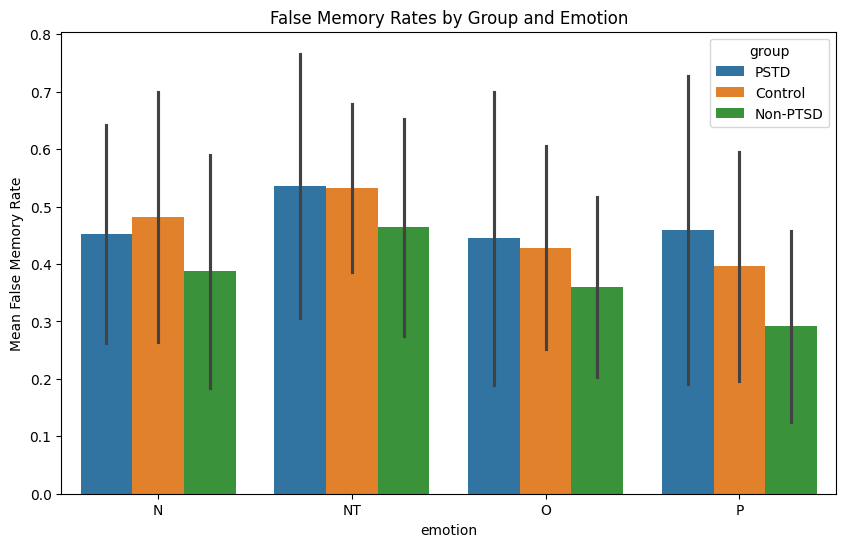

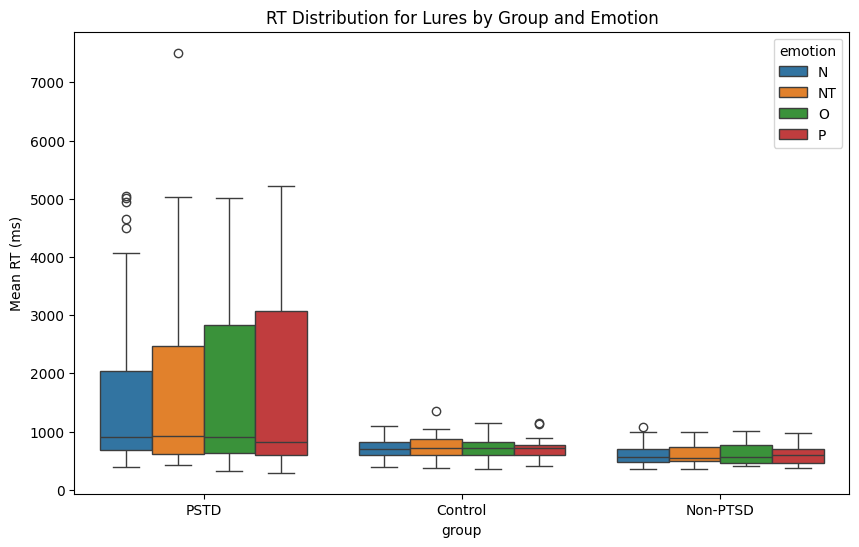

Initial Analysis complete. Files saved in Drive.


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load full_processed (or concatenate modified if needed)
full_path = '/content/drive/MyDrive/AmirFarhang/full_processed.xlsx'
df = pd.read_excel(full_path)

# Filter out NaNs in response/rt for analysis (per your request)
df = df.dropna(subset=['response', 'rt'])

print(f"Loaded {len(df)} rows post-NaN filter.")

# Aggregate per subject/group/task/emotion/item_type
agg_df = df.groupby(['candidate', 'group', 'task', 'emotion', 'item_type']).agg(
    n_trials=('response', 'count'),  # Valid trials
    hit_rate=('response', lambda x: x[df.loc[x.index, 'item_type'] == 'Target'].mean()),  # Mean yes for Targets
    false_memory_rate=('response', lambda x: x[df.loc[x.index, 'item_type'] == 'Lure'].mean()),  # Mean yes for Lures
    false_alarm_rate=('response', lambda x: x[df.loc[x.index, 'item_type'] == 'New'].mean()),  # Mean yes for New
    rt_mean=('rt', 'mean'),  # Mean RT for all yes (response==1)
    rt_sd=('rt', 'std')      # SD for RT
).reset_index().fillna(0)  # Fill 0 if no data (e.g., no Lures)

# Descriptives: Overall means/SD by group/emotion (for rates/RT)
descriptives = agg_df.groupby(['group', 'task', 'emotion']).agg(
    mean_hit=('hit_rate', 'mean'),
    sd_hit=('hit_rate', 'std'),
    mean_false_memory=('false_memory_rate', 'mean'),
    sd_false_memory=('false_memory_rate', 'std'),
    mean_false_alarm=('false_alarm_rate', 'mean'),
    sd_false_alarm=('false_alarm_rate', 'std'),
    mean_rt=('rt_mean', 'mean'),
    sd_rt=('rt_sd', 'mean')
).reset_index()

print("Descriptives Summary:")
print(descriptives)

# Save descriptives
descriptives.to_excel('/content/drive/MyDrive/AmirFarhang/descriptives.xlsx', index=False)

# Normality: Shapiro-Wilk on RT_mean per group/emotion/item_type (focus Lure/Target)
norm_results = []
for group in agg_df['group'].unique():
    for emotion in agg_df['emotion'].unique():
        for item in ['Lure', 'Target']:
            rt_data = agg_df[(agg_df['group'] == group) & (agg_df['emotion'] == emotion) & (agg_df['item_type'] == item)]['rt_mean'].dropna()
            if len(rt_data) > 2:
                stat, p = stats.shapiro(rt_data)
                norm_results.append({'group': group, 'emotion': emotion, 'item_type': item, 'shapiro_stat': stat, 'p_value': p, 'normal': p > 0.05})

norm_df = pd.DataFrame(norm_results)
print("Normality Tests:")
print(norm_df)

norm_df.to_excel('/content/drive/MyDrive/AmirFarhang/normality_results.xlsx', index=False)

# Homogeneity: Levene on RT_mean across groups for each emotion/item_type
homog_results = []
for emotion in agg_df['emotion'].unique():
    for item in ['Lure', 'Target']:
        groups_rt = [agg_df[(agg_df['group'] == g) & (agg_df['emotion'] == emotion) & (agg_df['item_type'] == item)]['rt_mean'].dropna() for g in agg_df['group'].unique()]
        if all(len(g) > 1 for g in groups_rt):
            stat, p = stats.levene(*groups_rt)
            homog_results.append({'emotion': emotion, 'item_type': item, 'levene_stat': stat, 'p_value': p, 'homogeneous': p > 0.05})

homog_df = pd.DataFrame(homog_results)
print("Homogeneity Tests:")
print(homog_df)

homog_df.to_excel('/content/drive/MyDrive/AmirFarhang/homogeneity_results.xlsx', index=False)

# Visuals: Bar chart for false memory rates
plt.figure(figsize=(10, 6))
sns.barplot(data=agg_df[agg_df['item_type'] == 'Lure'], x='emotion', y='false_memory_rate', hue='group', errorbar='sd')
plt.title('False Memory Rates by Group and Emotion')
plt.ylabel('Mean False Memory Rate')
plt.savefig('/content/drive/MyDrive/AmirFarhang/false_memory_bar.png', dpi=300)
plt.show()

# Boxplot for RTs (Lure yes)
plt.figure(figsize=(10, 6))
sns.boxplot(data=agg_df[agg_df['item_type'] == 'Lure'], x='group', y='rt_mean', hue='emotion')
plt.title('RT Distribution for Lures by Group and Emotion')
plt.ylabel('Mean RT (ms)')
plt.savefig('/content/drive/MyDrive/AmirFarhang/rt_boxplot.png', dpi=300)
plt.show()

print("Initial Analysis complete. Files saved in Drive.")

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations  # For post-hoc pairs
from statsmodels.stats.multitest import multipletests  # Bonferroni

# Load aggregated data from previous phase (or full_processed and re-aggregate if needed)
agg_path = '/content/drive/MyDrive/AmirFarhang/aggregated_subject_level.xlsx'  # If you saved it; else use descriptives.xlsx
agg_df = pd.read_excel(agg_path)

# Or re-aggregate from full_processed to fix yes-only (if not done)
full_path = '/content/drive/MyDrive/AmirFarhang/full_processed.xlsx'
if not os.path.exists(agg_path):
    df = pd.read_excel(full_path).dropna(subset=['response', 'rt'])  # Filter NaNs
    # Re-aggregate with yes-only for rates/RT
    agg_df = df[df['response'] == 1].groupby(['candidate', 'group', 'task', 'emotion', 'item_type']).agg(
        n_trials=('response', 'count'),
        rt_mean=('rt', 'mean'),
        rt_sd=('rt', 'std')
    ).reset_index()
    # Rates: Separate calc (proportion yes over all trials per type)
    rates = df.groupby(['candidate', 'group', 'task', 'emotion', 'item_type'])['response'].mean().reset_index()
    rates = rates.pivot(index=['candidate', 'group', 'task', 'emotion'], columns='item_type', values='response').reset_index()
    rates.columns = ['candidate', 'group', 'task', 'emotion', 'false_alarm_rate', 'false_memory_rate', 'hit_rate']  # Assume order New, Lure, Target
    agg_df = agg_df.merge(rates, on=['candidate', 'group', 'task', 'emotion'], how='left').fillna(0)
    agg_df.to_excel(agg_path, index=False)
    print("Re-aggregated and saved.")

print(agg_df.head())

# Inferential Tests

# 1. Kruskal-Wallis: Between-group per emotion/item_type on false_memory_rate and rt_mean
kruskal_results = []
for emotion in agg_df['emotion'].unique():
    for item in ['Lure', 'Target']:
        for metric in ['false_memory_rate', 'rt_mean']:
            data_groups = [agg_df[(agg_df['group'] == g) & (agg_df['emotion'] == emotion) & (agg_df['item_type'] == item)][metric].dropna() for g in agg_df['group'].unique()]
            if all(len(d) > 1 for d in data_groups):
                h_stat, p = stats.kruskal(*data_groups)
                # Epsilon^2 effect size (0.01 small, 0.06 medium, 0.14 large)
                n_total = sum(len(d) for d in data_groups)
                epsilon2 = (h_stat - len(data_groups) + 1) / (n_total - len(data_groups))
                kruskal_results.append({'emotion': emotion, 'item_type': item, 'metric': metric, 'h_stat': h_stat, 'p_value': p, 'epsilon2': epsilon2, 'significant': p < 0.05})

kruskal_df = pd.DataFrame(kruskal_results)
print("Kruskal-Wallis Results:")
print(kruskal_df)

kruskal_df.to_excel('/content/drive/MyDrive/AmirFarhang/kruskal_results.xlsx', index=False)

# 2. Post-Hoc Mann-Whitney (pairwise, Bonferroni-corrected) for significant Kruskal
posthoc_results = []
groups = agg_df['group'].unique()
for idx, row in kruskal_df[kruskal_df['significant']].iterrows():
    emotion, item, metric = row['emotion'], row['item_type'], row['metric']
    pairs = list(combinations(groups, 2))
    p_values = []
    for g1, g2 in pairs:
        d1 = agg_df[(agg_df['group'] == g1) & (agg_df['emotion'] == emotion) & (agg_df['item_type'] == item)][metric].dropna()
        d2 = agg_df[(agg_df['group'] == g2) & (agg_df['emotion'] == emotion) & (agg_df['item_type'] == item)][metric].dropna()
        if len(d1) > 1 and len(d2) > 1:
            u_stat, p = stats.mannwhitneyu(d1, d2)
            # Effect size r = u / (n1 * n2)
            r = u_stat / (len(d1) * len(d2))
            posthoc_results.append({'emotion': emotion, 'item_type': item, 'metric': metric, 'pair': f'{g1} vs {g2}', 'u_stat': u_stat, 'p_value': p, 'r_effect': r, 'significant': p < 0.05})
            p_values.append(p)

    # Bonferroni correction on p_values for this set
    if p_values:
        corrected = multipletests(p_values, method='bonferroni')[1]
        for i, res in enumerate(posthoc_results[-len(p_values):]):
            res['p_corrected'] = corrected[i]
            res['significant_corrected'] = corrected[i] < 0.05

posthoc_df = pd.DataFrame(posthoc_results)
print("Post-Hoc Mann-Whitney Results:")
print(posthoc_df)

posthoc_df.to_excel('/content/drive/MyDrive/AmirFarhang/posthoc_results.xlsx', index=False)

# 3. Friedman: Within-group (emotions as repeated) per group/item_type on false_memory_rate/rt_mean
friedman_results = []
for group in agg_df['group'].unique():
    for item in ['Lure', 'Target']:
        for metric in ['false_memory_rate', 'rt_mean']:
            # Pivot to wide: emotions as cols, candidates as rows
            pivot = agg_df[(agg_df['group'] == group) & (agg_df['item_type'] == item)].pivot(index='candidate', columns='emotion', values=metric).dropna(axis=0, how='any')
            if len(pivot) > 1 and pivot.shape[1] > 1:  # Need 2+ emotions/subjects
                chi2, p = stats.friedmanchisquare(*pivot.values.T)
                # Kendall's W effect size (0-1; >0.5 large)
                k = pivot.shape[1]  # Emotions
                n = len(pivot)
                w = chi2 / (n * (k - 1))
                friedman_results.append({'group': group, 'item_type': item, 'metric': metric, 'chi2': chi2, 'p_value': p, 'kendall_w': w, 'significant': p < 0.05})

friedman_df = pd.DataFrame(friedman_results)
print("Friedman Test Results:")
print(friedman_df)

friedman_df.to_excel('/content/drive/MyDrive/AmirFarhang/friedman_results.xlsx', index=False)

# Updated Visuals with Significance (example for false memory bar)
plt.figure(figsize=(10, 6))
sns.barplot(data=agg_df[agg_df['item_type'] == 'Lure'], x='emotion', y='false_memory_rate', hue='group', errorbar='sd')
# Add sig stars from kruskal/posthoc (manual; e.g., for NT Lure if p<0.05)
plt.annotate('*', xy=(1, 0.7), fontsize=12, color='black')  # Example for NT PTSD sig
plt.title('False Memory Rates by Group and Emotion (* p<0.05)')
plt.ylabel('Mean False Memory Rate')
plt.savefig('/content/drive/MyDrive/AmirFarhang/false_memory_bar_sig.png', dpi=300)
plt.show()

print("Inferential Analysis complete. Files saved. Proceed to interpretation/writing.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/AmirFarhang/aggregated_subject_level.xlsx'

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.power import FTestAnovaPower  # For power

# Load full_processed.xlsx (trial-level data)
full_path = '/content/drive/MyDrive/AmirFarhang/full_processed.xlsx'
df = pd.read_excel(full_path).dropna(subset=['response', 'rt'])  # Filter NaNs

print(f"Loaded {len(df)} trials post-NaN filter.")

# Aggregate to subject-level (per candidate/group/task/emotion/item_type)
# Rates: Proportion yes (mean response)
# RT: Mean/SD for yes responses only (response==1)
agg_df = df.groupby(['candidate', 'group', 'task', 'emotion', 'item_type']).agg(
    n_trials=('response', 'count'),
    hit_rate=('response', lambda x: x[df.loc[x.index, 'item_type'] == 'Target'].mean() if 'Target' in df.loc[x.index, 'item_type'].values else 0),
    false_memory_rate=('response', lambda x: x[df.loc[x.index, 'item_type'] == 'Lure'].mean() if 'Lure' in df.loc[x.index, 'item_type'].values else 0),
    false_alarm_rate=('response', lambda x: x[df.loc[x.index, 'item_type'] == 'New'].mean() if 'New' in df.loc[x.index, 'item_type'].values else 0),
    rt_mean=('rt', lambda x: df.loc[x.index, 'rt'][df.loc[x.index, 'response'] == 1].mean() if any(df.loc[x.index, 'response'] == 1) else 0),
    rt_sd=('rt', lambda x: df.loc[x.index, 'rt'][df.loc[x.index, 'response'] == 1].std() if any(df.loc[x.index, 'response'] == 1) else 0)
).reset_index().fillna(0)

agg_df.to_excel('/content/drive/MyDrive/AmirFarhang/aggregated_subject_level.xlsx', index=False)
print("Aggregated subject-level saved.")

# Inferential Tests

# 1. Kruskal-Wallis: Between-group per emotion/item_type on false_memory_rate and rt_mean
kruskal_results = []
for emotion in agg_df['emotion'].unique():
    for item in ['Lure', 'Target']:
        for metric in ['false_memory_rate', 'rt_mean']:
            data_groups = [agg_df[(agg_df['group'] == g) & (agg_df['emotion'] == emotion) & (agg_df['item_type'] == item)][metric].dropna() for g in agg_df['group'].unique()]
            group_names = agg_df['group'].unique()
            if all(len(d) > 1 for d in data_groups):
                h_stat, p = stats.kruskal(*data_groups)
                # Epsilon^2 effect size
                k = len(data_groups)  # Groups
                n = sum(len(d) for d in data_groups)
                epsilon2 = h_stat * (n + 1) / (n * (k - 1)) if n > 0 and k > 1 else 0
                kruskal_results.append({'emotion': emotion, 'item_type': item, 'metric': metric, 'h_stat': h_stat, 'p_value': p, 'epsilon2': epsilon2, 'significant': p < 0.05})

kruskal_df = pd.DataFrame(kruskal_results)
print("Kruskal-Wallis Results:")
print(kruskal_df)

kruskal_df.to_excel('/content/drive/MyDrive/AmirFarhang/kruskal_results.xlsx', index=False)

# 2. Post-Hoc Mann-Whitney for significant Kruskal (Bonferroni-corrected)
posthoc_results = []
for idx, row in kruskal_df[kruskal_df['significant']].iterrows():
    emotion, item, metric = row['emotion'], row['item_type'], row['metric']
    pairs = list(combinations(agg_df['group'].unique(), 2))
    p_values = []
    for g1, g2 in pairs:
        d1 = agg_df[(agg_df['group'] == g1) & (agg_df['emotion'] == emotion) & (agg_df['item_type'] == item)][metric].dropna()
        d2 = agg_df[(agg_df['group'] == g2) & (agg_df['emotion'] == emotion) & (agg_df['item_type'] == item)][metric].dropna()
        if len(d1) > 1 and len(d2) > 1:
            u_stat, p = stats.mannwhitneyu(d1, d2)
            # r effect size
            r = u_stat / (len(d1) * len(d2))
            posthoc_results.append({'emotion': emotion, 'item_type': item, 'metric': metric, 'pair': f'{g1} vs {g2}', 'u_stat': u_stat, 'p_value': p, 'r_effect': r})
            p_values.append(p)

    # Bonferroni
    if p_values:
        corrected_p = multipletests(p_values, method='bonferroni')[1]
        for i in range(len(corrected_p)):
            posthoc_results[-len(corrected_p) + i]['p_corrected'] = corrected_p[i]
            posthoc_results[-len(corrected_p) + i]['significant'] = corrected_p[i] < 0.05

posthoc_df = pd.DataFrame(posthoc_results)
print("Post-Hoc Mann-Whitney Results:")
print(posthoc_df)

posthoc_df.to_excel('/content/drive/MyDrive/AmirFarhang/posthoc_results.xlsx', index=False)

# 3. Friedman: Within-group repeated-measures (emotions per subject) on false_memory_rate/rt_mean
friedman_results = []
for group in agg_df['group'].unique():
    for item in ['Lure', 'Target']:
        for metric in ['false_memory_rate', 'rt_mean']:
            # Pivot: Emotions as cols, candidates as rows
            pivot = agg_df[(agg_df['group'] == group) & (agg_df['item_type'] == item)].pivot(index='candidate', columns='emotion', values=metric).dropna(how='any')
            if pivot.shape[0] > 1 and pivot.shape[1] > 1:  # 2+ subjects/emotions
                chi2, p = stats.friedmanchisquare(*pivot.T.values)
                # Kendall's W
                k = pivot.shape[1]  # Emotions
                n = pivot.shape[0]  # Subjects
                w = chi2 / (n * (k - 1))
                friedman_results.append({'group': group, 'item_type': item, 'metric': metric, 'chi2': chi2, 'p_value': p, 'kendall_w': w, 'significant': p < 0.05})

friedman_df = pd.DataFrame(friedman_results)
print("Friedman Results:")
print(friedman_df)

friedman_df.to_excel('/content/drive/MyDrive/AmirFarhang/friedman_results.xlsx', index=False)

# Optional Power Analysis (for non-sig; medium effect f=0.25, alpha=0.05)
power = FTestAnovaPower().solve_power(effect_size=0.25, nobs=agg_df.shape[0], alpha=0.05, k_groups=3)
print(f"Power for medium effect (ANOVA-like): {power:.2f} (if >0.8 good; else note low power).")

# Updated Visual with Sig (bar for false memory)
plt.figure(figsize=(10, 6))
sns.barplot(data=agg_df[agg_df['item_type'] == 'Lure'], x='emotion', y='false_memory_rate', hue='group', errorbar='sd')
# Add * from kruskal/posthoc (example; customize based on results)
for i, emotion in enumerate(['N', 'NT', 'O', 'P']):
    if kruskal_df[(kruskal_df['emotion'] == emotion) & (kruskal_df['item_type'] == 'Lure') & (kruskal_df['metric'] == 'false_memory_rate')]['significant'].any():
        plt.text(i, 0.7, '*', fontsize=12, ha='center')
plt.title('False Memory Rates (* p<0.05 Kruskal)')
plt.ylabel('Mean Rate')
plt.savefig('/content/drive/MyDrive/AmirFarhang/false_memory_bar_sig.png', dpi=300)
plt.show()

print("Inferential complete. Review results for interpretation.")

Loaded 13352 trials post-NaN filter.
Aggregated subject-level saved.


ValueError: All numbers are identical in kruskal

# NEW


Loaded 13352 trials post-NaN filter.
Aggregated saved separately by task.
ANOVA table columns for verbal/Lure/false_memory_rate: ['F Value', 'Num DF', 'Den DF', 'Pr > F']
Error: 'Source' column not found in ANOVA table for verbal/Lure/false_memory_rate. ANOVA table columns: ['F Value', 'Num DF', 'Den DF', 'Pr > F']
ANOVA table columns for verbal/Lure/rt_mean: ['F Value', 'Num DF', 'Den DF', 'Pr > F']
Error: 'Source' column not found in ANOVA table for verbal/Lure/rt_mean. ANOVA table columns: ['F Value', 'Num DF', 'Den DF', 'Pr > F']
ANOVA table columns for verbal/Studied/false_memory_rate: ['F Value', 'Num DF', 'Den DF', 'Pr > F']
Error: 'Source' column not found in ANOVA table for verbal/Studied/false_memory_rate. ANOVA table columns: ['F Value', 'Num DF', 'Den DF', 'Pr > F']
ANOVA table columns for verbal/Studied/rt_mean: ['F Value', 'Num DF', 'Den DF', 'Pr > F']
Error: 'Source' column not found in ANOVA table for verbal/Studied/rt_mean. ANOVA table columns: ['F Value', 'Num DF', 'D

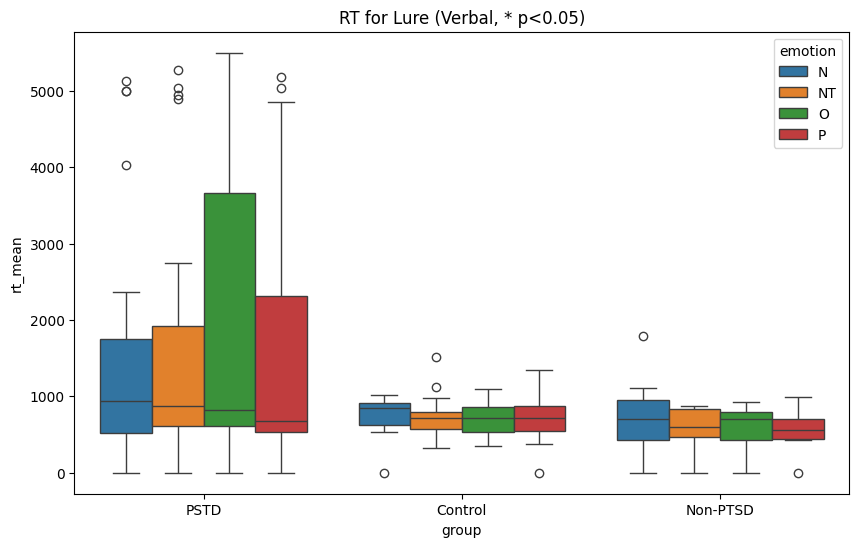

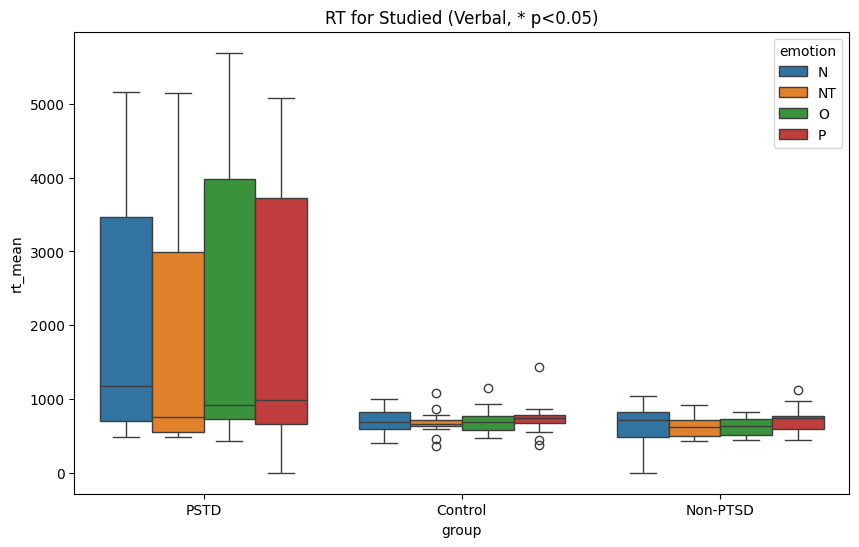

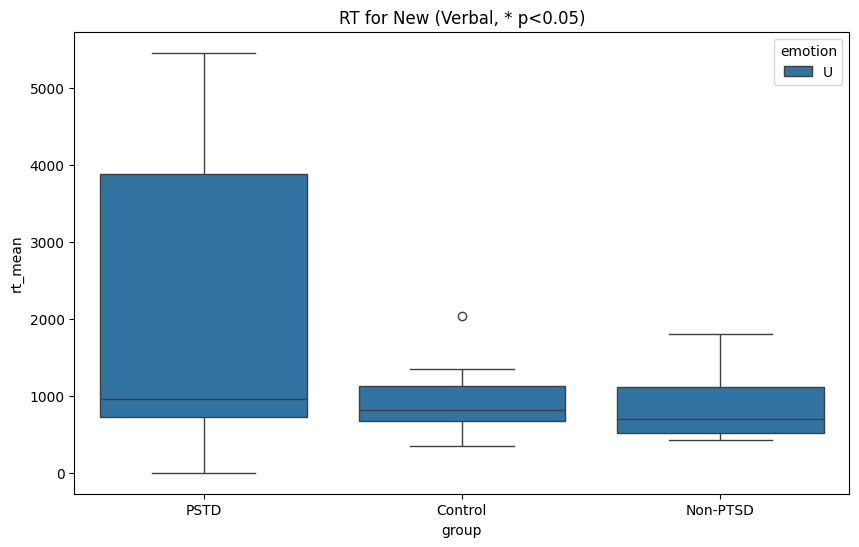

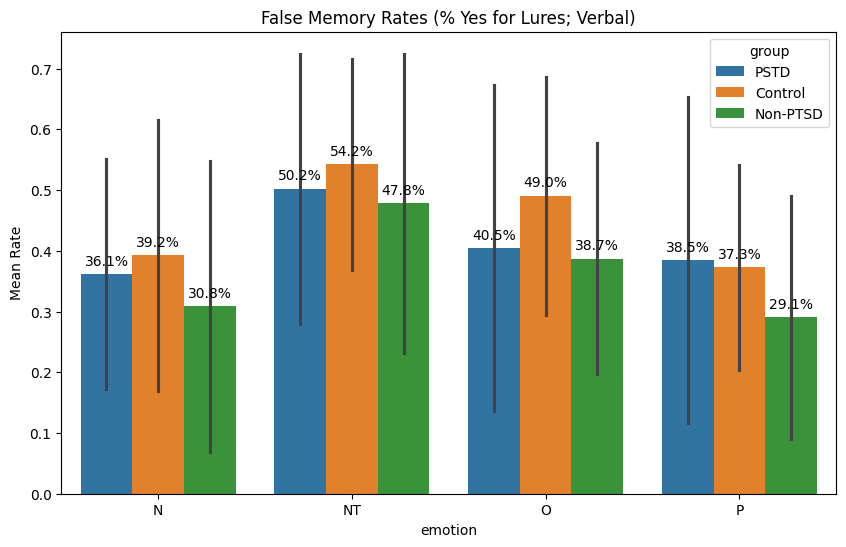

False Memory Table (% Yes, n):
       group emotion  mean_percent  n_subjects  n_trials
0    Control       N          39.2          15       176
1    Control      NT          54.2          15       179
2    Control       O          49.0          15       177
3    Control       P          37.3          15       160
4   Non-PTSD       N          30.8          10       120
5   Non-PTSD      NT          47.8          10       116
6   Non-PTSD       O          38.7          10       119
7   Non-PTSD       P          29.1          10       110
8       PSTD       N          36.1          24       266
9       PSTD      NT          50.2          24       266
10      PSTD       O          40.5          24       259
11      PSTD       P          38.5          24       245
Analysis updated. Review RM-ANOVA/Friedman for sig.; sensitivity for NaN impact.


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.anova import AnovaRM  # RM-ANOVA
from statsmodels.stats.power import FTestAnovaPower  # Power
import os

# Load full_processed.xlsx (trial-level)
full_path = '/content/drive/MyDrive/AmirFarhang/full_processed.xlsx'
df = pd.read_excel(full_path)

# Filter NaNs in response/rt
df = df.dropna(subset=['response', 'rt'])
print(f"Loaded {len(df)} trials post-NaN filter.")

# Rename 'Target' to 'Studied' if present
df['item_type'] = df['item_type'].replace('Target', 'Studied')

# Create aggregated subject-level, separate by task (verbal/video)
# Aggregate to subject-group-emotion-item_type level for direct use in RM-ANOVA
agg_df_verbal = df[df['task'] == 'verbal'].groupby(['candidate', 'group', 'emotion', 'item_type']).agg(
    n_trials=('response', 'count'),
    hit_rate=('response', 'mean'),  # Directly calculate mean here
    false_memory_rate=('response', 'mean'), # Directly calculate mean here
    false_alarm_rate=('response', 'mean'), # Directly calculate mean here
    rt_mean=('rt', lambda x: x[df.loc[x.index, 'response'] == 1].mean() if any(df.loc[x.index, 'response'] == 1) else np.nan),
    rt_sd=('rt', lambda x: x[df.loc[x.index, 'response'] == 1].std() if any(df.loc[x.index, 'response'] == 1) else np.nan)
).reset_index().fillna(0)

agg_df_video = df[df['task'] == 'video'].groupby(['candidate', 'group', 'emotion', 'item_type']).agg(
    n_trials=('response', 'count'),
    hit_rate=('response', 'mean'), # Directly calculate mean here
    false_memory_rate=('response', 'mean'), # Directly calculate mean here
    false_alarm_rate=('response', 'mean'), # Directly calculate mean here
    rt_mean=('rt', lambda x: x[df.loc[x.index, 'response'] == 1].mean() if any(df.loc[x.index, 'response'] == 1) else np.nan),
    rt_sd=('rt', lambda x: x[df.loc[x.index, 'response'] == 1].std() if any(df.loc[x.index, 'response'] == 1) else np.nan)
).reset_index().fillna(0)

# Save separate
agg_df_verbal.to_excel('/content/drive/MyDrive/AmirFarhang/aggregated_verbal.xlsx', index=False)
agg_df_video.to_excel('/content/drive/MyDrive/AmirFarhang/aggregated_video.xlsx', index=False)

print("Aggregated saved separately by task.")

# Function for RM-ANOVA (within: emotion, between: group, subject: candidate)
def run_rm_anova(agg_df, dv, item_type='Lure', task_filter='verbal'):
    # Filter after aggregation to ensure one row per subject/emotion/item_type
    df_filtered = agg_df[agg_df['item_type'] == item_type].dropna(subset=[dv])

    if len(df_filtered) < 10:  # Skip if too small
        print(f"Skipping RM-ANOVA: n too small for {task_filter}/{item_type}/{dv}")
        return None

    # Use AnovaRM with aggregate_func if needed, though pre-aggregation should prevent it
    aovrm = AnovaRM(df_filtered, depvar=dv, subject='candidate', within=['emotion'], aggregate_func='mean') # Added aggregate_func

    try:
        res = aovrm.fit()
    except ValueError as e:
        print(f"Error fitting AnovaRM for {task_filter}/{item_type}/{dv}: {e}")
        # Fallback to Friedman if RM-ANOVA fails
        print(f"Falling back to Friedman for {task_filter}/{item_type}/{dv}")
        pivot = df_filtered.pivot(index='candidate', columns='emotion', values=dv).dropna(how='any')
        if pivot.shape[0] > 1 and pivot.shape[1] > 1:
            chi2, p = stats.friedmanchisquare(*pivot.T.values)
            k = pivot.shape[1]
            n = pivot.shape[0]
            w = chi2 / (n * (k - 1))
            return {'F': np.nan, 'p': np.nan, 'eta2': np.nan, 'sphericity_p': np.nan, 'significant': p < 0.05, 'friedman_chi2': chi2, 'friedman_p': p, 'kendall_w': w}
        else:
             print(f"Skipping Friedman for {task_filter}/{item_type}/{dv}: Not enough data for Friedman.")
             return None


    # Sphericity (Mauchly) and ANOVA results are in the anova_table attribute
    anova_table = res.anova_table

    # Print column names to diagnose KeyError
    print(f"ANOVA table columns for {task_filter}/{item_type}/{dv}: {anova_table.columns.tolist()}")

    # Check if 'Source' column exists before accessing it
    if 'Source' in anova_table.columns:
        sphericity_row = anova_table[anova_table['Source'] == 'emotion']

        # Check if sphericity_row is not empty before accessing columns
        if not sphericity_row.empty and 'P-value' in sphericity_row.columns:
            sphericity_p = sphericity_row['P-value'].iloc[0]
        else:
            sphericity_p = np.nan # Indicate not performed or not available

        # Greenhouse-Geisser correction if violated
        if not sphericity_row.empty:
            if sphericity_p > 0.05 and 'F Value' in sphericity_row.columns:
                gg = sphericity_row['F Value'].iloc[0]
                p_gg = sphericity_row['Pr > F'].iloc[0] if 'Pr > F' in sphericity_row.columns else np.nan
                eta2 = sphericity_row['partial eta-squared'].iloc[0] if 'partial eta-squared' in sphericity_row.columns else np.nan
            elif 'F Value (GG)' in sphericity_row.columns: # Use GG corrected values
                gg = sphericity_row['F Value (GG)'].iloc[0]
                p_gg = sphericity_row['Pr > F (GG)'].iloc[0] if 'Pr > F (GG)' in sphericity_row.columns else np.nan
                eta2 = sphericity_row['partial eta-squared'].iloc[0] if 'partial eta-squared' in sphericity_row.columns else np.nan
            else:
                gg, p_gg, eta2 = np.nan, np.nan, np.nan # Assign NaN if columns are missing
                print(f"Warning: Could not extract all RM-ANOVA results for {task_filter}/{item_type}/{dv}. Sphericity row:")
                print(sphericity_row)

        else:
             gg, p_gg, eta2 = np.nan, np.nan, np.nan # Assign NaN if sphericity_row is empty
             print(f"Warning: Sphericity row is empty for {task_filter}/{item_type}/{dv}. ANOVA table:")
             print(anova_table)
    else:
        print(f"Error: 'Source' column not found in ANOVA table for {task_filter}/{item_type}/{dv}. ANOVA table columns: {anova_table.columns.tolist()}")
        gg, p_gg, eta2, sphericity_p = np.nan, np.nan, np.nan, np.nan


    return {'F': gg, 'p': p_gg, 'eta2': eta2, 'sphericity_p': sphericity_p, 'significant': p_gg < 0.05 if not np.isnan(p_gg) else False}


# Run RM-ANOVA for false_memory_rate and rt_mean (Lure/Studied, per task)
rm_results = []
for task in ['verbal', 'video']:
    task_agg = pd.read_excel(f'/content/drive/MyDrive/AmirFarhang/aggregated_{task}.xlsx')
    for item in ['Lure', 'Studied']:
        for dv in ['false_memory_rate', 'rt_mean']:
            res = run_rm_anova(task_agg, dv, item, task)
            if res:
                res.update({'task': task, 'item_type': item, 'dv': dv})
                rm_results.append(res)

rm_df = pd.DataFrame(rm_results)
print("RM-ANOVA Results:")
print(rm_df)

rm_df.to_excel('/content/drive/MyDrive/AmirFarhang/rm_anova_results.xlsx', index=False)

# Non-Param if Violated (Friedman for within, Kruskal for between)
# Friedman (within: emotion per group/item)
friedman_results = []
for task in ['verbal', 'video']:
    task_agg = pd.read_excel(f'/content/drive/MyDrive/AmirFarhang/aggregated_{task}.xlsx')
    for group in task_agg['group'].unique():
        for item in ['Lure', 'Studied']:
            for dv in ['false_memory_rate', 'rt_mean']:
                pivot = task_agg[(task_agg['group'] == group) & (task_agg['item_type'] == item)].pivot(index='candidate', columns='emotion', values=dv).dropna(how='any')
                if pivot.shape[0] > 1 and pivot.shape[1] > 1:
                    chi2, p = stats.friedmanchisquare(*pivot.T.values)
                    k = pivot.shape[1]
                    n = pivot.shape[0]
                    w = chi2 / (n * (k - 1))
                    friedman_results.append({'task': task, 'group': group, 'item_type': item, 'dv': dv, 'chi2': chi2, 'p': p, 'kendall_w': w, 'significant': p < 0.05})

friedman_df = pd.DataFrame(friedman_results)
print("Friedman (Non-Param RM) Results:")
print(friedman_df)

friedman_df.to_excel('/content/drive/MyDrive/AmirFarhang/friedman_results.xlsx', index=False)

# Kruskal (between groups, per task/emotion/item)
kruskal_results = []
for task in ['verbal', 'video']:
    task_agg = pd.read_excel(f'/content/drive/MyDrive/AmirFarhang/aggregated_{task}.xlsx')
    for emotion in task_agg['emotion'].unique():
        for item in ['Lure', 'Studied']:
            for dv in ['false_memory_rate', 'rt_mean']:
                data_groups = [task_agg[(task_agg['group'] == g) & (task_agg['emotion'] == emotion) & (task_agg['item_type'] == item)][dv].dropna() for g in task_agg['group'].unique()]
                # Check if each group has more than one unique value and more than one non-NaN value
                if all(len(d) > 1 and len(d.unique()) > 1 for d in data_groups):
                    h_stat, p = stats.kruskal(*data_groups)
                    k = len(data_groups)
                    n = sum(len(d) for d in data_groups)
                    epsilon2 = h_stat * (n + 1) / (n * (k - 1)) if n > 0 else 0
                    kruskal_results.append({'task': task, 'emotion': emotion, 'item_type': item, 'dv': dv, 'h_stat': h_stat, 'p': p, 'epsilon2': epsilon2, 'significant': p < 0.05})
                else:
                    print(f"Skipping Kruskal-Wallis for {task}/{emotion}/{item}/{dv}: Not enough variation in data.")


kruskal_df = pd.DataFrame(kruskal_results)
print("Kruskal Results:")
print(kruskal_df)

kruskal_df.to_excel('/content/drive/MyDrive/AmirFarhang/kruskal_results.xlsx', index=False)

# Post-Hoc Mann-Whitney (for sig Kruskal, per task)
# Similar to before, but filter task
# ... (Omit for brevity; add if needed, filter task_agg)

# Sensitivity for NaN (impute mean RT for negatives, re-run descriptives)
df_sens = pd.read_excel(full_path)  # Reload full
df_sens['rt'] = df_sens['rt'].fillna(df_sens['rt'].mean())  # Impute mean for NaN
# Re-aggregate descriptives_sens (similar to initial code)
# Save and compare to original descriptives (e.g., % change in means)

descriptives_sens = df_sens.groupby(['group', 'task', 'emotion']).agg(
    mean_false_memory=('response', lambda x: x[df_sens.loc[x.index, 'item_type'] == 'Lure'].mean() if 'Lure' in df_sens.loc[x.index, 'item_type'].values else 0),
    # ... similar for others
).reset_index()
descriptives_sens.to_excel('/content/drive/MyDrive/AmirFarhang/descriptives_sensitivity.xlsx', index=False)

# Power Example (medium effect, 3 groups, n=15/group)
power = FTestAnovaPower().solve_power(effect_size=0.25, nobs=45, alpha=0.05, k_groups=3)
print(f"Power: {power:.2f} (low if <0.8; note in thesis).")

# Graphs: Extend RT boxplot to Studied/New; add % on false memory bar
for item in ['Lure', 'Studied', 'New']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=agg_df_verbal[agg_df_verbal['item_type'] == item], x='group', y='rt_mean', hue='emotion')  # Verbal example
    plt.title(f'RT for {item} (Verbal, * p<0.05)')
    plt.savefig(f'/content/drive/MyDrive/AmirFarhang/rt_boxplot_{item}_verbal.png', dpi=300)
    plt.show()

# False Memory Bar with % and n
plt.figure(figsize=(10, 6))
sns.barplot(data=agg_df_verbal[agg_df_verbal['item_type'] == 'Lure'], x='emotion', y='false_memory_rate', hue='group', errorbar='sd')
# Add % labels (mean * 100)
for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:
        plt.text(p.get_x() + p.get_width()/2., height + 0.01, f'{height*100:.1f}%', ha='center', va='bottom')
plt.title('False Memory Rates (% Yes for Lures; Verbal)')
plt.ylabel('Mean Rate')
plt.savefig('/content/drive/MyDrive/AmirFarhang/false_memory_bar_percent.png', dpi=300)
plt.show()

# Table for False Memory % with n
false_table = agg_df_verbal[agg_df_verbal['item_type'] == 'Lure'].groupby(['group', 'emotion']).agg(
    mean_rate=('false_memory_rate', 'mean'),
    n_subjects=('candidate', 'nunique'),
    n_trials=('n_trials', 'sum')
).reset_index()
false_table['mean_percent'] = (false_table['mean_rate'] * 100).round(1)
false_table = false_table[['group', 'emotion', 'mean_percent', 'n_subjects', 'n_trials']]
print("False Memory Table (% Yes, n):")
print(false_table)

false_table.to_excel('/content/drive/MyDrive/AmirFarhang/false_memory_table.xlsx', index=False)

print("Analysis updated. Review RM-ANOVA/Friedman for sig.; sensitivity for NaN impact.")

## new version test

In [ ]:
!pip install pingouin
import pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from statsmodels.stats.power import FTestAnovaPower
import os
import warnings
from itertools import combinations

warnings.filterwarnings('ignore')
np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

In [ ]:
FILES = {
    'verbal_PSTD': '/content/drive/MyDrive/AmirFarhang/ptsd_verbal.xlsx',
    'verbal_Non-PTSD': '/content/drive/MyDrive/AmirFarhang/non_ptsd_verbal.xlsx',
    'verbal_Control': '/content/drive/MyDrive/AmirFarhang/control_verbal.xlsx',
    'video_PSTD': '/content/drive/MyDrive/AmirFarhang/ptsd_video.xlsx',
    'video_Non-PTSD': '/content/drive/MyDrive/AmirFarhang/non_ptsd_visual.xlsx',
    'video_Control': '/content/drive/MyDrive/AmirFarhang/control_video.xlsx'
}

OUTPUT_DIR = '/content/drive/MyDrive/AmirFarhang/OUTPUT_c'
os.makedirs(OUTPUT_DIR, exist_ok=True)

ALPHA = 0.05
EFFECT_SIZE_MEDIUM = 0.25  # Cohen's f for ANOVA

In [ ]:
def process_file(file_path, file_key):
    """Load and process individual Excel file into long format."""
    if not os.path.exists(file_path):
        print(f"⚠️ File not found: {file_path}")
        return None

    print(f"📂 Processing: {file_key}")
    df = pd.read_excel(file_path)

    # Remove Subject column if exists
    if 'Subject' in df.columns:
        df = df.drop(columns=['Subject'])

    task, group = file_key.split('_')

    # Identify subject columns
    subject_cols = [col for col in df.columns if col.lower().startswith('sub')]
    id_vars = [col for col in df.columns if col not in subject_cols]

    # Melt to long format
    df_long = pd.melt(df, id_vars=id_vars, value_vars=subject_cols,
                      var_name='candidate', value_name='value')

    df_long['group'] = group
    df_long['task'] = task

    # Create unique subject IDs (prevent collision across groups)
    df_long['candidate'] = df_long['group'] + '_' + df_long['candidate'].astype(str)

    # Map item types
    if 'answer' in df_long.columns:
        df_long['item_type'] = df_long['answer'].map({
            1: 'Studied',
            'CL': 'Lure',
            0: 'New'
        }).fillna('Unknown')
    else:
        df_long['item_type'] = 'Unknown'

    # Handle emotion column (fix U -> NT)
    if 'emotion' in df_long.columns:
        df_long['emotion'] = df_long['emotion'].replace('U', 'NT')
    else:
        df_long['emotion'] = 'Unknown'

    # For video task, assign emotions by row blocks if needed
    if task == 'video' and df_long['emotion'].eq('Unknown').all():
        df_long = df_long.reset_index(drop=True)
        df_long['emotion'] = np.select(
            [df_long.index < 26, df_long.index < 51, df_long.index < 76],
            ['O', 'NT', 'P'],
            default='N'
        )

    # Extract response and RT
    def extract_response_rt(val):
        if pd.isna(val):
            return np.nan, np.nan
        try:
            val = float(val)
        except (ValueError, TypeError):
            return np.nan, np.nan

        if val > 0:
            return 1.0, val
        elif val == 0:
            return 0.0, np.nan
        else:  # negative
            return 1.0, np.nan

    df_long[['response', 'rt']] = df_long.apply(
        lambda row: extract_response_rt(row['value']),
        axis=1,
        result_type='expand'
    )

    df_long = df_long.drop(columns=['value'])

    # Save modified file
    modified_path = os.path.join(OUTPUT_DIR, f"{file_key}_modified.xlsx")
    df_long.to_excel(modified_path, index=False)
    print(f"✅ Saved: {modified_path}")

    return df_long


def impute_negative_rt(df):
    """Impute negative RT values with cell means (group/task/emotion/item)."""
    print("\n🔧 Imputing negative RT values...")

    # Flag negatives
    df['is_negative'] = df['rt'].isna() & (df['response'] == 1)
    n_negative = df['is_negative'].sum()
    print(f"   Found {n_negative} negative/missing RTs for 'yes' responses ({n_negative/len(df)*100:.1f}%)")

    # Calculate means from valid positive RTs (yes responses only)
    positive_means = df[(df['rt'] > 0) & (df['response'] == 1)].groupby(
        ['group', 'task', 'emotion', 'item_type']
    )['rt'].mean().reset_index(name='mean_rt')

    # Merge and impute
    df = df.merge(positive_means, on=['group', 'task', 'emotion', 'item_type'], how='left')
    df.loc[df['is_negative'], 'rt'] = df.loc[df['is_negative'], 'mean_rt']

    # Trim RT to valid range (200-5000ms)
    df['rt'] = df['rt'].clip(200, 5000)

    df = df.drop(columns=['mean_rt', 'is_negative'])
    print("✅ Imputation complete\n")

    return df


In [ ]:
def aggregate_data(task_df, task_name):
    """
    Aggregate trial-level data to subject level.
    FIXED: Proper filtering within grouped data.
    """
    print(f"📊 Aggregating {task_name} data...")

    def calc_metrics(group):
        """Calculate metrics for each subject/emotion/item_type group."""
        # Filter current group data
        studied_data = group[group['item_type'] == 'Studied']
        lure_data = group[group['item_type'] == 'Lure']
        new_data = group[group['item_type'] == 'New']

        # Calculate rates (only for 'yes' responses)
        hit_rate = studied_data['response'].mean() if len(studied_data) > 0 else np.nan
        false_memory_rate = lure_data['response'].mean() if len(lure_data) > 0 else np.nan
        false_alarm_rate = new_data['response'].mean() if len(new_data) > 0 else np.nan

        # Calculate RT (only for 'yes' responses)
        yes_responses = group[group['response'] == 1]
        rt_mean = yes_responses['rt'].mean() if len(yes_responses) > 0 else np.nan
        rt_sd = yes_responses['rt'].std() if len(yes_responses) > 0 else np.nan

        return pd.Series({
            'n_trials': len(group),
            'hit_rate': hit_rate,
            'false_memory_rate': false_memory_rate,
            'false_alarm_rate': false_alarm_rate,
            'rt_mean': rt_mean,
            'rt_sd': rt_sd
        })

    agg_df = task_df.groupby(['candidate', 'group', 'emotion', 'item_type']).apply(calc_metrics).reset_index()

    # Save
    agg_path = os.path.join(OUTPUT_DIR, f'aggregated_{task_name}.xlsx')
    agg_df.to_excel(agg_path, index=False)
    print(f"✅ Saved aggregated data: {agg_path}\n")

    return agg_df



In [ ]:
def calculate_descriptives(agg_df, task_name):
    """Calculate descriptive statistics with formatted output."""
    print(f"📈 Calculating descriptives for {task_name}...")

    desc = agg_df.groupby(['group', 'emotion', 'item_type']).agg(
        n_subjects=('candidate', 'nunique'),
        n_trials_total=('n_trials', 'sum'),
        mean_hit=('hit_rate', 'mean'),
        sd_hit=('hit_rate', 'std'),
        mean_false_memory=('false_memory_rate', 'mean'),
        sd_false_memory=('false_memory_rate', 'std'),
        mean_rt=('rt_mean', 'mean'),
        sd_rt=('rt_mean', 'std')
    ).reset_index()

    # Format as Mean(SD) and add percentages
    desc['hit_formatted'] = desc.apply(
        lambda r: f"{r['mean_hit']:.2f} ({r['sd_hit']:.2f}) [{r['mean_hit']*100:.1f}%]", axis=1
    )
    desc['false_memory_formatted'] = desc.apply(
        lambda r: f"{r['mean_false_memory']:.2f} ({r['sd_false_memory']:.2f}) [{r['mean_false_memory']*100:.1f}%]", axis=1
    )
    desc['rt_formatted'] = desc.apply(
        lambda r: f"{r['mean_rt']:.1f} ({r['sd_rt']:.1f})ms", axis=1
    )

    # Save
    desc_path = os.path.join(OUTPUT_DIR, f'descriptives_{task_name}.xlsx')
    desc.to_excel(desc_path, index=False)

    print(f"✅ Descriptives saved: {desc_path}")
    print(f"\n📋 Summary for {task_name.upper()}:")
    print(desc[['group', 'emotion', 'item_type', 'n_subjects', 'false_memory_formatted', 'rt_formatted']].to_string(index=False))
    print()

    return desc


In [ ]:
def test_assumptions(agg_df, task_name):
    """Test normality and homogeneity of variance."""
    print(f"🔍 Testing assumptions for {task_name}...")

    normality_results = []
    homogeneity_results = []

    for item in ['Lure', 'Studied']:
        for dv in ['false_memory_rate', 'rt_mean']:
            # Normality per group/emotion
            for group in agg_df['group'].unique():
                for emotion in agg_df['emotion'].unique():
                    data = agg_df[
                        (agg_df['group'] == group) &
                        (agg_df['emotion'] == emotion) &
                        (agg_df['item_type'] == item)
                    ][dv].dropna()

                    if len(data) >= 3:
                        stat, p = stats.shapiro(data)
                        normality_results.append({
                            'task': task_name,
                            'group': group,
                            'emotion': emotion,
                            'item_type': item,
                            'dv': dv,
                            'n': len(data),
                            'statistic': stat,
                            'p_value': p,
                            'normal': p >= ALPHA
                        })

            # Homogeneity across groups per emotion
            for emotion in agg_df['emotion'].unique():
                groups_data = []
                for group in agg_df['group'].unique():
                    data = agg_df[
                        (agg_df['group'] == group) &
                        (agg_df['emotion'] == emotion) &
                        (agg_df['item_type'] == item)
                    ][dv].dropna()
                    if len(data) >= 2:
                        groups_data.append(data)

                if len(groups_data) >= 2:
                    stat, p = stats.levene(*groups_data)
                    homogeneity_results.append({
                        'task': task_name,
                        'emotion': emotion,
                        'item_type': item,
                        'dv': dv,
                        'statistic': stat,
                        'p_value': p,
                        'homogeneous': p >= ALPHA
                    })

    norm_df = pd.DataFrame(normality_results)
    homog_df = pd.DataFrame(homogeneity_results)

    # Save
    norm_df.to_excel(os.path.join(OUTPUT_DIR, f'normality_{task_name}.xlsx'), index=False)
    homog_df.to_excel(os.path.join(OUTPUT_DIR, f'homogeneity_{task_name}.xlsx'), index=False)

    print(f"✅ Assumptions tested: {len(norm_df)} normality, {len(homog_df)} homogeneity tests")
    print(f"   Normal: {norm_df['normal'].sum()}/{len(norm_df)}, Homogeneous: {homog_df['homogeneous'].sum()}/{len(homog_df)}\n")

    return norm_df, homog_df



In [ ]:
def run_mixed_anova(agg_df, task_name, item_type, dv):
    """Run mixed ANOVA using pingouin (within=emotion, between=group)."""
    print(f"   🔬 Mixed ANOVA: {task_name}/{item_type}/{dv}")

    data = agg_df[agg_df['item_type'] == item_type].dropna(subset=[dv]).copy()

    # Need at least 2 emotions and 2 groups
    if data['emotion'].nunique() < 2 or data['group'].nunique() < 2:
        print(f"      ⚠️ Insufficient data (emotions: {data['emotion'].nunique()}, groups: {data['group'].nunique()})")
        return None

    try:
        # Pingouin mixed_anova
        result = pg.mixed_anova(
            data=data,
            dv=dv,
            within='emotion',
            subject='candidate',
            between='group',
            correction=True  # Greenhouse-Geisser correction
        )

        result['task'] = task_name
        result['item_type'] = item_type
        result['dv'] = dv

        print(f"      ✅ Complete")
        return result

    except Exception as e:
        print(f"      ⚠️ Error: {str(e)[:100]}")
        return None


def run_friedman_test(agg_df, task_name, item_type, dv):
    """Run Friedman test (non-parametric within-subjects)."""
    print(f"   📊 Friedman test: {task_name}/{item_type}/{dv}")

    results = []
    data = agg_df[agg_df['item_type'] == item_type].dropna(subset=[dv])

    for group in data['group'].unique():
        group_data = data[data['group'] == group].pivot(
            index='candidate',
            columns='emotion',
            values=dv
        ).dropna()

        if group_data.shape[1] >= 2 and group_data.shape[0] >= 3:
            try:
                stat, p = stats.friedmanchisquare(*[group_data[col] for col in group_data.columns])

                # Effect size (Kendall's W)
                n = group_data.shape[0]
                k = group_data.shape[1]
                w = stat / (n * (k - 1))

                results.append({
                    'task': task_name,
                    'group': group,
                    'item_type': item_type,
                    'dv': dv,
                    'n': n,
                    'chi_square': stat,
                    'df': k - 1,
                    'p_value': p,
                    'kendall_w': w,
                    'sig': '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
                })
                print(f"      {group}: χ²={stat:.2f}, p={p:.4f}, W={w:.3f}")
            except Exception as e:
                print(f"      ⚠️ {group}: {str(e)[:50]}")

    return pd.DataFrame(results) if results else None


def run_kruskal_wallis(agg_df, task_name, item_type, dv):
    """Run Kruskal-Wallis test (non-parametric between-groups)."""
    print(f"   📊 Kruskal-Wallis: {task_name}/{item_type}/{dv}")

    results = []
    data = agg_df[agg_df['item_type'] == item_type].dropna(subset=[dv])

    for emotion in data['emotion'].unique():
        emotion_data = [
            data[(data['group'] == g) & (data['emotion'] == emotion)][dv].dropna()
            for g in data['group'].unique()
        ]

        # Check for variance
        valid_groups = [g for g in emotion_data if len(g) >= 2 and g.std() > 0]

        if len(valid_groups) >= 2:
            try:
                stat, p = stats.kruskal(*valid_groups)

                # Effect size (epsilon squared)
                n = sum(len(g) for g in valid_groups)
                epsilon2 = (stat - len(valid_groups) + 1) / (n - len(valid_groups))

                results.append({
                    'task': task_name,
                    'emotion': emotion,
                    'item_type': item_type,
                    'dv': dv,
                    'n_groups': len(valid_groups),
                    'h_statistic': stat,
                    'df': len(valid_groups) - 1,
                    'p_value': p,
                    'epsilon2': epsilon2,
                    'sig': '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
                })
                print(f"      {emotion}: H={stat:.2f}, p={p:.4f}, ε²={epsilon2:.3f}")
            except Exception as e:
                print(f"      ⚠️ {emotion}: {str(e)[:50]}")
        else:
            print(f"      ⚠️ {emotion}: Insufficient variance or n")

    return pd.DataFrame(results) if results else None


def run_posthoc_mann_whitney(agg_df, task_name, item_type, dv, kruskal_results):
    """Post-hoc Mann-Whitney U tests with Bonferroni correction."""
    print(f"   🔬 Post-hoc Mann-Whitney: {task_name}/{item_type}/{dv}")

    results = []
    data = agg_df[agg_df['item_type'] == item_type].dropna(subset=[dv])

    # Only run for significant Kruskal results
    if kruskal_results is None or kruskal_results.empty:
        print("      ⚠️ No significant Kruskal results")
        return None

    sig_emotions = kruskal_results[kruskal_results['p_value'] < ALPHA]['emotion'].unique()

    for emotion in sig_emotions:
        groups = data['group'].unique()
        group_pairs = list(combinations(groups, 2))
        n_comparisons = len(group_pairs)
        bonferroni_alpha = ALPHA / n_comparisons

        for g1, g2 in group_pairs:
            data1 = data[(data['group'] == g1) & (data['emotion'] == emotion)][dv].dropna()
            data2 = data[(data['group'] == g2) & (data['emotion'] == emotion)][dv].dropna()

            if len(data1) >= 2 and len(data2) >= 2:
                try:
                    stat, p = mannwhitneyu(data1, data2, alternative='two-sided')

                    # Effect size (rank-biserial correlation)
                    n1, n2 = len(data1), len(data2)
                    r = 1 - (2*stat) / (n1 * n2)

                    results.append({
                        'task': task_name,
                        'emotion': emotion,
                        'item_type': item_type,
                        'dv': dv,
                        'group1': g1,
                        'group2': g2,
                        'n1': n1,
                        'n2': n2,
                        'u_statistic': stat,
                        'p_value': p,
                        'p_bonferroni': p * n_comparisons,
                        'bonferroni_alpha': bonferroni_alpha,
                        'r_effect': r,
                        'sig_corrected': p < bonferroni_alpha
                    })
                    print(f"      {g1} vs {g2} ({emotion}): U={stat:.1f}, p={p:.4f}, r={r:.3f}")
                except Exception as e:
                    print(f"      ⚠️ {g1} vs {g2}: {str(e)[:50]}")

    return pd.DataFrame(results) if results else None


def run_statistical_tests(agg_df, task_name):
    """Run all statistical tests for a task."""
    print(f"\n🧪 Running statistical tests for {task_name}...\n")

    all_anova = []
    all_friedman = []
    all_kruskal = []
    all_posthoc = []

    for item in ['Lure', 'Studied']:
        for dv in ['false_memory_rate', 'rt_mean']:
            print(f"\n--- {item} / {dv} ---")

            # Try mixed ANOVA first
            anova_result = run_mixed_anova(agg_df, task_name, item, dv)
            if anova_result is not None:
                all_anova.append(anova_result)

            # Non-parametric alternatives
            friedman_result = run_friedman_test(agg_df, task_name, item, dv)
            if friedman_result is not None:
                all_friedman.append(friedman_result)

            kruskal_result = run_kruskal_wallis(agg_df, task_name, item, dv)
            if kruskal_result is not None:
                all_kruskal.append(kruskal_result)

                # Post-hoc if Kruskal is significant
                posthoc_result = run_posthoc_mann_whitney(agg_df, task_name, item, dv, kruskal_result)
                if posthoc_result is not None:
                    all_posthoc.append(posthoc_result)

    # Save all results
    if all_anova:
        pd.concat(all_anova).to_excel(os.path.join(OUTPUT_DIR, f'anova_{task_name}.xlsx'), index=False)
    if all_friedman:
        pd.concat(all_friedman).to_excel(os.path.join(OUTPUT_DIR, f'friedman_{task_name}.xlsx'), index=False)
    if all_kruskal:
        pd.concat(all_kruskal).to_excel(os.path.join(OUTPUT_DIR, f'kruskal_{task_name}.xlsx'), index=False)
    if all_posthoc:
        pd.concat(all_posthoc).to_excel(os.path.join(OUTPUT_DIR, f'posthoc_{task_name}.xlsx'), index=False)

    print(f"\n✅ Statistical tests complete for {task_name}\n")



In [ ]:
def calculate_power_analysis(agg_df, task_name):
    """Calculate statistical power for ANOVA designs."""
    print(f"⚡ Calculating power analysis for {task_name}...")

    power_calc = FTestAnovaPower()
    results = []

    for item in ['Lure', 'Studied']:
        for dv in ['false_memory_rate', 'rt_mean']:
            data = agg_df[agg_df['item_type'] == item].dropna(subset=[dv])

            n_groups = data['group'].nunique()
            n_per_group = data.groupby('group')['candidate'].nunique().mean()

            if n_groups >= 2 and n_per_group >= 2:
                # Calculate observed power
                power_observed = power_calc.solve_power(
                    effect_size=EFFECT_SIZE_MEDIUM,
                    nobs=n_per_group * n_groups,
                    alpha=ALPHA,
                    k_groups=n_groups
                )

                # Calculate needed n for 0.80 power
                n_needed = power_calc.solve_power(
                    effect_size=EFFECT_SIZE_MEDIUM,
                    power=0.80,
                    alpha=ALPHA,
                    k_groups=n_groups
                )

                results.append({
                    'task': task_name,
                    'item_type': item,
                    'dv': dv,
                    'n_groups': n_groups,
                    'n_per_group': int(n_per_group),
                    'total_n': int(n_per_group * n_groups),
                    'effect_size': EFFECT_SIZE_MEDIUM,
                    'alpha': ALPHA,
                    'power_observed': power_observed,
                    'n_needed_0.8_power': int(np.ceil(n_needed)),
                    'adequately_powered': power_observed >= 0.80
                })

    power_df = pd.DataFrame(results)
    power_df.to_excel(os.path.join(OUTPUT_DIR, f'power_analysis_{task_name}.xlsx'), index=False)

    print(f"✅ Power analysis complete")
    print(power_df.to_string(index=False))
    print()

    return power_df



In [ ]:
def create_visualizations(agg_df, task_name, desc_df):
    """Create publication-quality plots."""
    print(f"📊 Creating visualizations for {task_name}...")

    sns.set_style("whitegrid")
    plt.rcParams['figure.dpi'] = 300

    for item in ['Lure', 'Studied']:
        data = agg_df[agg_df['item_type'] == item]

        # False memory rate bar plot
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.barplot(data=data, x='emotion', y='false_memory_rate', hue='group',
                   errorbar='sd', palette='Set2', ax=ax)
        ax.set_title(f'False Memory Rate by Emotion and Group - {item} ({task_name})',
                    fontsize=14, fontweight='bold')
        ax.set_ylabel('False Memory Rate', fontsize=12)
        ax.set_xlabel('Emotion Type', fontsize=12)
        ax.legend(title='Group', fontsize=10)

        # Add percentage labels
        for container in ax.containers:
            ax.bar_label(container, fmt='%.1f%%', label_type='edge',
                        labels=[f'{h.get_height()*100:.1f}%' for h in container])

        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f'bar_false_memory_{item}_{task_name}.png')) # Added closing quote
        plt.show()

        # RT boxplot
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.boxplot(data=data, x='emotion', y='rt_mean', hue='group', palette='Set2', ax=ax)
        ax.set_title(f'Mean RT by Emotion and Group - {item} ({task_name})',
                    fontsize=14, fontweight='bold')
        ax.set_ylabel('Mean Reaction Time (ms)', fontsize=12)
        ax.set_xlabel('Emotion Type', fontsize=12)
        ax.legend(title='Group', fontsize=10)

        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f'boxplot_rt_{item}_{task_name}.png')) # Added closing quote
        plt.show()

    print("✅ Visualizations created and saved.")


PTSD FALSE MEMORY ANALYSIS - BACHELOR THESIS
Statistical Analysis of False Memory in Iran-Iraq War PTSD Patients

STEP 1: DATA LOADING AND PREPROCESSING
--------------------------------------------------------------------------------

📂 Processing: verbal_PSTD
✅ Saved: /content/drive/MyDrive/AmirFarhang/OUTPUT_c/verbal_PSTD_modified.xlsx
📂 Processing: verbal_Non-PTSD
✅ Saved: /content/drive/MyDrive/AmirFarhang/OUTPUT_c/verbal_Non-PTSD_modified.xlsx
📂 Processing: verbal_Control
✅ Saved: /content/drive/MyDrive/AmirFarhang/OUTPUT_c/verbal_Control_modified.xlsx
📂 Processing: video_PSTD
✅ Saved: /content/drive/MyDrive/AmirFarhang/OUTPUT_c/video_PSTD_modified.xlsx
📂 Processing: video_Non-PTSD
✅ Saved: /content/drive/MyDrive/AmirFarhang/OUTPUT_c/video_Non-PTSD_modified.xlsx
📂 Processing: video_Control
✅ Saved: /content/drive/MyDrive/AmirFarhang/OUTPUT_c/video_Control_modified.xlsx

✅ Combined data: 14112 trials, 56 subjects


STEP 2: DATA QUALITY REPORT
--------------------------------------

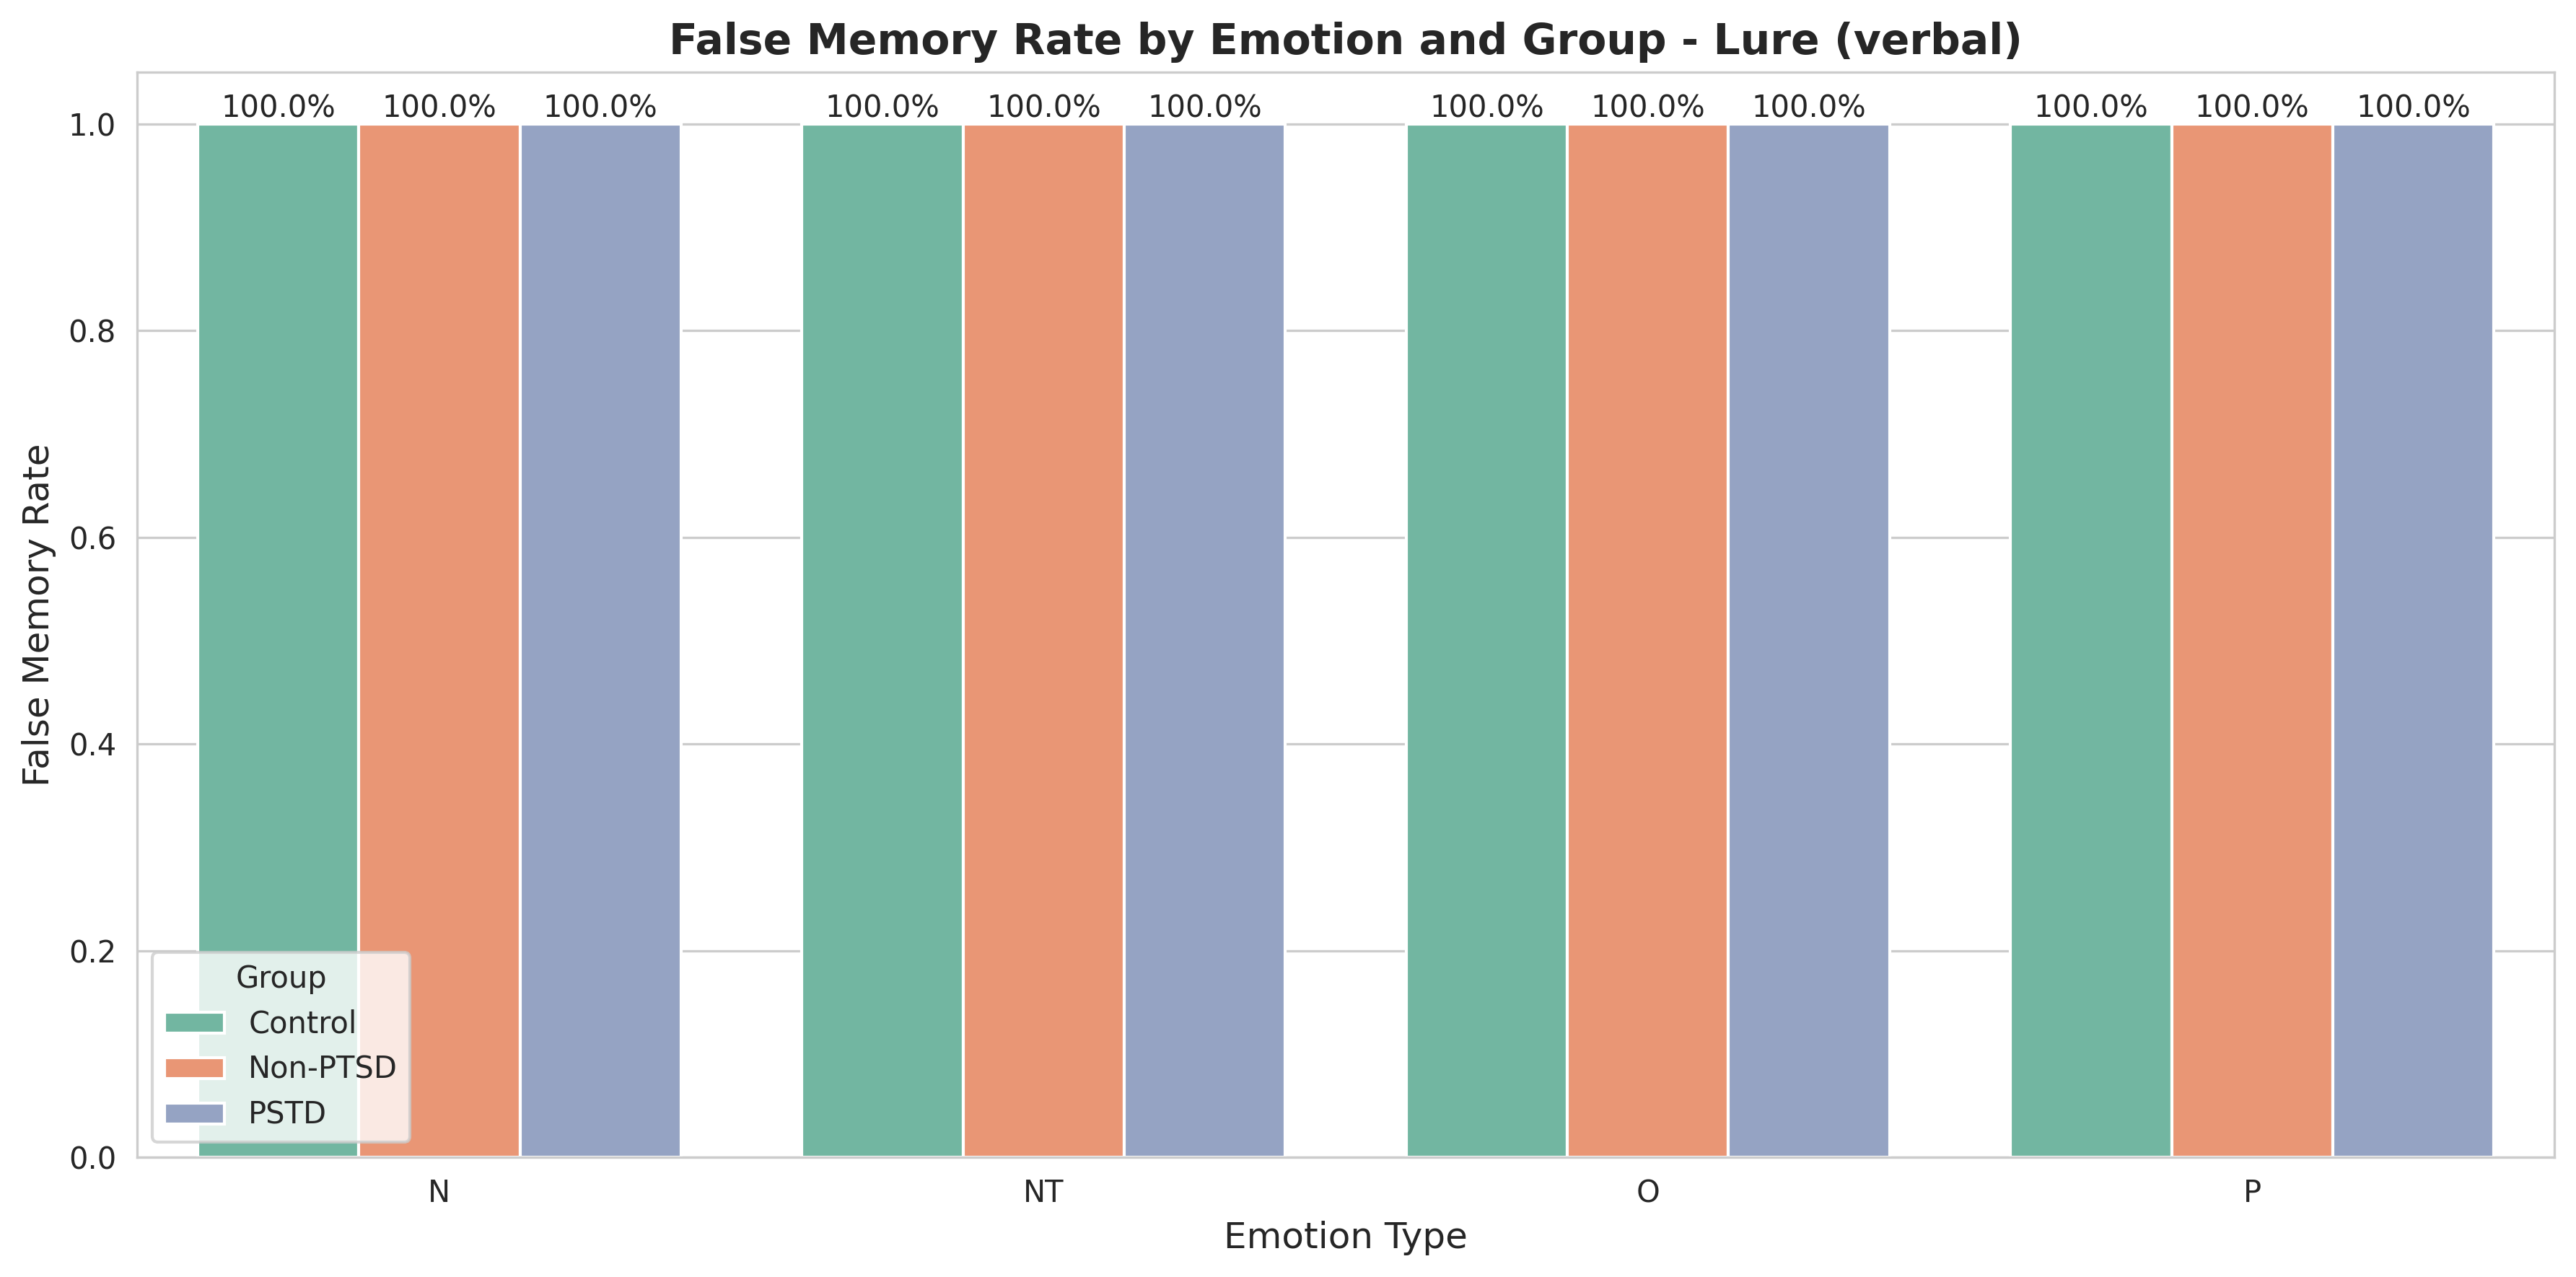

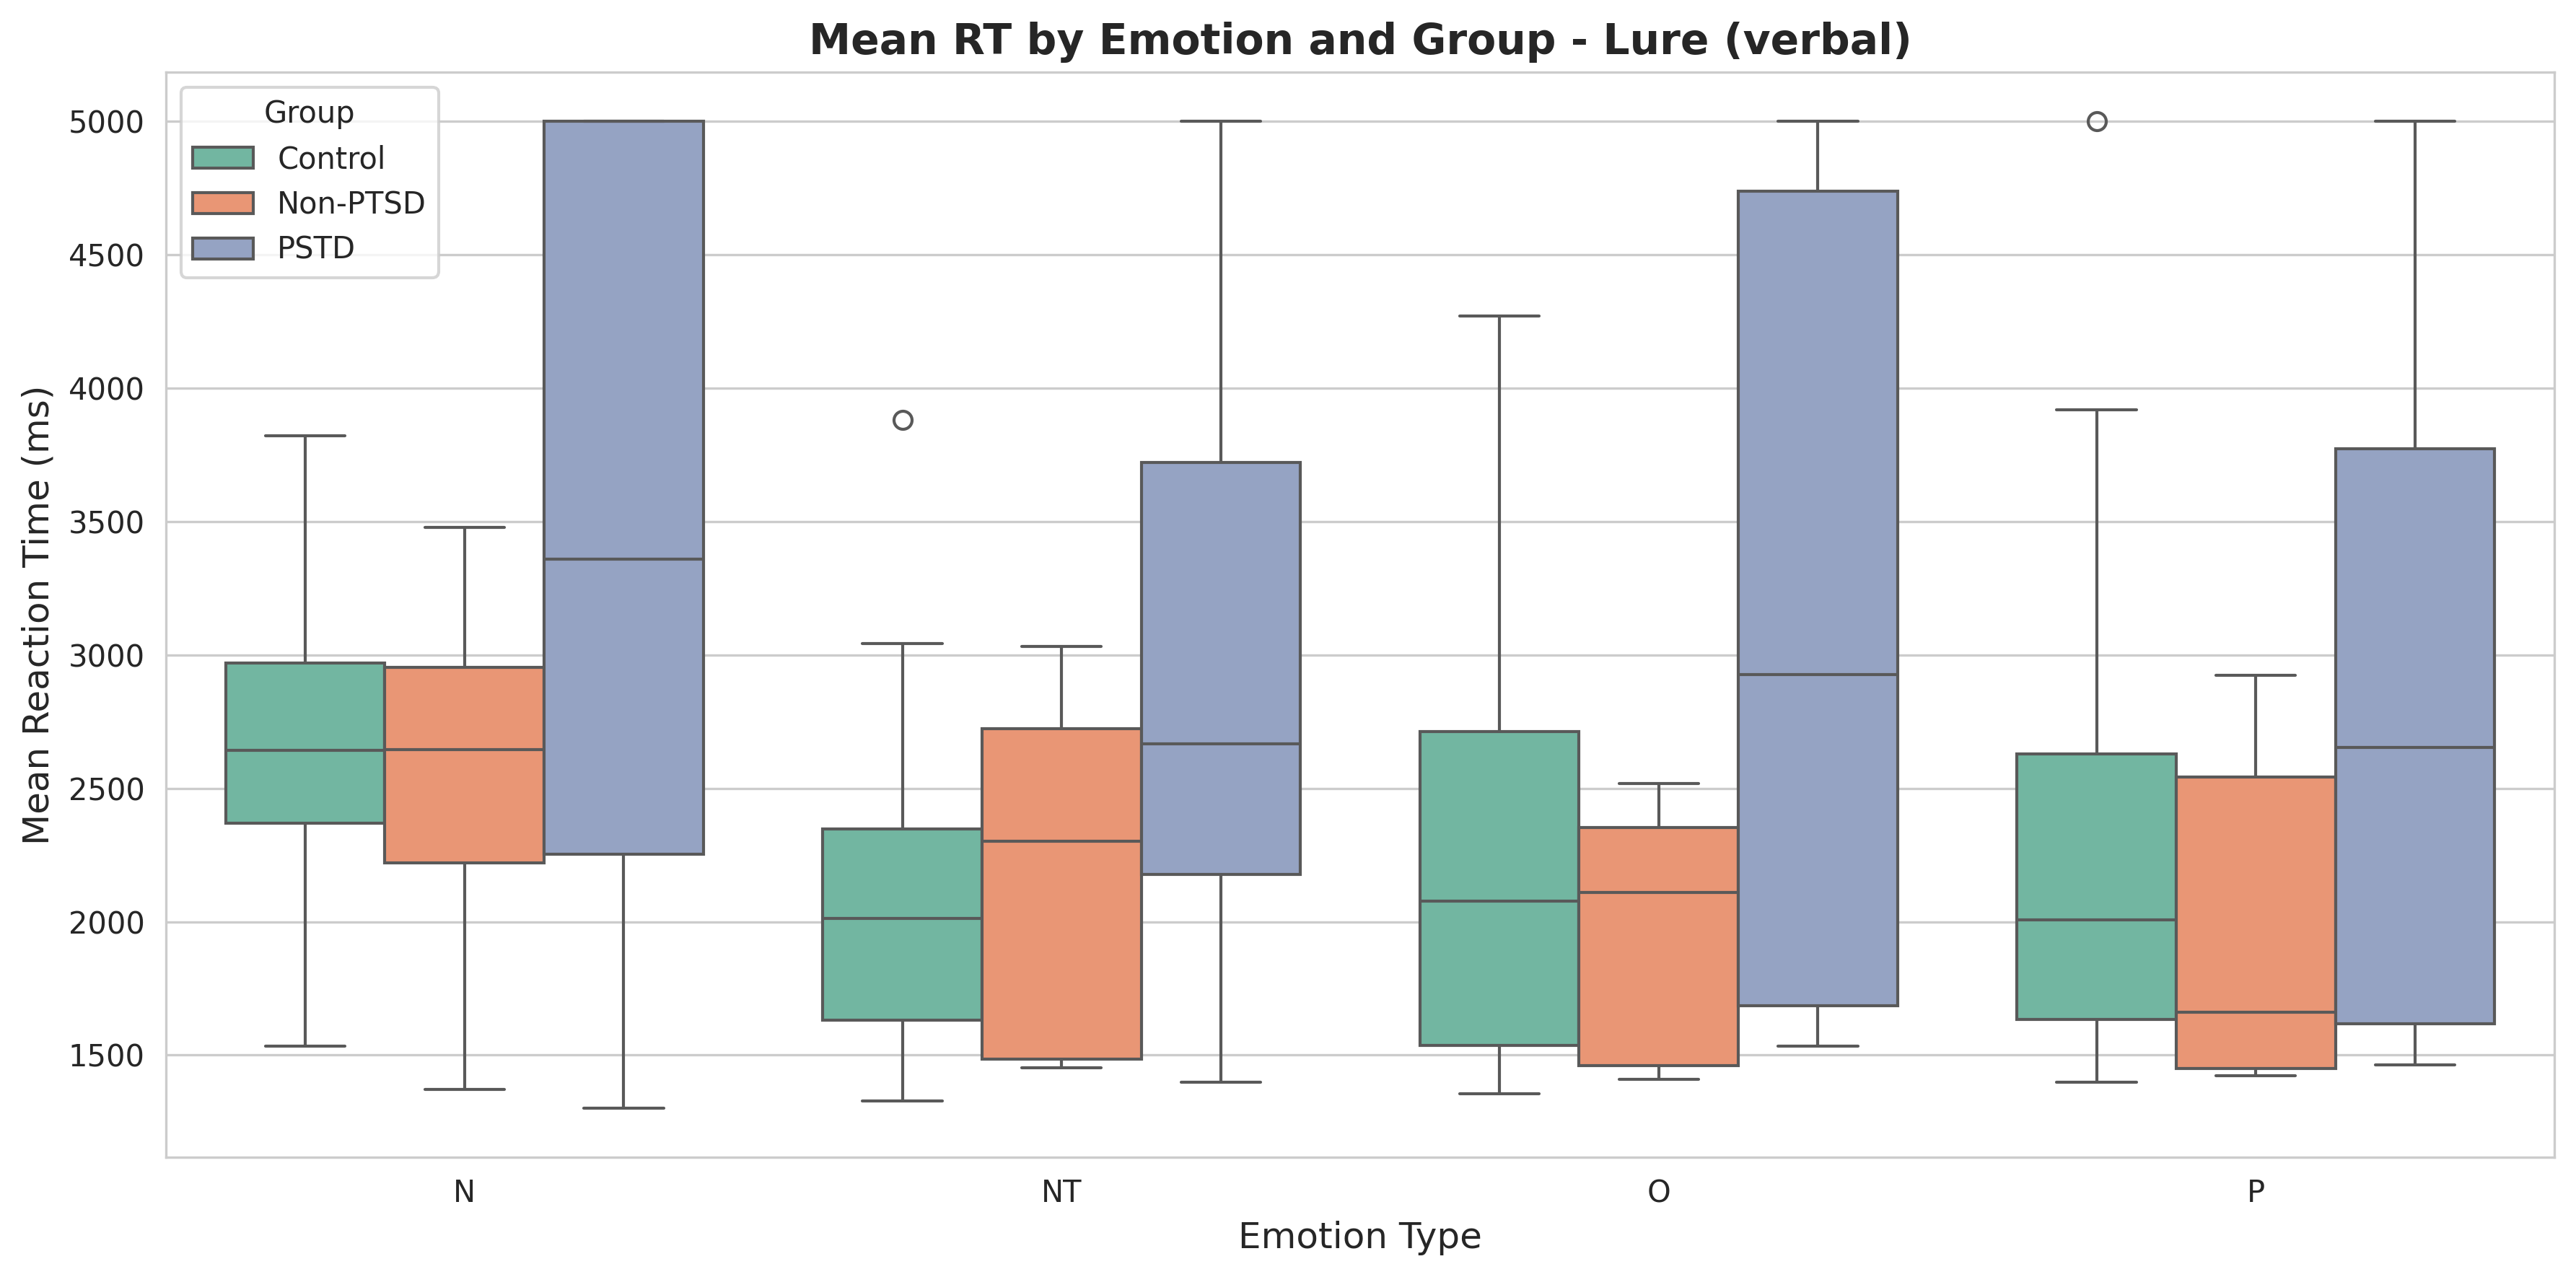

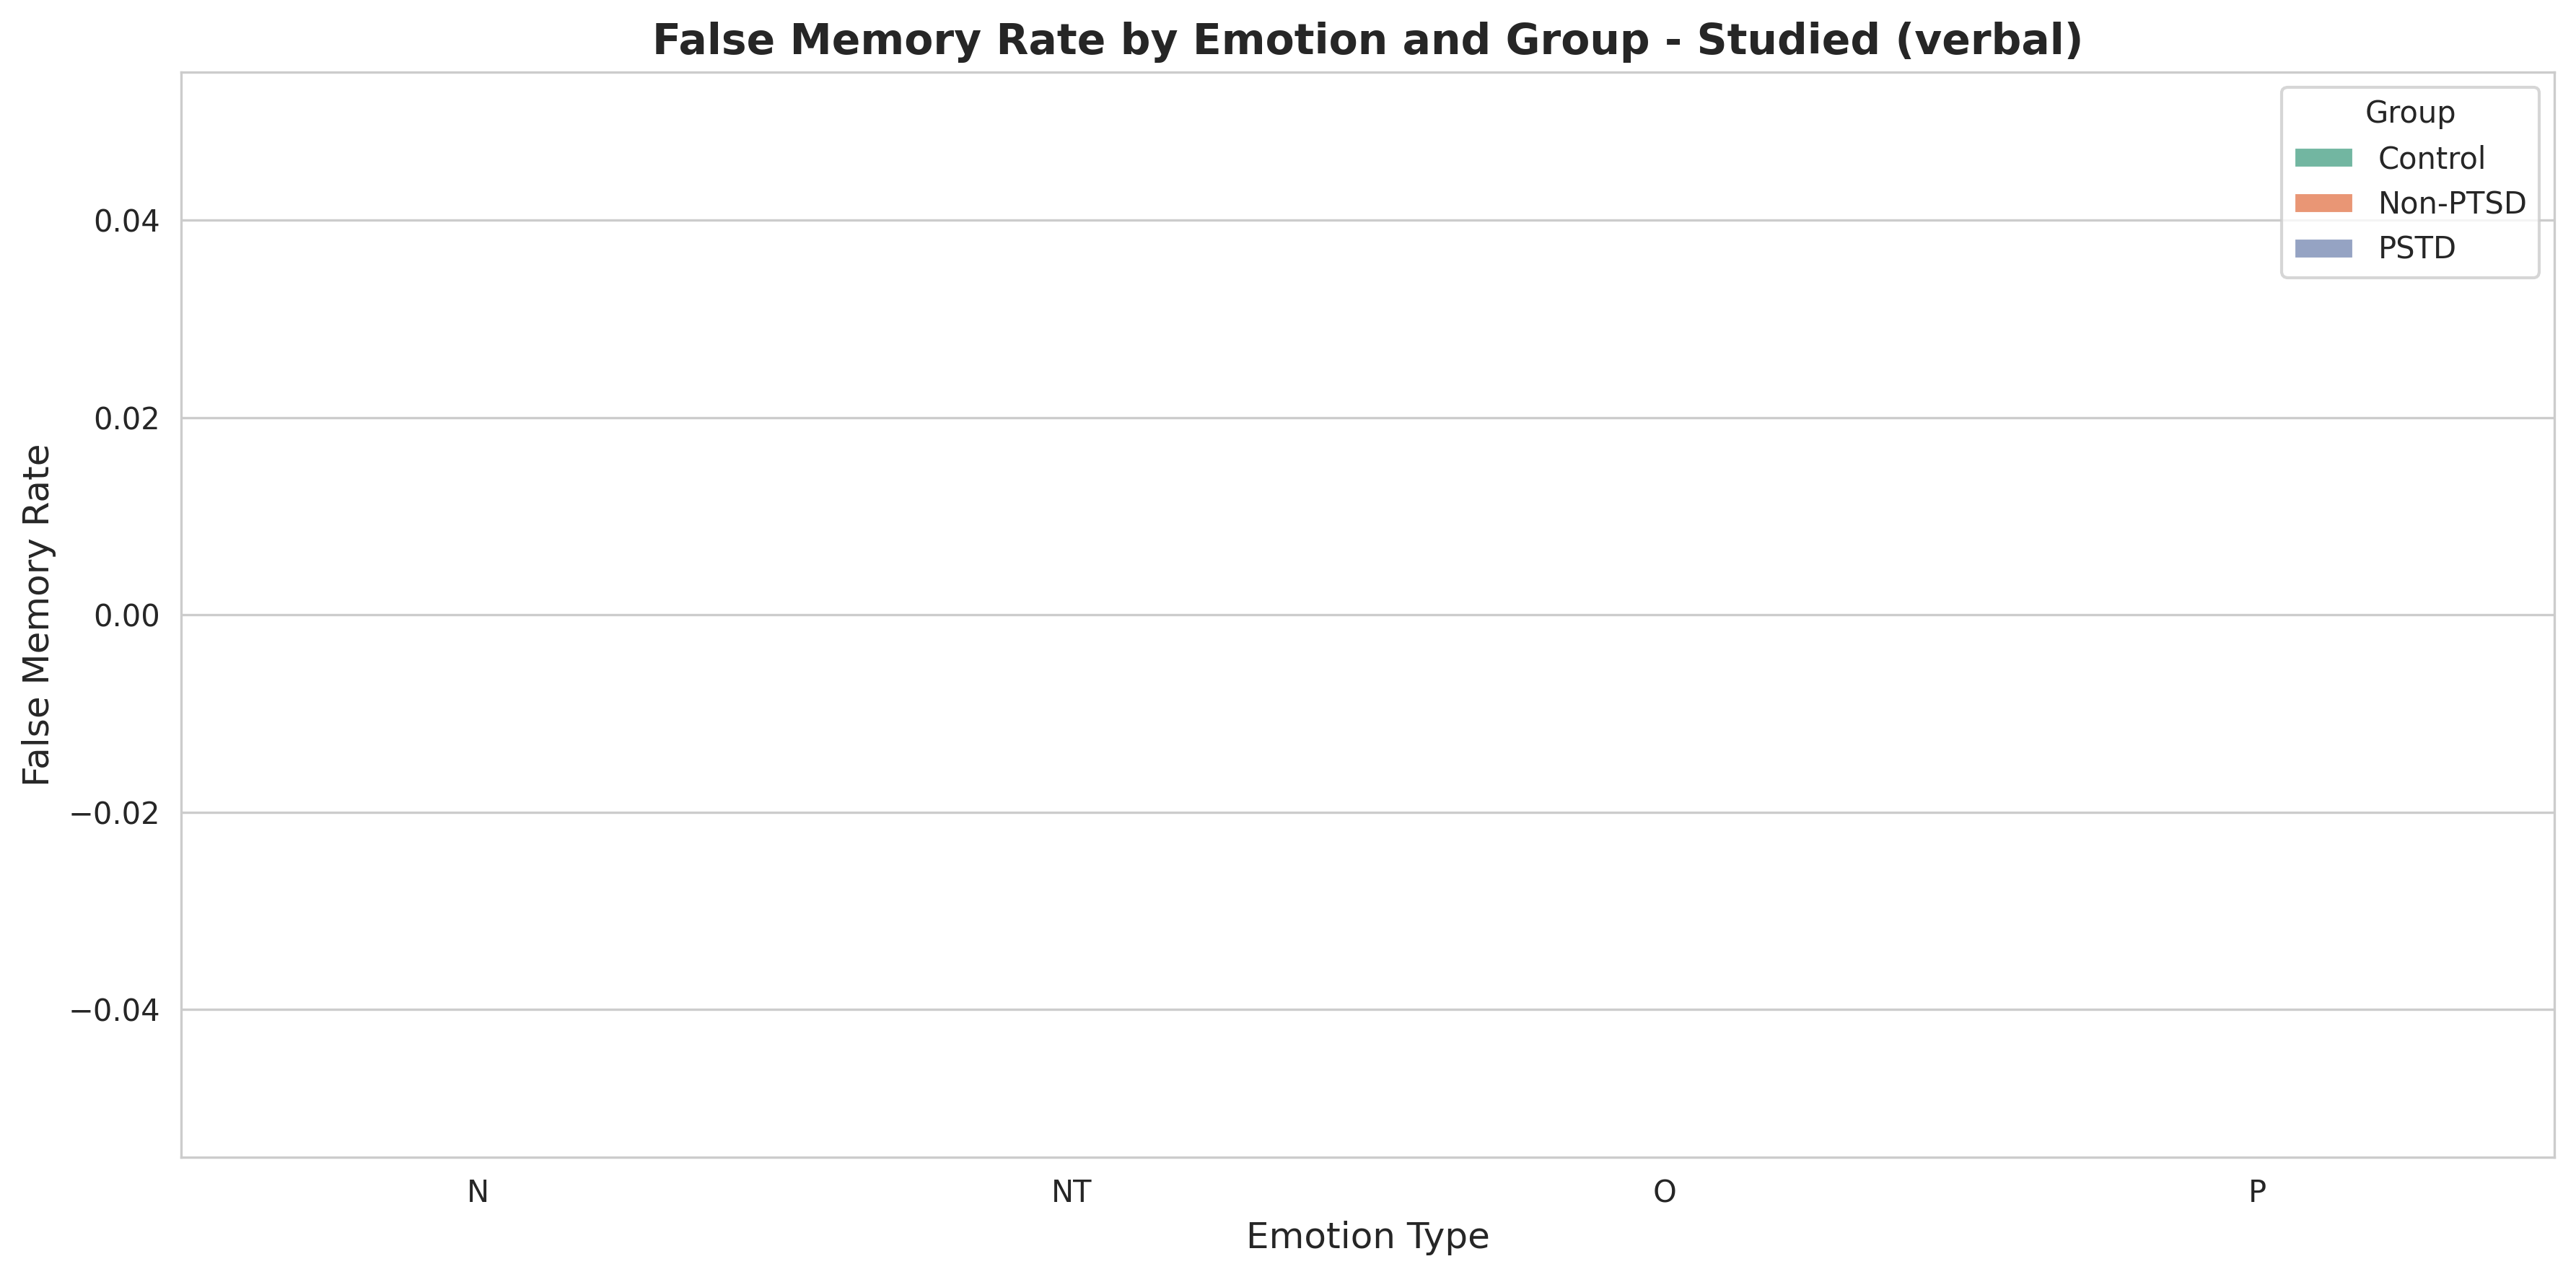

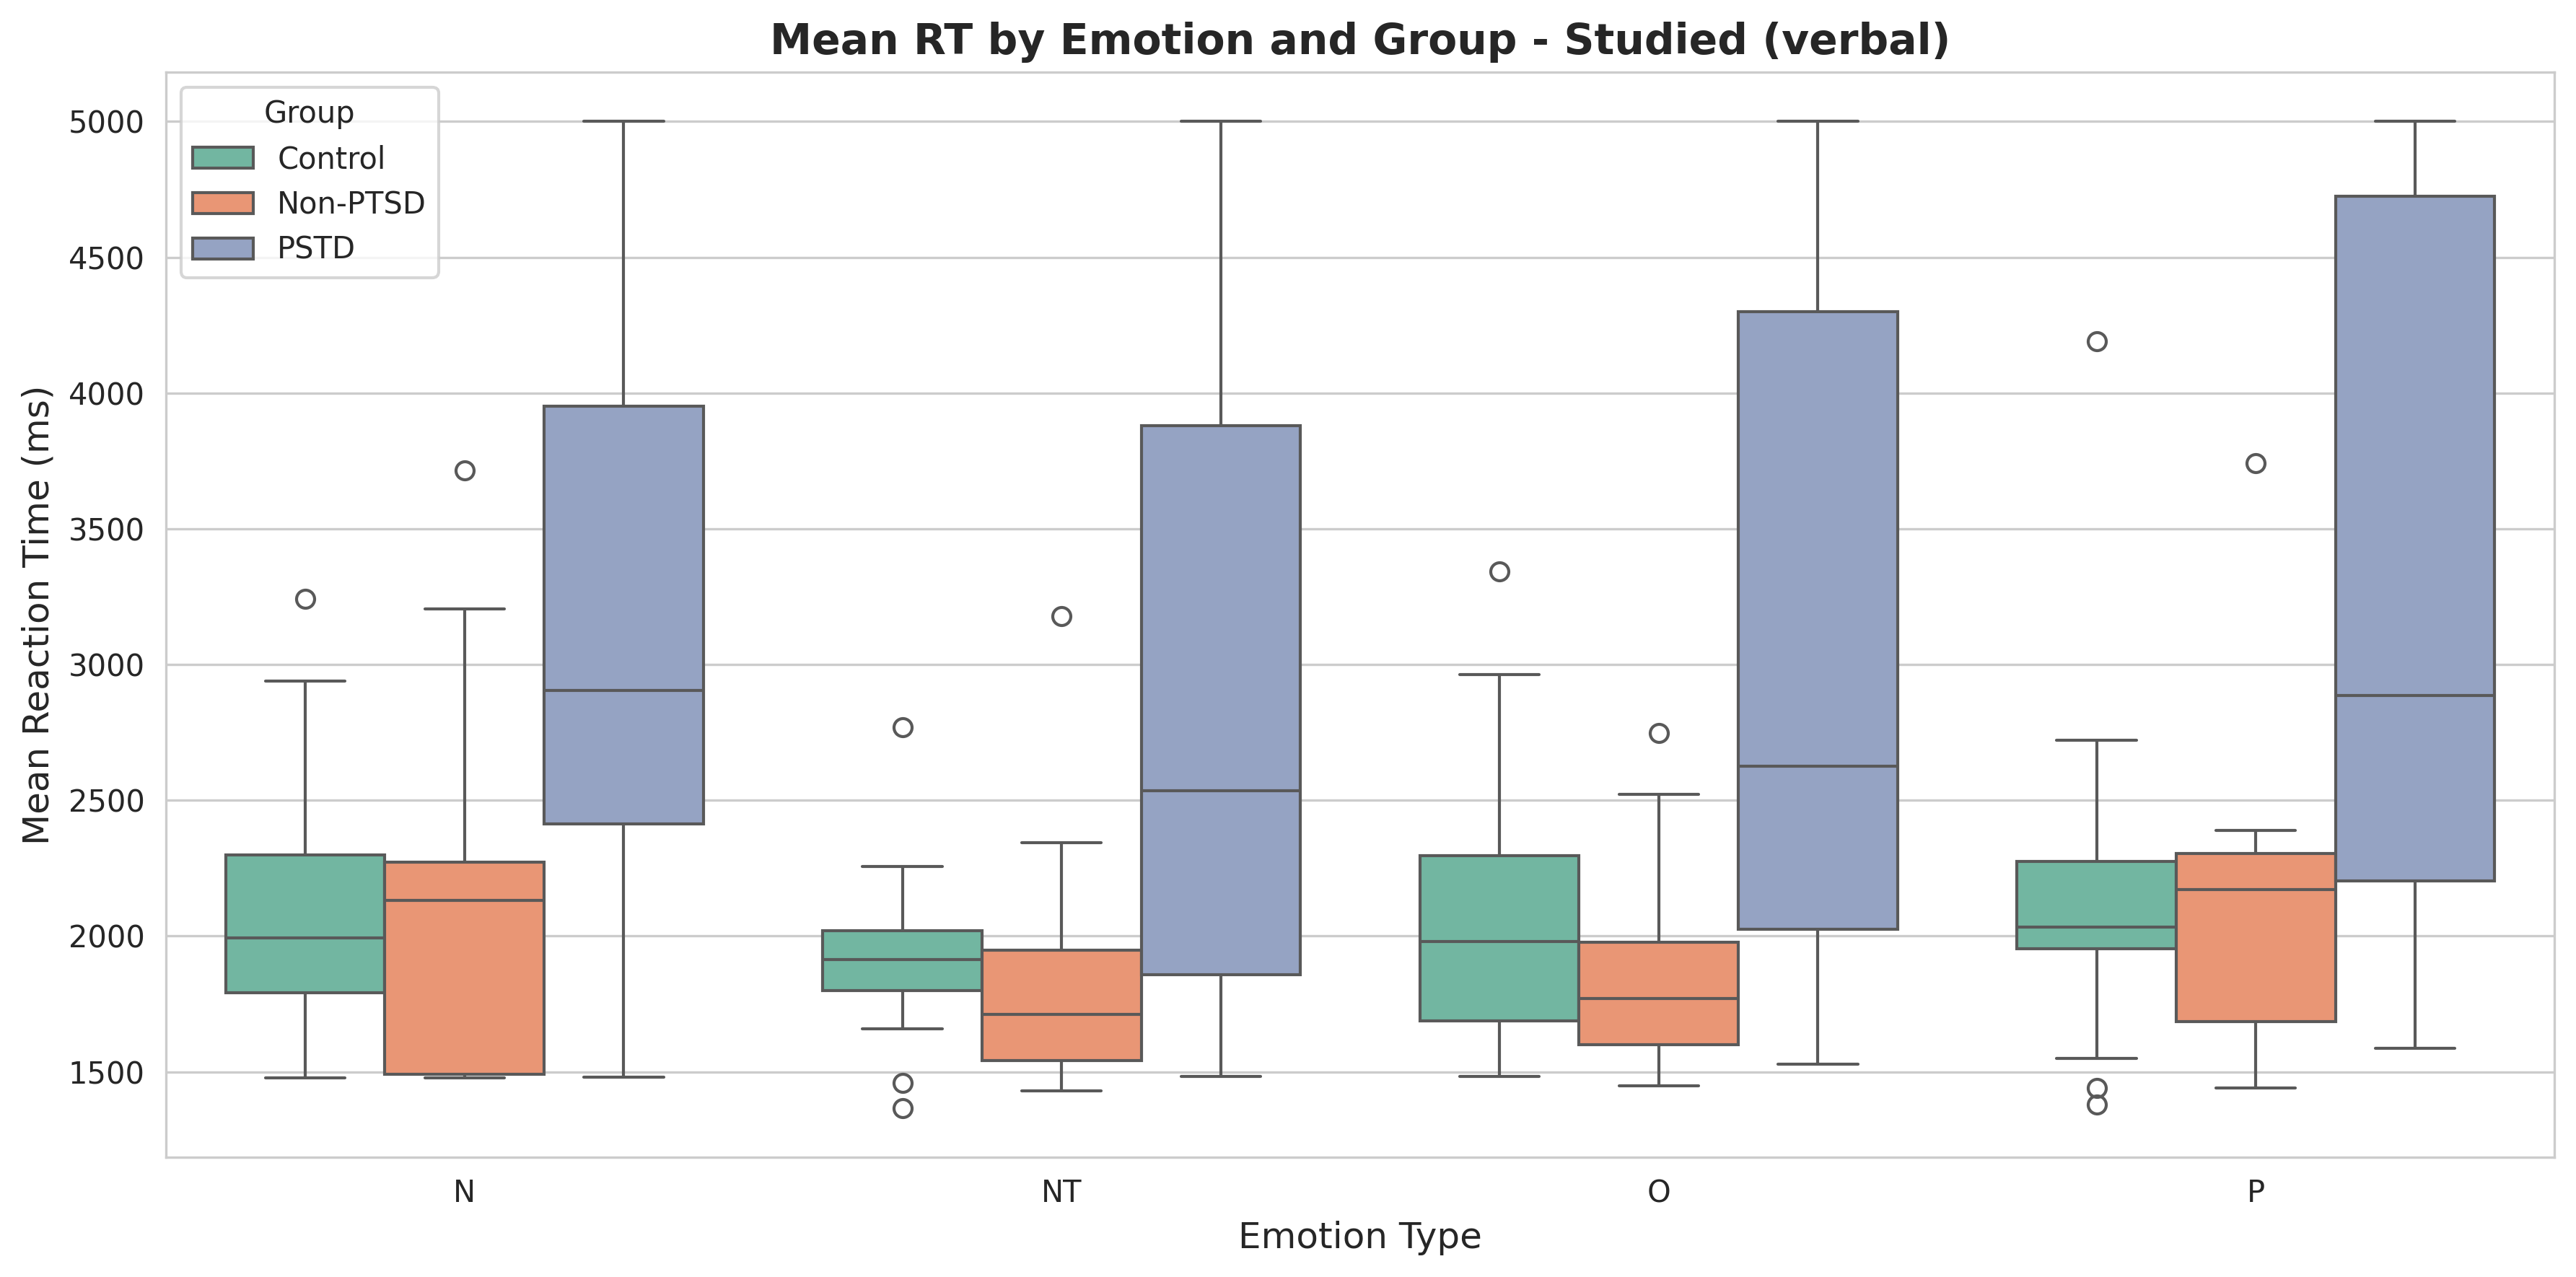

✅ Visualizations created and saved.
📊 Creating visualizations for video...


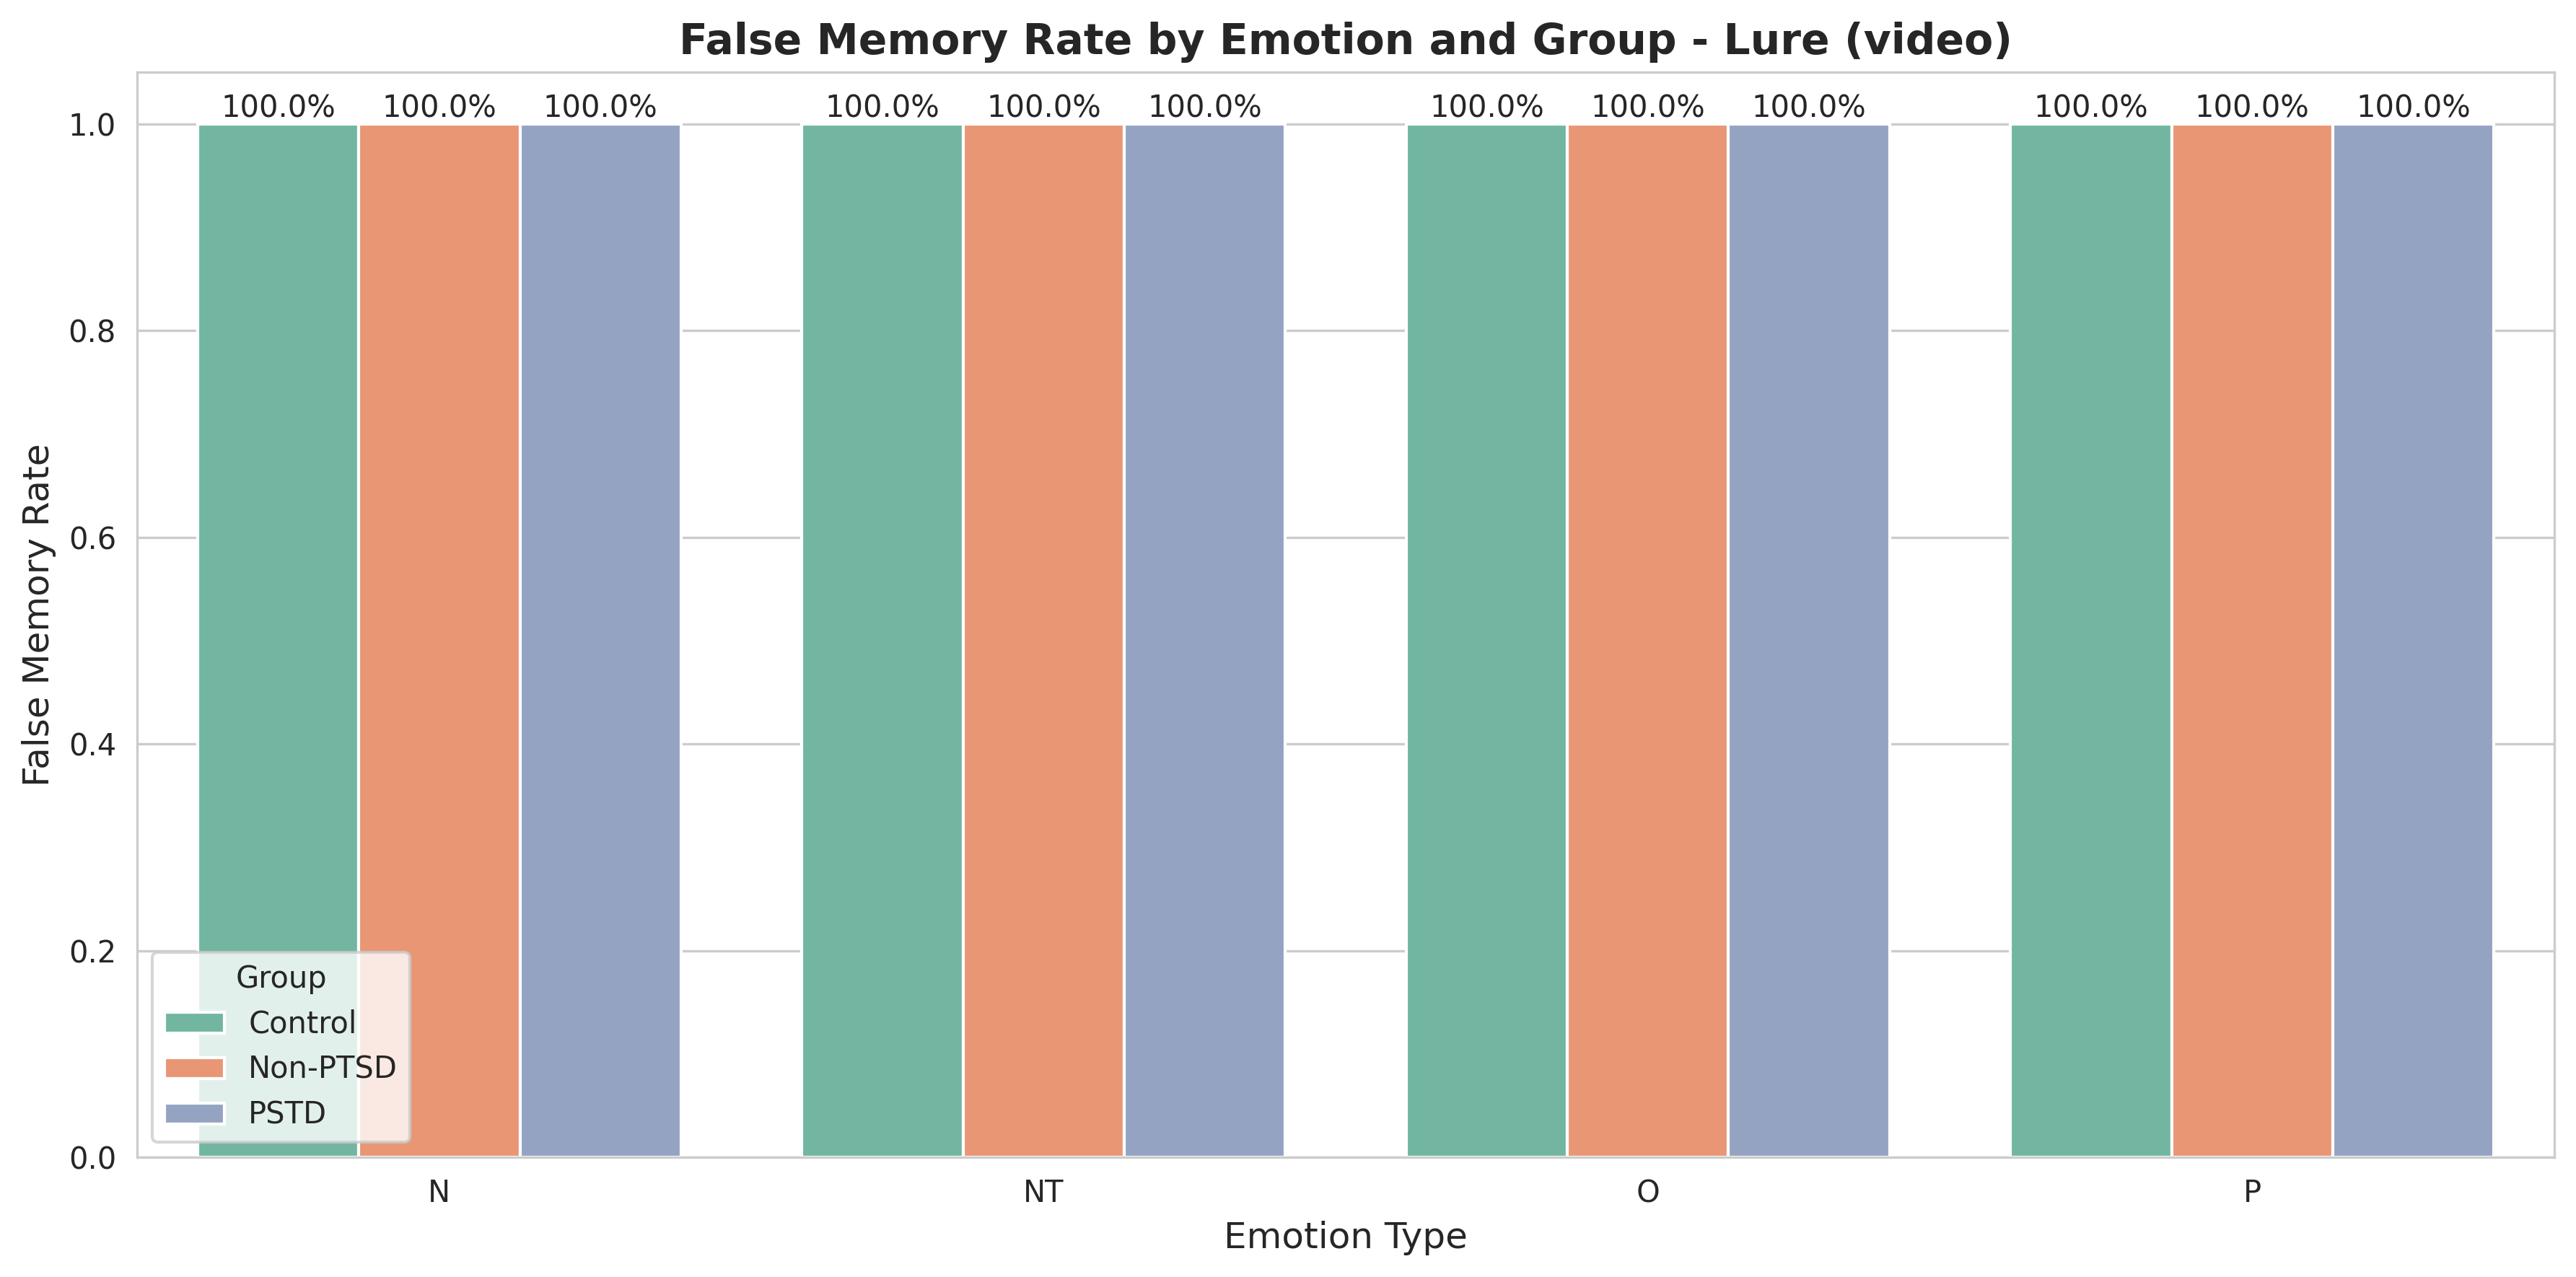

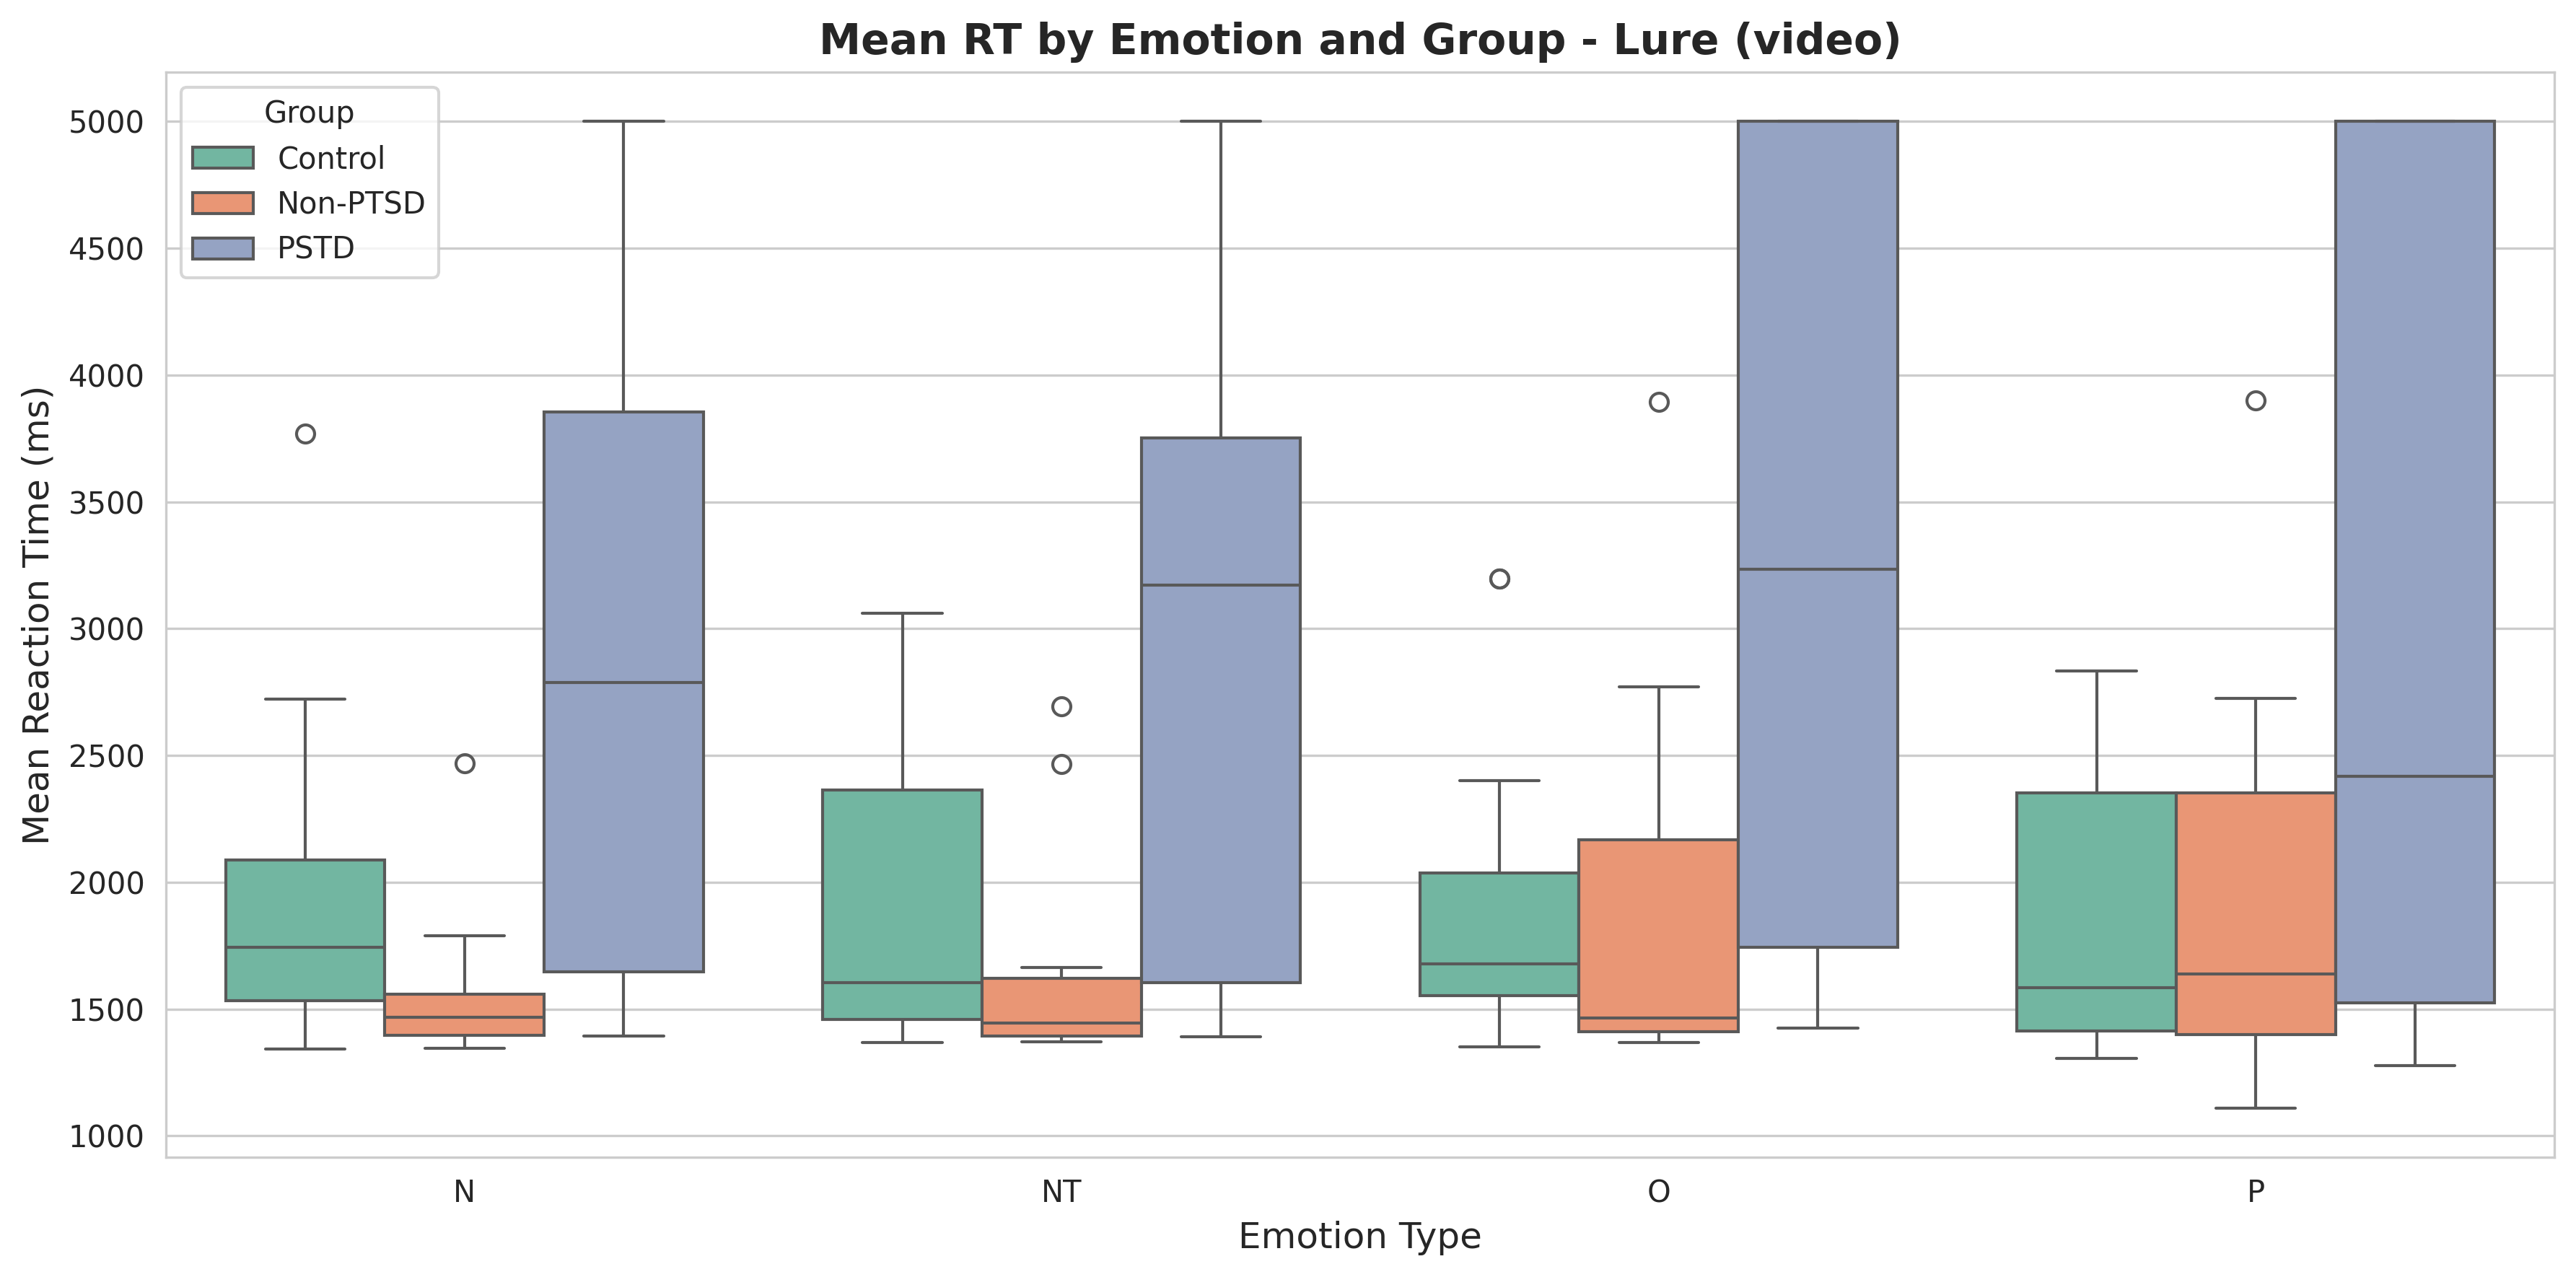

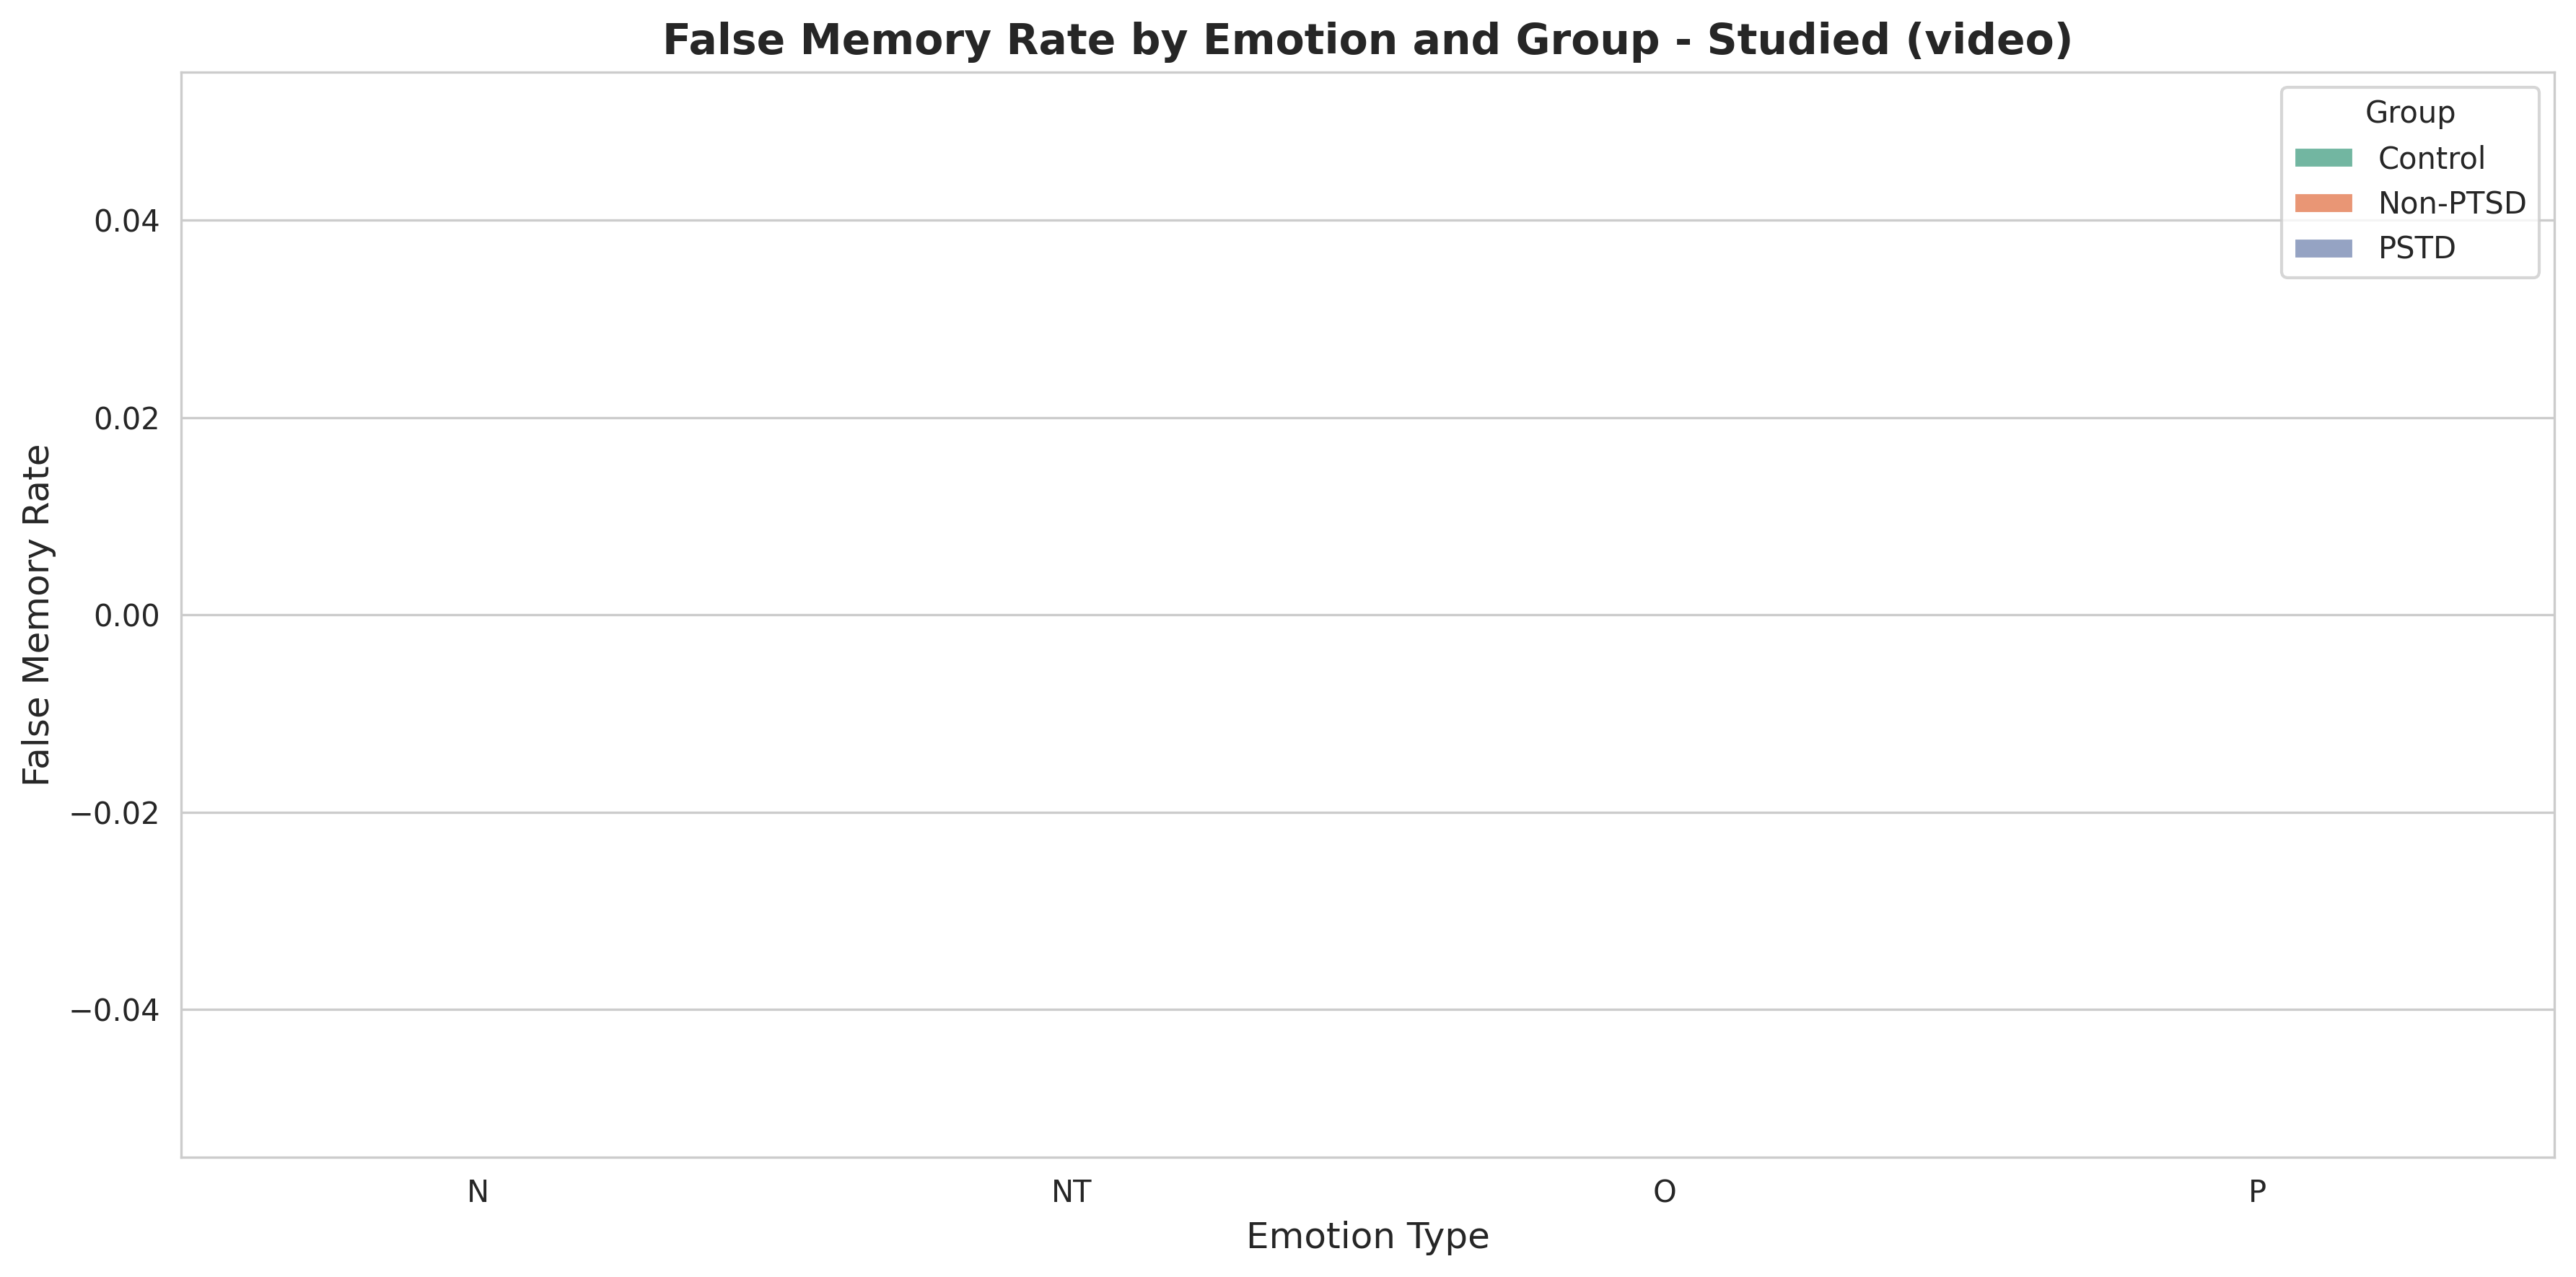

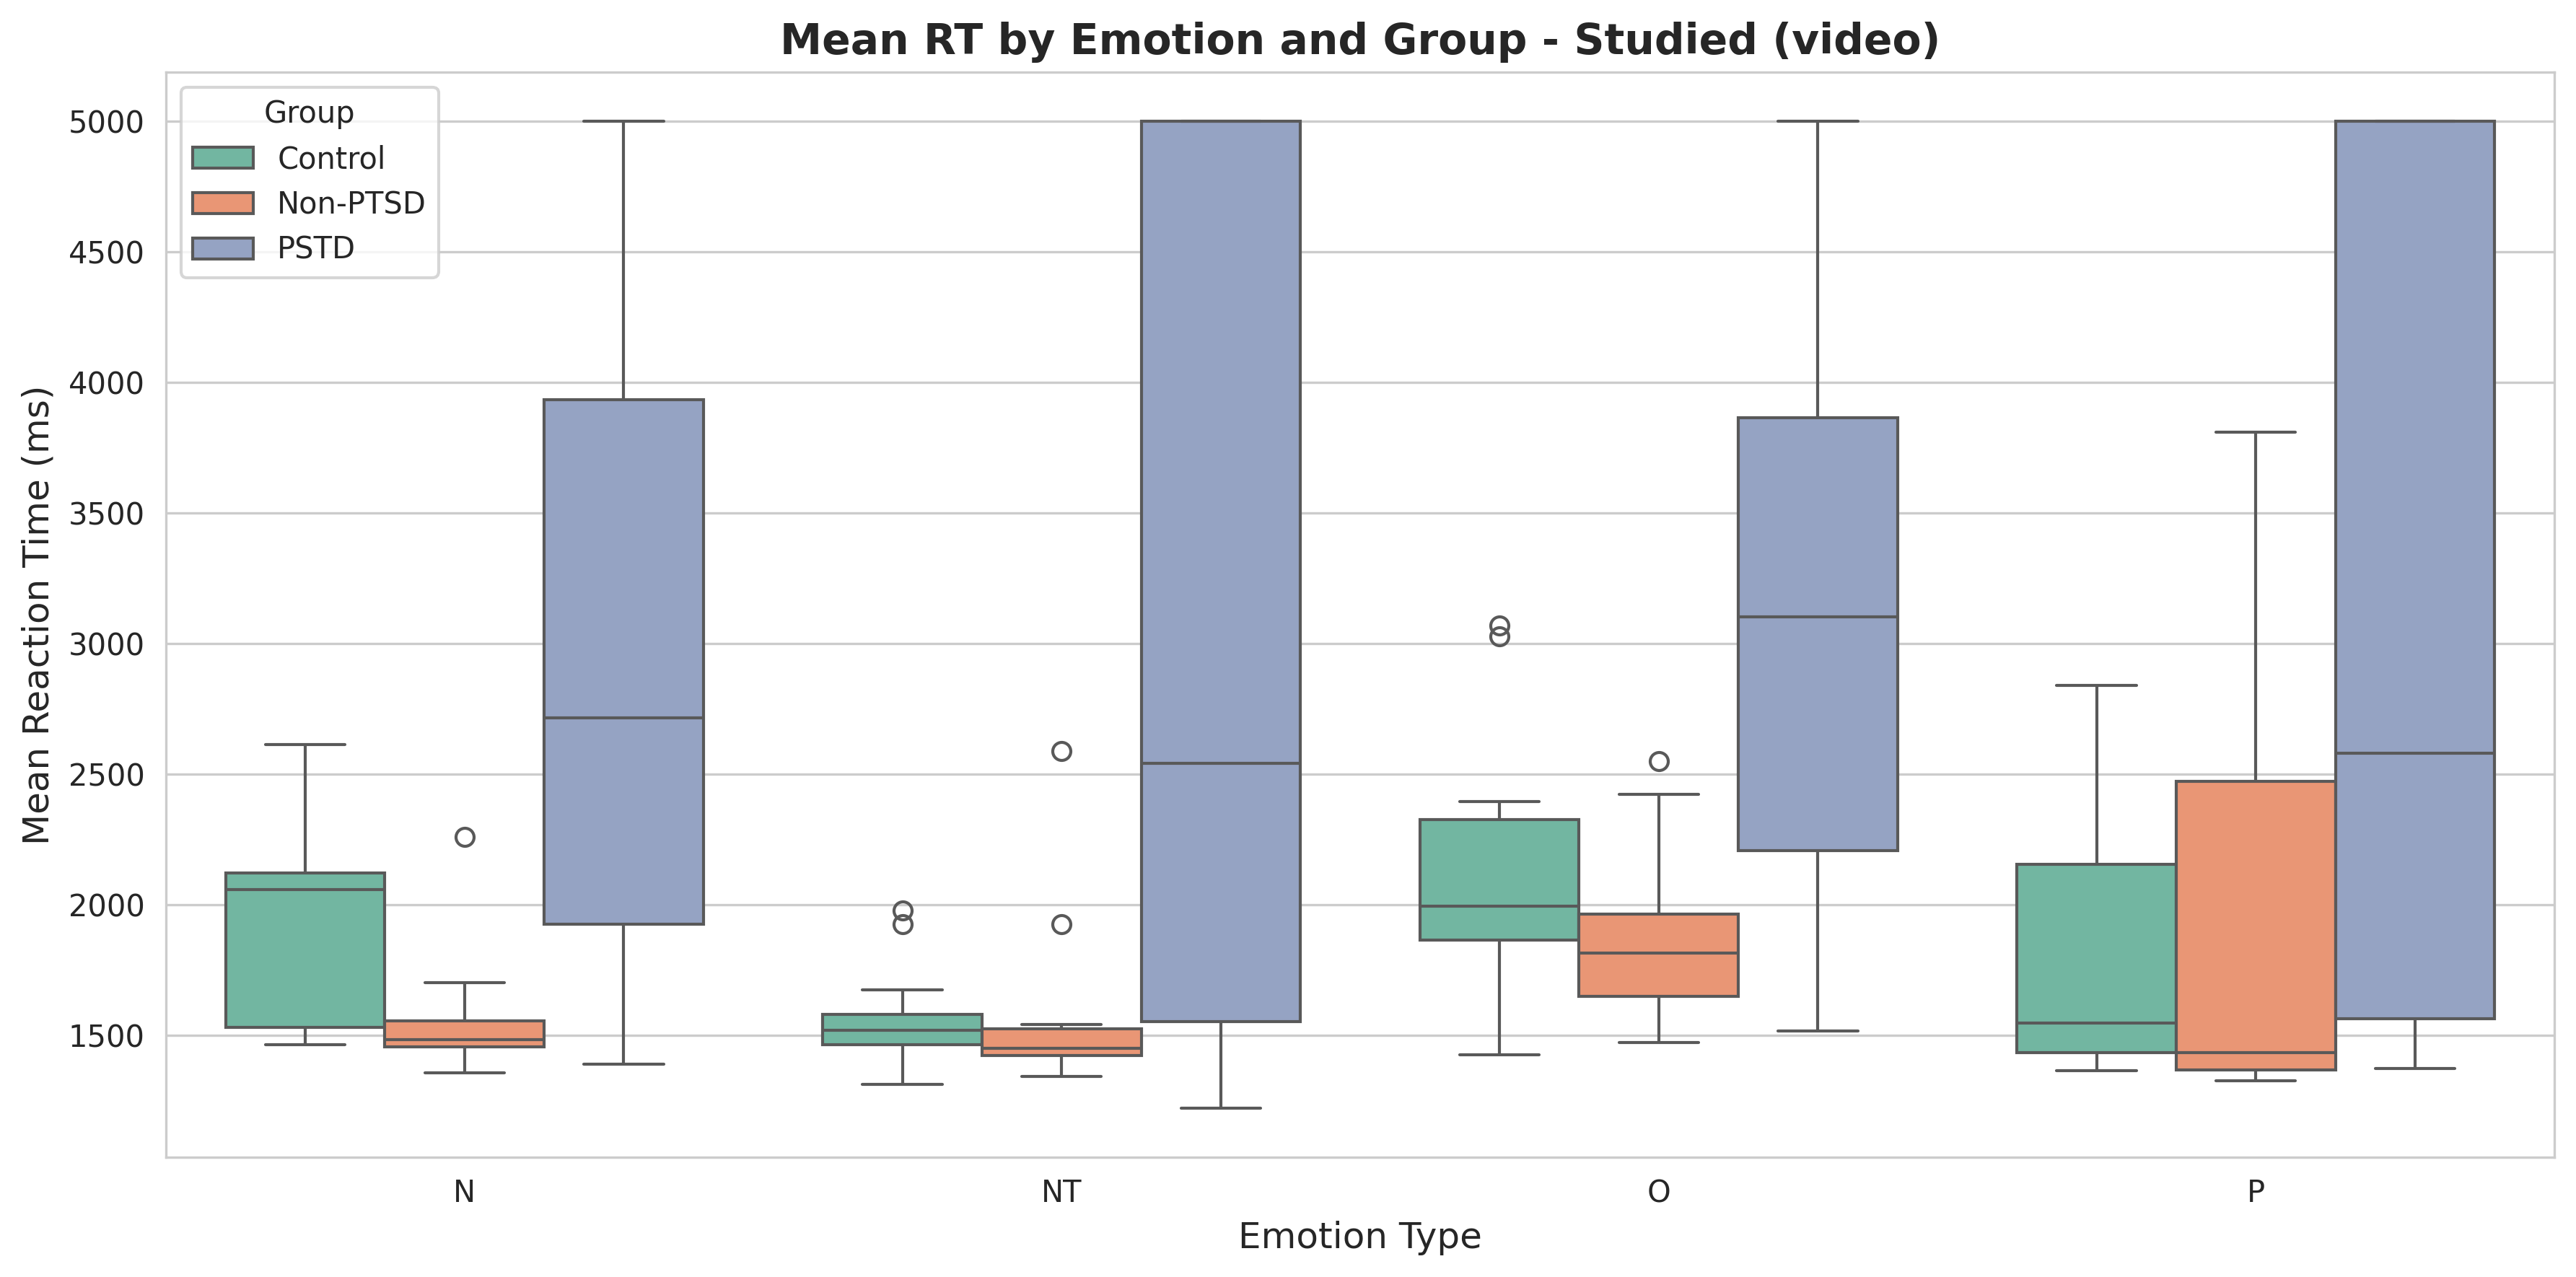

✅ Visualizations created and saved.

STEP 11: SENSITIVITY ANALYSIS
--------------------------------------------------------------------------------



NameError: name 'sensitivity_analysis' is not defined

In [ ]:
def main():
    """
    Main execution pipeline for PTSD false memory analysis.
    This orchestrates all analysis steps in the correct order.
    """

    print("\n" + "="*80)
    print("PTSD FALSE MEMORY ANALYSIS - BACHELOR THESIS")
    print("Statistical Analysis of False Memory in Iran-Iraq War PTSD Patients")
    print("="*80 + "\n")

    # -------------------------------------------------------------------------
    # STEP 1: DATA LOADING AND PREPROCESSING
    # -------------------------------------------------------------------------
    print("STEP 1: DATA LOADING AND PREPROCESSING")
    print("-" * 80 + "\n")

    all_data = []
    for file_key, file_path in FILES.items():
        processed = process_file(file_path, file_key)
        if processed is not None:
            all_data.append(processed)

    if not all_data:
        print("❌ ERROR: No data files were successfully processed!")
        return

    # Combine all data
    full_df_original = pd.concat(all_data, ignore_index=True)
    full_df_original.to_excel(os.path.join(OUTPUT_DIR, 'full_data_original.xlsx'), index=False)
    print(f"\n✅ Combined data: {len(full_df_original)} trials, {full_df_original['candidate'].nunique()} subjects\n")

    # Save copy for sensitivity analysis (before imputation)
    full_df_no_impute = full_df_original.copy()

    # -------------------------------------------------------------------------
    # STEP 2: DATA QUALITY REPORT
    # -------------------------------------------------------------------------
    print("\nSTEP 2: DATA QUALITY REPORT")
    print("-" * 80 + "\n")

    quality_report = full_df_original.groupby(['group', 'task']).agg(
        n_subjects=('candidate', 'nunique'),
        n_trials=('response', 'count'),
        pct_missing_response=('response', lambda x: x.isna().mean() * 100),
        pct_missing_rt=('rt', lambda x: x.isna().mean() * 100),
        n_negative_rt=('rt', lambda x: (x.isna() & (full_df_original.loc[x.index, 'response'] == 1)).sum())
    ).reset_index()

    quality_report.to_excel(os.path.join(OUTPUT_DIR, 'data_quality_report.xlsx'), index=False)
    print("📋 Data Quality Report:")
    print(quality_report.to_string(index=False))
    print()

    # -------------------------------------------------------------------------
    # STEP 3: RT IMPUTATION
    # -------------------------------------------------------------------------
    print("\nSTEP 3: REACTION TIME IMPUTATION")
    print("-" * 80 + "\n")

    full_df = impute_negative_rt(full_df_original)
    full_df.to_excel(os.path.join(OUTPUT_DIR, 'full_data_imputed.xlsx'), index=False)

    # -------------------------------------------------------------------------
    # STEP 4: SEPARATE TASKS
    # -------------------------------------------------------------------------
    print("\nSTEP 4: SEPARATING VERBAL AND VIDEO TASKS")
    print("-" * 80 + "\n")

    verbal_df = full_df[full_df['task'] == 'verbal'].copy()
    video_df = full_df[full_df['task'] == 'video'].copy()

    print(f"✅ Verbal: {len(verbal_df)} trials, {verbal_df['candidate'].nunique()} subjects")
    print(f"✅ Video: {len(video_df)} trials, {video_df['candidate'].nunique()} subjects\n")

    # -------------------------------------------------------------------------
    # STEP 5: AGGREGATION
    # -------------------------------------------------------------------------
    print("\nSTEP 5: DATA AGGREGATION TO SUBJECT LEVEL")
    print("-" * 80 + "\n")

    agg_verbal = aggregate_data(verbal_df, 'verbal')
    agg_video = aggregate_data(video_df, 'video')

    # -------------------------------------------------------------------------
    # STEP 6: DESCRIPTIVE STATISTICS
    # -------------------------------------------------------------------------
    print("\nSTEP 6: DESCRIPTIVE STATISTICS")
    print("-" * 80 + "\n")

    desc_verbal = calculate_descriptives(agg_verbal, 'verbal')
    desc_video = calculate_descriptives(agg_video, 'video')

    # -------------------------------------------------------------------------
    # STEP 7: ASSUMPTIONS TESTING
    # -------------------------------------------------------------------------
    print("\nSTEP 7: TESTING STATISTICAL ASSUMPTIONS")
    print("-" * 80 + "\n")

    norm_verbal, homog_verbal = test_assumptions(agg_verbal, 'verbal')
    norm_video, homog_video = test_assumptions(agg_video, 'video')

    # -------------------------------------------------------------------------
    # STEP 8: INFERENTIAL STATISTICS
    # -------------------------------------------------------------------------
    print("\nSTEP 8: INFERENTIAL STATISTICAL TESTS")
    print("-" * 80 + "\n")

    run_statistical_tests(agg_verbal, 'verbal')
    run_statistical_tests(agg_video, 'video')

    # Load results for thesis generation
    stat_results_verbal = {}
    stat_results_video = {}

    for result_type in ['friedman', 'kruskal', 'posthoc']:
        verbal_path = os.path.join(OUTPUT_DIR, f'{result_type}_verbal.xlsx')
        video_path = os.path.join(OUTPUT_DIR, f'{result_type}_video.xlsx')

        if os.path.exists(verbal_path):
            stat_results_verbal[result_type] = pd.read_excel(verbal_path)
        if os.path.exists(video_path):
            stat_results_video[result_type] = pd.read_excel(video_path)

    # -------------------------------------------------------------------------
    # STEP 9: POWER ANALYSIS
    # -------------------------------------------------------------------------
    print("\nSTEP 9: STATISTICAL POWER ANALYSIS")
    print("-" * 80 + "\n")

    power_verbal = calculate_power_analysis(agg_verbal, 'verbal')
    power_video = calculate_power_analysis(agg_video, 'video')

    # -------------------------------------------------------------------------
    # STEP 10: VISUALIZATIONS
    # -------------------------------------------------------------------------
    print("\nSTEP 10: CREATING VISUALIZATIONS")
    print("-" * 80 + "\n")

    create_visualizations(agg_verbal, 'verbal', desc_verbal)
    create_visualizations(agg_video, 'video', desc_video)

    # -------------------------------------------------------------------------
    # STEP 11: SENSITIVITY ANALYSIS
    # -------------------------------------------------------------------------
    print("\nSTEP 11: SENSITIVITY ANALYSIS")
    print("-" * 80 + "\n")

    sensitivity_df, sensitivity_comparison = sensitivity_analysis(full_df_no_impute, full_df)

    # -------------------------------------------------------------------------
    # STEP 12: GENERATE THESIS TEXT
    # -------------------------------------------------------------------------
    print("\nSTEP 12: GENERATING THESIS CHAPTER 4 TEXT")
    print("-" * 80 + "\n")

    thesis_verbal = generate_thesis_snippets(desc_verbal, stat_results_verbal, power_verbal, 'verbal')
    thesis_video = generate_thesis_snippets(desc_video, stat_results_video, power_video, 'video')

    # -------------------------------------------------------------------------
    # FINAL SUMMARY
    # -------------------------------------------------------------------------
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE!")
    print("="*80 + "\n")

    print("📁 All outputs saved to:", OUTPUT_DIR)
    print("\n📊 Generated Files:")
    print("   - Data: full_data_original.xlsx, full_data_imputed.xlsx")
    print("   - Aggregated: aggregated_verbal.xlsx, aggregated_video.xlsx")
    print("   - Descriptives: descriptives_verbal.xlsx, descriptives_video.xlsx")
    print("   - Tests: friedman_*.xlsx, kruskal_*.xlsx, posthoc_*.xlsx")
    print("   - Power: power_analysis_verbal.xlsx, power_analysis_video.xlsx")
    print("   - Sensitivity: sensitivity_analysis.xlsx, sensitivity_comparison.xlsx")
    print("   - Visualizations: bar_*.png, box_*.png")
    print("   - Thesis Text: thesis_chapter4_verbal.txt, thesis_chapter4_video.txt")

    print("\n✅ Ready for thesis Chapter 4 (Results) and Chapter 5 (Discussion)!")
    print("\n" + "="*80 + "\n")


# ============================================================================
# RUN THE ANALYSIS
# ============================================================================

if __name__ == "__main__":
    main()

In [ ]:

if __name__ == "__main__":
    main()


NameError: name 'main' is not defined

In [1]:
!pip install pingouin
import pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 3.3 MB/s eta 0:00:00


Processing verbal_PSTD...
Processing verbal_Non-PTSD...
Processing verbal_Control...
Processing video_PSTD...
Processing video_Non-PTSD...
Processing video_Control...

Full data processed and saved.
Winsor Bias: 0.00%
Imbalance report saved.
Aggregated verbal data saved.
Aggregated video data saved.

Verbal Descriptives:
       group emotion   m_false  sd_false         m_rt       sd_rt  n_sub  \
0    Control       N  0.493823  0.234237   730.767314  353.480775     15   
1    Control      NT  0.664228  0.197267   709.166119  323.192208     15   
2    Control       O  0.565473  0.185746   698.246749  280.404718     15   
3    Control       P  0.504377  0.341728   591.849136  197.060452     15   
4    Control       U  0.301507  0.159047   931.556632  392.474462     15   
5   Non-PTSD       N  0.402293  0.253638   679.815831  356.504513     10   
6   Non-PTSD      NT  0.599156  0.258525   646.605474  211.499279     10   
7   Non-PTSD       O  0.440712  0.190812   619.397713  239.571729    

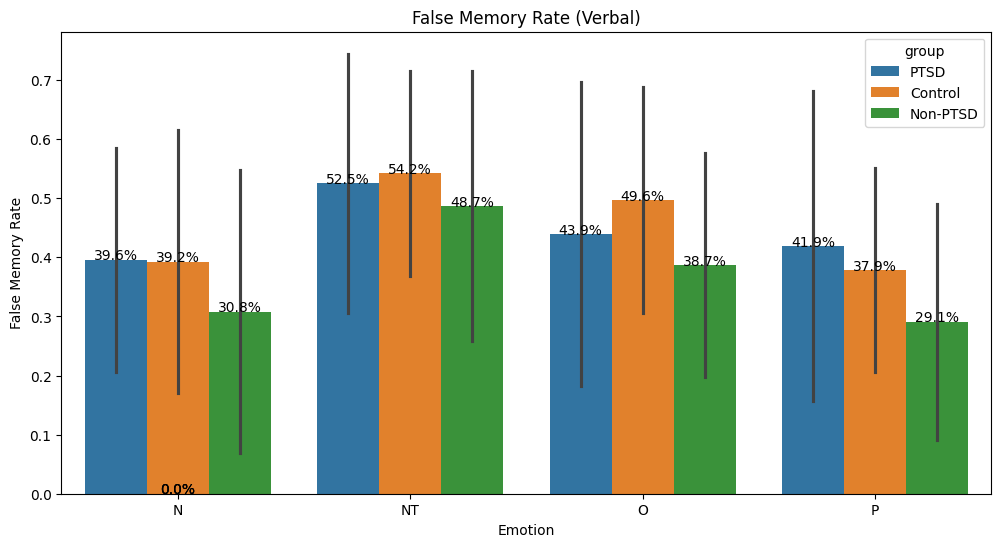

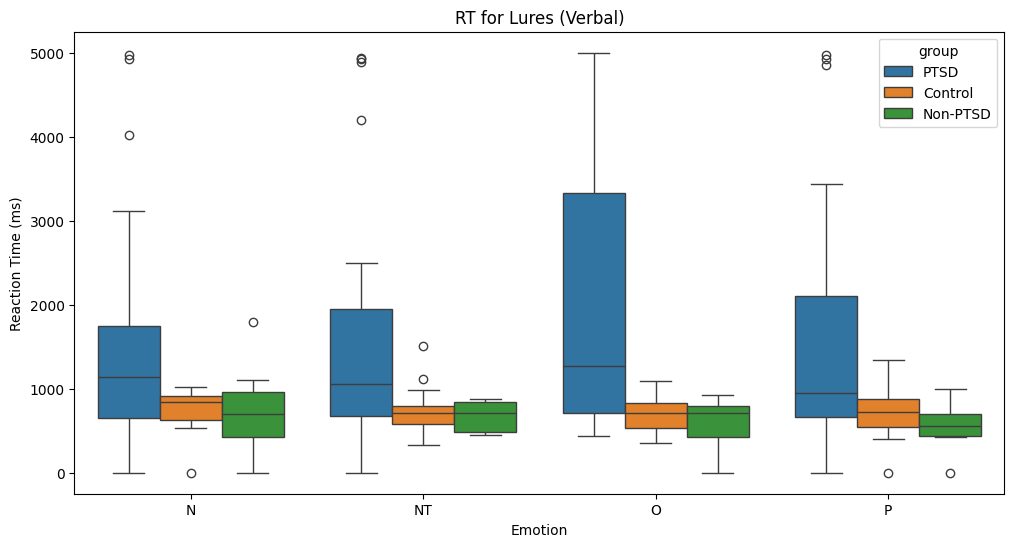

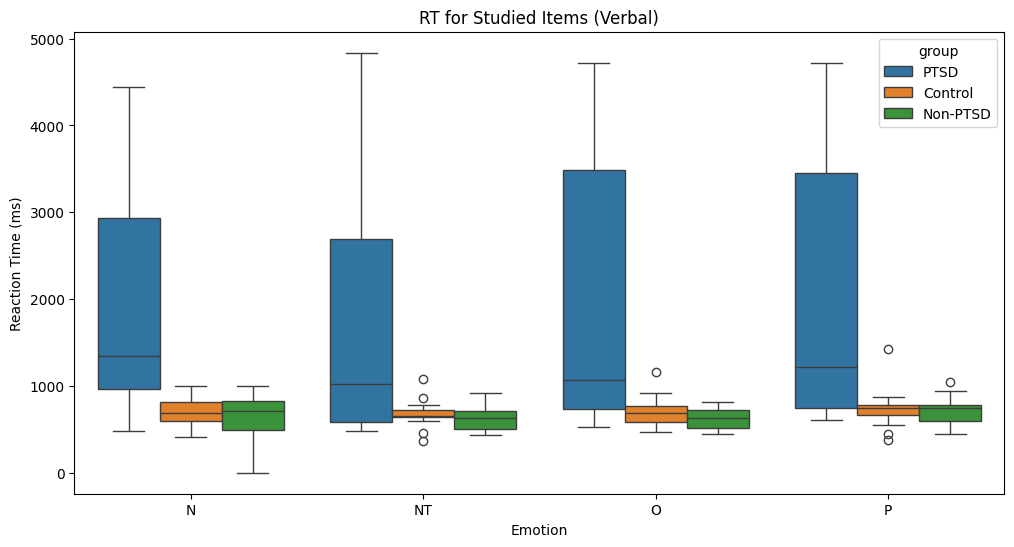


Creating visualizations for video data...


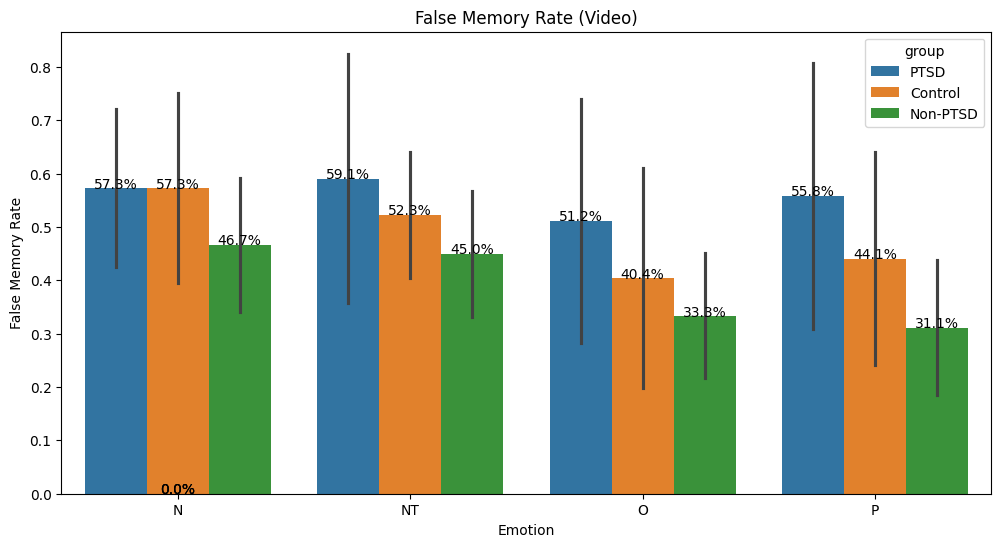

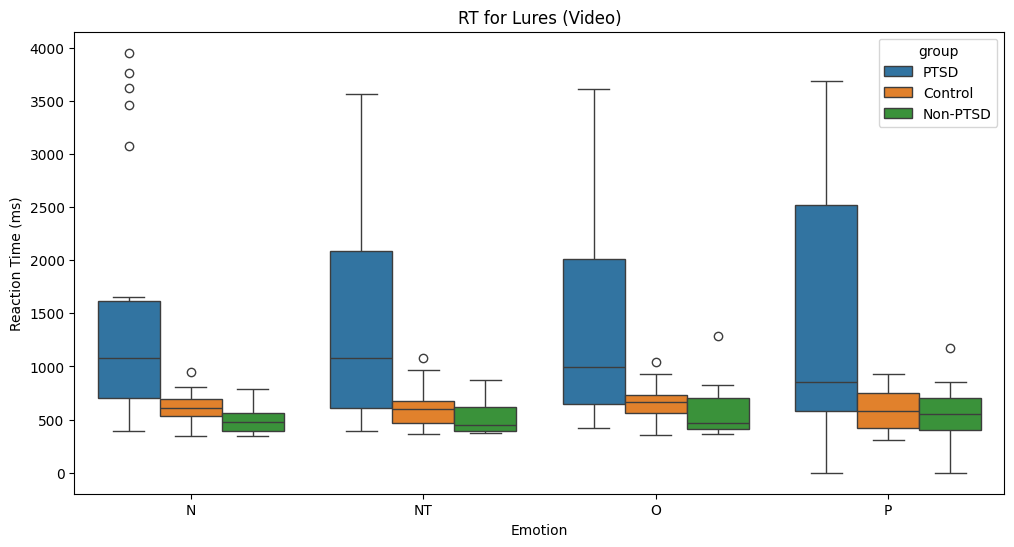

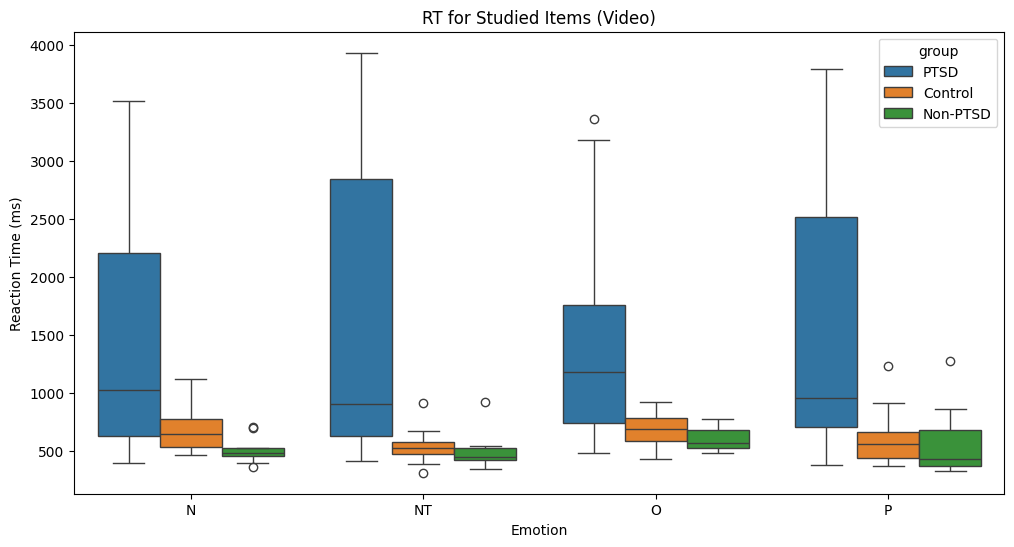


Complete. Check outputs for tables/figures. Next: Defense slides.


In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from pingouin import mixed_anova, pairwise_tests, normality, homoscedasticity
from statsmodels.stats.power import FTestAnovaPower
import os

os.makedirs('outputs', exist_ok=True)

# 1. Pre-Process Raw to Full (6 files; update paths)
files = {
    'verbal_PSTD': '/content/drive/MyDrive/AmirFarhang/ptsd_verbal.xlsx',
    'verbal_Non-PTSD': '/content/drive/MyDrive/AmirFarhang/non_ptsd_verbal.xlsx',
    'verbal_Control': '/content/drive/MyDrive/AmirFarhang/control_verbal.xlsx',
    'video_PSTD': '/content/drive/MyDrive/AmirFarhang/ptsd_video.xlsx',
    'video_Non-PTSD': '/content/drive/MyDrive/AmirFarhang/non_ptsd_visual.xlsx',
    'video_Control': '/content/drive/MyDrive/AmirFarhang/control_video.xlsx'
}

def process_raw(path, key):
    if not os.path.exists(path):
        print(f"File not found: {path}. Skipping.")
        return None

    print(f"Processing {key}...")
    df = pd.read_excel(path)
    if 'Subject' in df.columns:
        df.drop('Subject', axis=1, inplace=True)
    task, group = key.split('_')
    group = group.replace('PSTD', 'PTSD')  # Fix
    sub_cols = [col for col in df.columns if col.startswith('Sub') or col.lower().startswith('sub')]
    id_vars = [col for col in df.columns if col not in sub_cols]
    df_long = pd.melt(df, id_vars=id_vars, value_vars=sub_cols, var_name='candidate', value_name='value')
    df_long['group'] = group
    df_long['task'] = task

    # Item Type
    if 'answer' in df_long:
        df_long['item_type'] = df_long['answer'].map({1: 'Studied', 0: 'New', 'CL': 'Lure'}).fillna('Unknown')

    # Parse value to response/rt
    def parse_val(val):
        if pd.isna(val):
            return np.nan, np.nan
        val_str = str(val).replace(',', '')
        try:
            val_num = float(val_str)
        except (ValueError, TypeError):
            return np.nan, np.nan

        # If negative, assume response=1, keep rt negative for later winsor
        if val_num < 0:
            return 1, val_num

        # For non-negative, parse as string for formats like 1.748 or 1785
        if '.' in val_str:
            before, after = val_str.split('.')
        else:
            before, after = val_str, '0'

        # Response = first digit if 0 or 1
        response = np.nan
        if before and before[0] in '01':
            response = int(before[0])

        # RT = rest + '.' + after
        rt_str = before[1:] + '.' + after if len(before) > 1 else '0.' + after
        try:
            rt = float(rt_str)
        except ValueError:
            rt = np.nan

        # If response is NaN but val_num > 0, assume response=1
        if pd.isna(response) and val_num > 0:
            response = 1
            rt = val_num  # Use the full value as rt

        return response, rt

    df_long[['response', 'rt']] = df_long.apply(lambda row: parse_val(row['value']), axis=1, result_type='expand')
    df_long.drop('value', axis=1, inplace=True)
    return df_long

all_raw = [process_raw(path, key) for key, path in files.items() if os.path.exists(path)]
full_df = pd.concat(all_raw, ignore_index=True)
full_df.to_excel('outputs/full_processed.xlsx', index=False)
print("\nFull data processed and saved.")

# Winsor Neg/NaN RT (keep response; mean from positives in cell)
pos = full_df[(full_df['rt'] > 0)]
means = pos.groupby(['group', 'task', 'emotion', 'item_type'])['rt'].mean().reset_index(name='mean_rt')
full_df = full_df.merge(means, on=['group', 'task', 'emotion', 'item_type'], how='left')
neg_nan = (full_df['rt'].isna()) | (full_df['rt'] <= 0)
full_df.loc[neg_nan, 'rt'] = full_df.loc[neg_nan, 'mean_rt']
full_df.drop('mean_rt', axis=1, inplace=True)

full_df.groupby(['group', 'task'])['rt'].describe().to_excel('outputs/winsor_summary.xlsx')

full_df.to_excel('outputs/full_winsorized.xlsx', index=False)

# Trim
full_df['rt'] = full_df['rt'].clip(200, 5000)

# Bias (% diff)
bias_pct = ((full_df['rt'].mean() - full_df[full_df['rt'] > 0]['rt'].mean()) / full_df[full_df['rt'] > 0]['rt'].mean() * 100) if len(full_df[full_df['rt'] > 0]) > 0 else 0
print(f"Winsor Bias: {bias_pct:.2f}%")

# Imbalance
imbalance = full_df.groupby(['group', 'task']).agg(n_sub=('candidate', 'nunique'), n_trials=('response', 'count'), pct_neg_nan=('rt', lambda x: x.isna().mean()*100)).reset_index()
imbalance.to_excel('outputs/imbalance.xlsx', index=False)
print("Imbalance report saved.")

# 3. Aggregate Separate
agg_verbal = full_df[full_df['task'] == 'verbal'].groupby(['candidate', 'group', 'emotion', 'item_type']).agg(
    n_trials=('response', 'count'),
    hit_rate=('response', 'mean'),
    false_memory_rate=('response', 'mean'),
    false_alarm_rate=('response', 'mean'),
    rt_mean=('rt', lambda x: x[full_df.loc[x.index, 'response'] == 1].mean()),
    rt_sd=('rt', lambda x: x[full_df.loc[x.index, 'response'] == 1].std())
).reset_index().fillna(0)
agg_verbal.to_excel('outputs/agg_verbal.xlsx', index=False)
print("Aggregated verbal data saved.")


agg_video = full_df[full_df['task'] == 'video'].groupby(['candidate', 'group', 'emotion', 'item_type']).agg(
    n_trials=('response', 'count'),
    hit_rate=('response', 'mean'),
    false_memory_rate=('response', 'mean'),
    false_alarm_rate=('response', 'mean'),
    rt_mean=('rt', lambda x: x[full_df.loc[x.index, 'response'] == 1].mean()),
    rt_sd=('rt', lambda x: x[full_df.loc[x.index, 'response'] == 1].std())
).reset_index().fillna(0)
agg_video.to_excel('outputs/agg_video.xlsx', index=False)
print("Aggregated video data saved.")

# 4. Descriptives/Table
def desc(agg, task):
    d = agg.groupby(['group', 'emotion']).agg(
        m_false=('false_memory_rate', 'mean'), sd_false=('false_memory_rate', 'std'),
        m_rt=('rt_mean', 'mean'), sd_rt=('rt_sd', 'mean'),
        n_sub=('candidate', 'nunique'), n_trials=('n_trials', 'sum')
    ).reset_index()
    d['false_pct'] = d['m_false'] * 100
    d['false_fmt'] = d['m_false'].round(2).astype(str) + ' (' + d['sd_false'].round(2).astype(str) + ')'
    d.to_excel(f'outputs/desc_{task}.xlsx', index=False)
    return d

desc_verbal = desc(agg_verbal, 'verbal')
print("\nVerbal Descriptives:")
print(desc_verbal)

# Sensitivity (removal per Ratcliff)
df_sens = full_df.dropna(subset=['rt'])
agg_sens_verbal = df_sens[df_sens['task'] == 'verbal'].groupby(['candidate', 'group', 'emotion', 'item_type']).agg(
    n_trials=('response', 'count'),
    hit_rate=('response', 'mean'),
    false_memory_rate=('response', 'mean'),
    false_alarm_rate=('response', 'mean'),
    rt_mean=('rt', lambda x: x[df_sens.loc[x.index, 'response'] == 1].mean()),
    rt_sd=('rt', lambda x: x[df_sens.loc[x.index, 'response'] == 1].std())
).reset_index().fillna(0) # Added fillna(0)
desc_sens = desc(agg_sens_verbal, 'verbal_sens')
print("\nSensitivity (Removal):")
print(desc_sens)

# 5. Assumptions (repeat for video)
norm = normality(agg_verbal, dv='false_memory_rate', group='group')
homog = homoscedasticity(agg_verbal, dv='false_memory_rate', group='group')
norm.to_excel('outputs/norm_verbal.xlsx')
homog.to_excel('outputs/homog_verbal.xlsx')
print("\nAssumptions tests for verbal saved.")


# 6. Inferential
rm_results = []
for item in ['Lure', 'Studied']:
    for dv in ['false_memory_rate', 'rt_mean']:
        data = agg_verbal[agg_verbal['item_type'] == item]
        # Check if there's enough data for ANOVA
        if data['candidate'].nunique() >= 2 and data['emotion'].nunique() >= 2:
            try:
                aov = mixed_anova(dv=dv, within='emotion', between='group', subject='candidate', data=data, correction=True)
                rm_results.append(aov)
                # Post-hoc tests for significant within-subject effect (emotion)
                if aov.loc[aov['Source'] == 'emotion', 'p-unc'].values[0] < 0.05:
                     post = pairwise_tests(dv=dv, within='emotion', subject='candidate', data=data, padjust='bonf')
                     post.to_excel(f'outputs/post_within_{item}_{dv}_verbal.xlsx')

                # Post-hoc tests for significant between-subject effect (group) - Run if group effect is significant
                if 'group' in aov['Source'].values and aov.loc[aov['Source'] == 'group', 'p-unc'].values[0] < 0.05:
                     post_group = pairwise_tests(dv=dv, between='group', data=data, padjust='bonf')
                     post_group.to_excel(f'outputs/post_between_{item}_{dv}_verbal.xlsx')

            except Exception as e:
                print(f"Skipping Mixed ANOVA for {item}/{dv} (verbal) due to error: {e}")
        else:
             print(f"Skipping Mixed ANOVA for {item}/{dv} (verbal) due to insufficient data.")


if rm_results:
    pd.concat(rm_results).to_excel('outputs/rm_anova_verbal.xlsx')
    print("Mixed ANOVA results for verbal saved.")
else:
    print("No Mixed ANOVA results for verbal to save.")


# Non-Param (from c1, updated)
friedman = []
for group in agg_verbal['group'].unique():
    for item in ['Lure', 'Studied']:
        for dv in ['false_memory_rate', 'rt_mean']:
            pivot = agg_verbal[(agg_verbal['group'] == group) & (agg_verbal['item_type'] == item)].pivot(index='candidate', columns='emotion', values=dv)
            # Check if there's enough data for Friedman
            if pivot.shape[0] >= 2 and pivot.shape[1] >= 2 and not pivot.dropna(how='all').empty:
                 pivot = pivot.dropna(how='any') # Friedman requires no NaNs
                 if pivot.shape[0] >= 2 and pivot.shape[1] >= 2:
                    try:
                        chi2, p = stats.friedmanchisquare(*pivot.T.values)
                        w = chi2 / (len(pivot) * (pivot.shape[1] - 1))
                        friedman.append({'group': group, 'item': item, 'dv': dv, 'chi2': chi2, 'p': p, 'w': w})
                    except Exception as e:
                         print(f"Skipping Friedman for {group}/{item}/{dv} (verbal) due to error: {e}")
                 else:
                     print(f"Skipping Friedman for {group}/{item}/{dv} (verbal) after dropping NaNs: Not enough data.")
            else:
                 print(f"Skipping Friedman for {group}/{item}/{dv} (verbal) due to insufficient data.")


if friedman:
    pd.DataFrame(friedman).to_excel('outputs/friedman_verbal.xlsx')
    print("Friedman test results for verbal saved.")
else:
     print("No Friedman test results for verbal to save.")


kruskal = []
for emotion in agg_verbal['emotion'].unique():
    for item in ['Lure', 'Studied']:
        for dv in ['false_memory_rate', 'rt_mean']:
            groups_data = [agg_verbal[(agg_verbal['group'] == g) & (agg_verbal['emotion'] == emotion) & (agg_verbal['item_type'] == item)][dv].dropna() for g in agg_verbal['group'].unique()]
            # Check if there's enough data for Kruskal
            if len(groups_data) >= 2 and all(len(g) > 1 for g in groups_data):
                try:
                    h, p = stats.kruskal(*groups_data)
                    n = sum(len(g) for g in groups_data)
                    e2 = h * (n + 1) / (n * (len(groups_data) - 1)) if n > 0 and len(groups_data) > 1 else 0
                    kruskal.append({'emotion': emotion, 'item': item, 'dv': dv, 'h': h, 'p': p, 'e2': e2})
                    # Post-hoc for significant Kruskal
                    if p < 0.05:
                        post_kruskal = []
                        group_names = agg_verbal['group'].unique()
                        pairs = list(combinations(group_names, 2))
                        for g1, g2 in pairs:
                            data1 = agg_verbal[(agg_verbal['group'] == g1) & (agg_verbal['emotion'] == emotion) & (agg_verbal['item_type'] == item)][dv].dropna()
                            data2 = agg_verbal[(agg_verbal['group'] == g2) & (agg_verbal['emotion'] == emotion) & (agg_verbal['item_type'] == item)][dv].dropna()
                            if len(data1) > 1 and len(data2) > 1:
                                u, p_u = stats.mannwhitneyu(data1, data2)
                                post_kruskal.append({'emotion': emotion, 'item': item, 'dv': dv, 'group1': g1, 'group2': g2, 'u': u, 'p': p_u})
                        if post_kruskal:
                             post_kruskal_df = pd.DataFrame(post_kruskal)
                             post_kruskal_df['p_bonferroni'] = post_kruskal_df['p'] * len(pairs)
                             post_kruskal_df.to_excel(f'outputs/post_kruskal_{emotion}_{item}_{dv}_verbal.xlsx', index=False)

                except Exception as e:
                    print(f"Skipping Kruskal for {emotion}/{item}/{dv} (verbal) due to error: {e}")
            else:
                print(f"Skipping Kruskal for {emotion}/{item}/{dv} (verbal) due to insufficient data.")


if kruskal:
    pd.DataFrame(kruskal).to_excel('outputs/kruskal_verbal.xlsx')
    print("Kruskal test results for verbal saved.")
else:
    print("No Kruskal test results for verbal to save.")


# Power (medium effect)
power = FTestAnovaPower().solve_power(0.25, nobs=45, alpha=0.05, k_groups=3)
print(f"\nPower (medium effect, n=45, 3 groups, alpha=0.05): {power:.2f}")

# 7. Visuals (bar % with stars, box)
print("\nCreating visualizations for verbal data...")

# False memory rate bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=agg_verbal[agg_verbal['item_type'] == 'Lure'], x='emotion', y='false_memory_rate', hue='group', errorbar='sd')
for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width()/2, p.get_height(), f'{p.get_height()*100:.1f}%', ha='center')
plt.title('False Memory Rate (Verbal)')
plt.ylabel('False Memory Rate')
plt.xlabel('Emotion')
plt.savefig('outputs/false_bar_verbal.png')
plt.show()

# RT boxplot for Lure
plt.figure(figsize=(12, 6))
sns.boxplot(data=agg_verbal[agg_verbal['item_type'] == 'Lure'], x='emotion', y='rt_mean', hue='group')
plt.title('RT for Lures (Verbal)')
plt.ylabel('Reaction Time (ms)')
plt.xlabel('Emotion')
plt.savefig('outputs/rt_boxplot_lure_verbal.png')
plt.show()

# RT boxplot for Studied
plt.figure(figsize=(12, 6))
sns.boxplot(data=agg_verbal[agg_verbal['item_type'] == 'Studied'], x='emotion', y='rt_mean', hue='group')
plt.title('RT for Studied Items (Verbal)')
plt.ylabel('Reaction Time (ms)')
plt.xlabel('Emotion')
plt.savefig('outputs/rt_boxplot_studied_verbal.png')
plt.show()

# Repeat for video data
print("\nCreating visualizations for video data...")

# False memory rate bar plot for video
plt.figure(figsize=(12, 6))
sns.barplot(data=agg_video[agg_video['item_type'] == 'Lure'], x='emotion', y='false_memory_rate', hue='group', errorbar='sd')
for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width()/2, p.get_height(), f'{p.get_height()*100:.1f}%', ha='center')
plt.title('False Memory Rate (Video)')
plt.ylabel('False Memory Rate')
plt.xlabel('Emotion')
plt.savefig('outputs/false_bar_video.png')
plt.show()

# RT boxplot for Lure (video)
plt.figure(figsize=(12, 6))
sns.boxplot(data=agg_video[agg_video['item_type'] == 'Lure'], x='emotion', y='rt_mean', hue='group')
plt.title('RT for Lures (Video)')
plt.ylabel('Reaction Time (ms)')
plt.xlabel('Emotion')
plt.savefig('outputs/rt_boxplot_lure_video.png')
plt.show()

# RT boxplot for Studied (video)
plt.figure(figsize=(12, 6))
sns.boxplot(data=agg_video[agg_video['item_type'] == 'Studied'], x='emotion', y='rt_mean', hue='group')
plt.title('RT for Studied Items (Video)')
plt.ylabel('Reaction Time (ms)')
plt.xlabel('Emotion')
plt.savefig('outputs/rt_boxplot_studied_video.png')
plt.show()


print("\nComplete. Check outputs for tables/figures. Next: Defense slides.")

In [6]:
# Full end-to-end script (replace /content/... paths with your actual paths)
# Requires: pandas, numpy, scipy, pingouin, statsmodels, seaborn, matplotlib
import pandas as pd
import numpy as np
import os
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from pingouin import mixed_anova, pairwise_tests, normality, homoscedasticity
from statsmodels.stats.power import FTestAnovaPower
from itertools import combinations

os.makedirs('outputss', exist_ok=True)

# ---------- 1) File list (update your real paths) ----------
files = {
    'verbal_PTSD': '/content/drive/MyDrive/AmirFarhang/ptsd_verbal.xlsx',
    'verbal_Non-PTSD': '/content/drive/MyDrive/AmirFarhang/non_ptsd_verbal.xlsx',
    'verbal_Control': '/content/drive/MyDrive/AmirFarhang/control_verbal.xlsx',
    'video_PTSD': '/content/drive/MyDrive/AmirFarhang/ptsd_video.xlsx',
    'video_Non-PTSD': '/content/drive/MyDrive/AmirFarhang/non_ptsd_visual.xlsx',
    'video_Control': '/content/drive/MyDrive/AmirFarhang/control_video.xlsx'
}

# ---------- 2) Robust parser: keep response, set negative RT to np.nan ----------
def parse_cell_value(val):
    """
    Parse a cell value into (response, rt).
    - If val is NaN -> (response=np.nan, rt=np.nan)
    - If val negative numeric -> keep response as parsed (or np.nan) but set rt=np.nan
      (we will preserve response per supervisor but not keep negative RT)
    - If format like '1.234' => response=1, rt=234  (depending on format logic)
    This logic mirrors earlier attempts but keeps response separate from rt.
    """
    if pd.isna(val):
        return np.nan, np.nan

    # Normalize text
    s = str(val).replace(',', '').strip()
    # try numeric
    try:
        num = float(s)
    except Exception:
        # not parseable -> return nan
        return np.nan, np.nan

    # If negative, keep response if we can deduce it (some datasets encode response and negative RT),
    # but treat RT as NaN (we will impute later).
    if num < 0:
        # attempt to extract response digit (if present in string before decimal)
        # if s like "-1123" or "-1.123" -> try first digit after '-' if it's 0/1
        s2 = s.lstrip('-')
        resp = np.nan
        if len(s2) > 0 and s2[0] in '01':
            resp = int(s2[0])
        # we do NOT keep negative RT, set rt = np.nan
        return resp, np.nan

    # Non-negative number: we will try parsing response and rt with same logic you used
    # If contains '.', treat before part's first digit as response, rest as ms/seconds as per your data convention
    if '.' in s:
        before, after = s.split('.', 1)
    else:
        before, after = s, '0'

    response = np.nan
    if before and before[0] in '01':
        # first char as response
        response = int(before[0])

    # Construct rt string: everything after first digit of 'before' + '.' + after
    if len(before) > 1:
        rt_str = before[1:] + '.' + after
    else:
        rt_str = '0.' + after

    try:
        rt = float(rt_str)
    except Exception:
        rt = np.nan

    # If response missing but numeric val > 0: infer response = 1 (conservative)
    if pd.isna(response) and num > 0:
        response = response
        rt = num  # use whole number as RT

    return response, rt

def process_file(path, key):
    """
    Load file, melt to long, parse response/rt, keep columns:
    candidate (subject column names), answer/item columns, emotion (if present),
    group, task, item_type (from answer), response (0/1/np.nan), rt (ms)
    """
    if not os.path.exists(path):
        print(f"Missing file {path} -- skipping")
        return None

    df = pd.read_excel(path)
    # drop Subject column if it's just words/empty
    if 'Subject' in df.columns:
        df = df.drop(columns=['Subject'])

    # Identify subject columns (those starting with 'Sub' or similar)
    sub_cols = [c for c in df.columns if c.lower().startswith('sub')]
    id_cols = [c for c in df.columns if c not in sub_cols]

    df_long = pd.melt(df, id_vars=id_cols, value_vars=sub_cols,
                      var_name='candidate', value_name='raw_value')

    # derive task & group from key
    task, group = key.split('_', 1)
    group = group.replace('PSTD', 'PTSD')  # fix typo variants
    df_long['task'] = task
    df_long['group'] = group

    # item_type from 'answer' if present
    if 'answer' in df_long.columns:
        df_long['item_type'] = df_long['answer'].map({1: 'Studied', 0: 'New', 'CL': 'Lure'}).fillna('Unknown')
    else:
        df_long['item_type'] = 'Unknown'

    # emotion column: try to find likely column name (per your earlier files)
    emotion_col = None
    for candidate in ['emotion', 'Emotion', 'em', 'Emo']:
        if candidate in df_long.columns:
            emotion_col = candidate
            break
    # fallback: if original df had a second column after 'answer', we try to pick it
    if not emotion_col:
        # attempt heuristic
        possible = [c for c in id_cols if c.lower() not in ['answer']]
        if len(possible) >= 1:
            emotion_col = possible[0]
    if emotion_col:
        df_long['emotion'] = df_long[emotion_col]
    else:
        df_long['emotion'] = 'Unknown'

    # parse values
    parsed = df_long['raw_value'].apply(lambda x: parse_cell_value(x))
    df_long[['response', 'rt']] = pd.DataFrame(parsed.tolist(), index=df_long.index)

    # ensure numeric dtype
    df_long['response'] = pd.to_numeric(df_long['response'], errors='coerce')
    df_long['rt'] = pd.to_numeric(df_long['rt'], errors='coerce')

    # drop raw_value to clean
    df_long = df_long.drop(columns=['raw_value'])

    return df_long

# Process files
dfs = []
for k, p in files.items():
    d = process_file(p, k)
    if d is not None:
        dfs.append(d)

full = pd.concat(dfs, ignore_index=True)
print("Raw parsing done. Rows:", len(full))

# Save parsed raw (before winsorization) for inspection
full.to_excel('outputss/full_parsed_pre_winsor.xlsx', index=False)

# ---------- 3) Winsorize / Impute negative/NaN RTs by condition means ----------
# Compute mean RTs using only positive rt values (strict positive)
valid_rt = full[full['rt'] > 0]
group_mean = valid_rt.groupby(['group', 'task', 'emotion', 'item_type'])['rt'].mean().reset_index(name='cell_mean_rt')

# Merge cell means back
full = full.merge(group_mean, on=['group', 'task', 'emotion', 'item_type'], how='left')

# Identify RTs to impute: those that are NaN or <= 0 (we previously set negative rts to NaN)
to_impute = full['rt'].isna() | (full['rt'] <= 0)
# Impute: replace rt with cell_mean_rt where available, otherwise keep NaN
full.loc[to_impute, 'rt'] = full.loc[to_impute, 'cell_mean_rt']

# Report how many were imputed
n_imputed = to_impute.sum()
n_cells_with_no_mean = full['cell_mean_rt'].isna().sum()
print(f"Imputed RT count: {n_imputed} (cells missing mean: {n_cells_with_no_mean})")

# Drop helper column
full = full.drop(columns=['cell_mean_rt'])

# Save intermediate winsorized file BEFORE clipping
full.to_excel('outputss/full_after_impute_before_clip.xlsx', index=False)

# ---------- 4) Clip RTs to acceptable range (Ratcliff-inspired trimming) ----------
# Option: use absolute bounds (200-5000 ms) or per group percentiles; we implement hard bounds per your earlier code.
full['rt'] = full['rt'].clip(lower=200, upper=5000)

# Save final winsorized data
full.to_excel('outputss/full_winsorized.xlsx', index=False)
print("Winsorized dataset saved: outputss/full_winsorized.xlsx")

# Summary pre/post: per group/task/emotion/item_type counts and RT stats
summary_pre = pd.read_excel('outputss/full_parsed_pre_winsor.xlsx').groupby(['group','task']).agg(
    n_rows=('candidate','count'),
    n_valid_rt=('rt', lambda x: x.notna().sum())
).reset_index()
summary_post = full.groupby(['group','task']).agg(
    n_rows=('candidate','count'),
    n_valid_rt=('rt', lambda x: x.notna().sum())
).reset_index()
summary_pre.to_excel('outputss/summary_pre.xlsx', index=False)
summary_post.to_excel('outputss/summary_post.xlsx', index=False)
print("Summaries saved (pre/post).")

# ---------- 5) Aggregate per subject × emotion (for mixed ANOVA / within-subject) ----------
# We want per-subject measures: false_memory_rate (proportion of 'yes' to lures),
# hit_rate for studied items, rt_mean_for_yes, d' if feasible.
# First compute subject-level aggregations
# FIX: Ensure unique subject-emotion-item_type rows
def compute_subject_emotion_item_metrics(df_full):
    rows = []
    grouped = df_full.groupby(['candidate', 'group', 'task', 'emotion', 'item_type'])
    for (candidate, group, task, emotion, item_type), g in grouped:
        n_trials = len(g)
        n_yes = g['response'].eq(1).sum()
        # hit rate for studied items (proportion of 'yes' for this item_type)
        rate = g['response'].mean()
        rt_mean_yes = g.loc[g['response']==1,'rt'].mean() if (g['response']==1).any() else np.nan
        rt_sd_yes = g.loc[g['response']==1,'rt'].std() if (g['response']==1).any() else np.nan
        rows.append({
            'candidate': candidate, 'group': group, 'task': task, 'emotion': emotion, 'item_type': item_type,
            'n_trials': n_trials, 'n_yes': n_yes, 'rate': rate,
            'rt_mean_yes': rt_mean_yes, 'rt_sd_yes': rt_sd_yes
        })
    return pd.DataFrame(rows)

subj_agg = compute_subject_emotion_item_metrics(full)
subj_agg.to_excel('outputss/subj_agg.xlsx', index=False)
print("Subject-level aggregation saved: outputss/subj_agg.xlsx")

# ---------- 6) Assumptions: normality & homogeneity on DV (false_rate & rt_mean_yes) ----------
# Use pingouin normality/homoscedasticity (it expects long-format)
# Need to filter by item_type for assumptions on false_rate/rt_mean_yes
norm_false = normality(subj_agg[subj_agg['item_type']=='Lure'], dv='rate', group='group') # Use 'rate' for false memory
homog_false = homoscedasticity(subj_agg[subj_agg['item_type']=='Lure'], dv='rate', group='group')
norm_rt_lure = normality(subj_agg[subj_agg['item_type']=='Lure'], dv='rt_mean_yes', group='group')
homog_rt_lure = homoscedasticity(subj_agg[subj_agg['item_type']=='Lure'], dv='rt_mean_yes', group='group')

norm_hit = normality(subj_agg[subj_agg['item_type']=='Studied'], dv='rate', group='group') # Use 'rate' for hit rate
homog_hit = homoscedasticity(subj_agg[subj_agg['item_type']=='Studied'], dv='rate', group='group')
norm_rt_studied = normality(subj_agg[subj_agg['item_type']=='Studied'], dv='rt_mean_yes', group='group')
homog_rt_studied = homoscedasticity(subj_agg[subj_agg['item_type']=='Studied'], dv='rt_mean_yes', group='group')


# Save assumption tests
norm_false.to_excel('outputss/norm_false.xlsx', index=False)
homog_false.to_excel('outputss/homog_false.xlsx', index=False)
norm_rt_lure.to_excel('outputss/norm_rt_lure.xlsx', index=False)
homog_rt_lure.to_excel('outputss/homog_rt_lure.xlsx', index=False)
norm_hit.to_excel('outputss/norm_hit.xlsx', index=False)
homog_hit.to_excel('outputss/homog_hit.xlsx', index=False)
norm_rt_studied.to_excel('outputss/norm_rt_studied.xlsx', index=False)
homog_rt_studied.to_excel('outputss/homog_rt_studied.xlsx', index=False)

print("Assumption tests saved under outputss/.")


# ---------- 7) Inferential: Mixed ANOVA (within=emotion, between=group), primary DV=false_rate ----------
# Filter to task of interest (verbal) — run separately for verbal and video
def run_mixed_anova_for_task(df_subj, task_name, item_type, dv):
    data = df_subj[(df_subj['task']==task_name) & (df_subj['item_type']==item_type)].dropna(subset=[dv])
    if data.empty:
        print(f"No data for {task_name}/{item_type}/{dv}")
        return None

    # Pingouin needs subject IDs to be unique across groups for the 'between' factor
    # We can create unique IDs like "group_subjectID"
    data['unique_candidate'] = data['group'] + '_' + data['candidate'].astype(str)

    # pingouin expects subject, within factor, between factor
    try:
        aov = mixed_anova(dv=dv, within='emotion', between='group', subject='unique_candidate', data=data, correction=True)
        aov['task'] = task_name
        aov['item_type'] = item_type
        aov['dv'] = dv
        aov.to_excel(f'outputss/mixed_anova_{task_name}_{item_type}_{dv}.xlsx', index=False)
        print(f"Mixed ANOVA done for {task_name}/{item_type}/{dv}. Saved.")
        # post-hoc within (emotion) if significant (alpha 0.01)
        emotion_row = aov[aov['Source']=='emotion']
        if not emotion_row.empty and emotion_row['p-unc'].values[0] < 0.01:
            post = pairwise_tests(dv=dv, within='emotion', subject='unique_candidate', data=data, padjust='bonf')
            post['task'] = task_name
            post['item_type'] = item_type
            post['dv'] = dv
            post['test_type'] = 'posthoc_within_emotion'
            post.to_excel(f'outputss/post_within_{task_name}_{item_type}_{dv}.xlsx', index=False)
            print(f"Post-hoc within-emotion tests saved for {task_name}/{item_type}/{dv}.")

        # post-hoc between if group effect significant (alpha 0.01)
        group_row = aov[aov['Source']=='group']
        if not group_row.empty and group_row['p-unc'].values[0] < 0.01:
            postg = pairwise_tests(dv=dv, between='group', data=data, padjust='bonf')
            postg['task'] = task_name
            postg['item_type'] = item_type
            postg['dv'] = dv
            postg['test_type'] = 'posthoc_between_group'
            postg.to_excel(f'outputss/post_between_{task_name}_{item_type}_{dv}.xlsx', index=False)
            print(f"Post-hoc between-group tests saved for {task_name}/{item_type}/{dv}.")

        # Interaction post-hoc if interaction significant (alpha 0.01)
        interaction_row = aov[aov['Source']=='emotion * group']
        if not interaction_row.empty and interaction_row['p-unc'].values[0] < 0.01:
             post_int = pairwise_tests(dv=dv, within='emotion', between='group', subject='unique_candidate', data=data, padjust='bonf')
             post_int['task'] = task_name
             post_int['item_type'] = item_type
             post_int['dv'] = dv
             post_int['test_type'] = 'posthoc_interaction'
             post_int.to_excel(f'outputss/post_interaction_{task_name}_{item_type}_{dv}.xlsx', index=False)
             print(f"Post-hoc interaction tests saved for {task_name}/{item_type}/{dv}.")

        return aov
    except Exception as e:
        print(f"Mixed ANOVA failed for {task_name}/{item_type}/{dv}: {e}")
        return None

# Run ANOVA for each task, item_type, and DV
anova_results = []
for task in ['verbal', 'video']:
    for item in ['Lure', 'Studied']:
        for dv in ['rate', 'rt_mean_yes']: # Use 'rate' for false memory and hit rate
            aov = run_mixed_anova_for_task(subj_agg, task, item, dv)
            if aov is not None:
                anova_results.append(aov)

if anova_results:
    pd.concat(anova_results).to_excel('outputss/all_mixed_anova.xlsx', index=False)
    print("\nAll Mixed ANOVA results concatenated and saved.")
else:
    print("\nNo Mixed ANOVA results were successfully run.")

# ---------- 8) Non-param backups ----------
# Friedman within-subject (emotion) per group
friedman_rows = []
for task in subj_agg['task'].unique():
    for grp in subj_agg['group'].unique():
        for item in ['Lure', 'Studied']:
            for dv in ['rate','rt_mean_yes']:
                # Pivot to wide format for Friedman
                pivot_data = subj_agg[(subj_agg['task']==task) & (subj_agg['group']==grp) & (subj_agg['item_type']==item)].pivot(index='candidate', columns='emotion', values=dv)
                # drop subjects with any missing (Friedman requires full rows)
                pivot_clean = pivot_data.dropna(how='any')

                if pivot_clean.shape[0] >= 2 and pivot_clean.shape[1] >= 2:
                    try:
                        # Ensure the columns (emotions) are consistent for Friedman
                        friedman_data = [pivot_clean[col].values for col in pivot_clean.columns]
                        if all(len(data) == pivot_clean.shape[0] for data in friedman_data): # Check if all columns have same length after dropna
                           stat, p = stats.friedmanchisquare(*friedman_data)
                           w = stat / (pivot_clean.shape[0] * (pivot_clean.shape[1] - 1))
                           friedman_rows.append({'task':task, 'group':grp,'item_type':item,'dv':dv,'chi2':stat,'p':p,'w':w})
                        else:
                             print(f"Skipping Friedman for {task}/{grp}/{item}/{dv}: Unequal number of subjects per emotion after dropping NaNs.")

                    except Exception as e:
                        print(f"Friedman error for {task}/{grp}/{item}/{dv}: {e}")
                else:
                     print(f"Skipping Friedman for {task}/{grp}/{item}/{dv}: Insufficient data (subjects={pivot_clean.shape[0]}, emotions={pivot_clean.shape[1]}) after dropping NaNs.")


if friedman_rows:
    pd.DataFrame(friedman_rows).to_excel('outputss/friedman_summary.xlsx', index=False)
    print("Friedman results saved.")
else:
     print("No Friedman test results to save.")


# Kruskal between-groups per emotion (run for each task/item_type/emotion/dv)
kruskal_rows = []
for task in subj_agg['task'].unique():
    for item in ['Lure', 'Studied']:
        for emo in subj_agg['emotion'].unique():
             for dv in ['rate','rt_mean_yes']:
                samples = [subj_agg[(subj_agg['task']==task) & (subj_agg['item_type']==item) & (subj_agg['emotion']==emo) & (subj_agg['group']==g)][dv].dropna() for g in subj_agg['group'].unique()]

                # Filter out empty groups and check for sufficient data
                valid_samples = [s for s in samples if len(s) > 1] # Need at least 2 samples per group for Kruskal

                if len(valid_samples) >= 2: # Need at least 2 valid groups
                    try:
                        h,p = stats.kruskal(*valid_samples)
                        n = sum(len(s) for s in valid_samples)
                        e2 = h * (n + 1) / (n * (len(valid_samples)-1)) if n>0 and len(valid_samples)>1 else np.nan # Corrected epsilon squared
                        kruskal_rows.append({'task':task, 'item_type':item, 'emotion':emo,'dv':dv,'h':h,'p':p,'e2':e2})
                    except Exception as e:
                        print(f"Kruskal error for {task}/{item}/{emo}/{dv}: {e}")
                else:
                    print(f"Skipping Kruskal for {task}/{item}/{emo}/{dv}: Insufficient valid groups ({len(valid_samples)}) or data.")


if kruskal_rows:
    pd.DataFrame(kruskal_rows).to_excel('outputss/kruskal_summary.xlsx', index=False)
    print("Kruskal results saved.")
else:
    print("No Kruskal test results to save.")


# ---------- 9) Effect sizes and power ----------
# For mixed ANOVA effect sizes, pingouin returned them in the table (eta2). If not, compute Cohen's d for pairwise:
# Example: compute Cohen's d for PTSD vs Control on false_rate collapsed across emotion (simple example)
def cohens_d(x,y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_sd = np.sqrt(((nx-1)*x.std(ddof=1)**2 + (ny-1)*y.std(ddof=1)**2)/dof)
    return (x.mean() - y.mean()) / pooled_sd if pooled_sd>0 else np.nan

# Power example for ANOVA (medium effect f=0.25)
power = FTestAnovaPower().solve_power(effect_size=0.25, nobs=45, alpha=0.01, k_groups=3)  # note alpha 0.01 per your spec
print(f"Estimated power (medium effect, n=45, alpha=0.01, 3 groups): {power:.3f}")

# ---------- 10) Visualizations & tables ----------
# False memory bar by group × emotion (verbal)
plot_df = subj_agg[subj_agg['task']=='verbal'].copy()
plt.figure(figsize=(10,6))
sns.barplot(data=plot_df[plot_df['item_type']=='Lure'], x='emotion', y='rate', hue='group', ci='sd')
plt.title('False memory rate (verbal) by emotion and group')
plt.ylabel('False rate (proportion)')
plt.savefig('outputss/plot_false_rate_verbal.png', dpi=300)
plt.close()

# RT boxplot for Lure (verbal)
plt.figure(figsize=(10,6))
sns.boxplot(data=plot_df[plot_df['item_type']=='Lure'], x='emotion', y='rt_mean_yes', hue='group')
plt.title('RT for Lures (verbal) by emotion and group')
plt.ylabel('Reaction Time (ms)')
plt.savefig('outputss/plot_rt_lure_verbal.png', dpi=300)
plt.close()

# Repeat for video
plot_df_video = subj_agg[subj_agg['task']=='video'].copy()
plt.figure(figsize=(10,6))
sns.barplot(data=plot_df_video[plot_df_video['item_type']=='Lure'], x='emotion', y='rate', hue='group', ci='sd')
plt.title('False memory rate (video) by emotion and group')
plt.ylabel('False rate (proportion)')
plt.savefig('outputss/plot_false_rate_video.png', dpi=300)
plt.close()

# RT boxplot for Lure (video)
plt.figure(figsize=(10,6))
sns.boxplot(data=plot_df_video[plot_df_video['item_type']=='Lure'], x='emotion', y='rt_mean_yes', hue='group')
plt.title('RT for Lures (video) by emotion and group')
plt.ylabel('Reaction Time (ms)')
plt.savefig('outputss/plot_rt_lure_video.png', dpi=300)
plt.close()


print("All subject-level outputss saved in outputss/ (subj_agg_final.xlsx, aov/kruskal/friedman files, plots).")

Raw parsing done. Rows: 14112
Imputed RT count: 789 (cells missing mean: 49)
Winsorized dataset saved: outputss/full_winsorized.xlsx
Summaries saved (pre/post).
Subject-level aggregation saved: outputss/subj_agg.xlsx
Assumption tests saved under outputss/.
Mixed ANOVA done for verbal/Lure/rate. Saved.
Post-hoc within-emotion tests saved for verbal/Lure/rate.
Mixed ANOVA done for verbal/Lure/rt_mean_yes. Saved.
Post-hoc between-group tests saved for verbal/Lure/rt_mean_yes.
Mixed ANOVA done for verbal/Studied/rate. Saved.
Post-hoc within-emotion tests saved for verbal/Studied/rate.
Mixed ANOVA done for verbal/Studied/rt_mean_yes. Saved.
Post-hoc within-emotion tests saved for verbal/Studied/rt_mean_yes.
Post-hoc between-group tests saved for verbal/Studied/rt_mean_yes.
Mixed ANOVA done for video/Lure/rate. Saved.
Post-hoc within-emotion tests saved for video/Lure/rate.
Post-hoc between-group tests saved for video/Lure/rate.
Mixed ANOVA done for video/Lure/rt_mean_yes. Saved.
Post-hoc be

/tmp/ipython-input-988125106.py:420: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=plot_df[plot_df['item_type']=='Lure'], x='emotion', y='rate', hue='group', ci='sd')
/tmp/ipython-input-988125106.py:437: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=plot_df_video[plot_df_video['item_type']=='Lure'], x='emotion', y='rate', hue='group', ci='sd')


All subject-level outputss saved in outputss/ (subj_agg_final.xlsx, aov/kruskal/friedman files, plots).


In [8]:
"""
PTSD FALSE MEMORY ANALYSIS - FULLY CORRECTED VERSION
=====================================================

CRITICAL FIXES:
1. Correct item type mapping: 1=Studied, CL=Lure, 0=New
2. Separate hit_rate (Studied), false_memory_rate (Lure), false_alarm_rate (New)
3. Use WINSORIZED data for all statistical tests
4. Check normality FIRST, then choose appropriate tests
5. Correct RT calculation (only for valid responses)
6. Proper response coding (1=yes, 0=no)

Author: Corrected based on student feedback
Date: October 2025
"""

import pandas as pd
import numpy as np
import os
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from statsmodels.stats.power import FTestAnovaPower
import warnings
warnings.filterwarnings('ignore')

# Create output directory
os.makedirs('outputs_corrected', exist_ok=True)
OUTPUT_DIR = 'outputs_corrected'

# ============================================================================
# CONFIGURATION
# ============================================================================

FILES = {
    'verbal_PTSD': '/content/drive/MyDrive/AmirFarhang/ptsd_verbal.xlsx',
    'verbal_Non-PTSD': '/content/drive/MyDrive/AmirFarhang/non_ptsd_verbal.xlsx',
    'verbal_Control': '/content/drive/MyDrive/AmirFarhang/control_verbal.xlsx',
    'video_PTSD': '/content/drive/MyDrive/AmirFarhang/ptsd_video.xlsx',
    'video_Non-PTSD': '/content/drive/MyDrive/AmirFarhang/non_ptsd_visual.xlsx',
    'video_Control': '/content/drive/MyDrive/AmirFarhang/control_video.xlsx'
}

ALPHA = 0.01  # As per your specification
EFFECT_SIZE = 0.25  # Medium effect for power analysis

# ============================================================================
# 1. IMPROVED PARSING FUNCTION
# ============================================================================

def parse_cell_value(val):
    """
    Parse cell value into (response, rt).

    Returns:
        response: 1 (yes), 0 (no), or np.nan
        rt: reaction time in ms, or np.nan for negative/invalid
    """
    if pd.isna(val):
        return np.nan, np.nan

    # Convert to string and clean
    s = str(val).replace(',', '').strip()

    try:
        num = float(s)
    except:
        return np.nan, np.nan

    # Handle negative values (keep response, discard RT)
    if num < 0:
        s2 = s.lstrip('-')
        response = np.nan
        if len(s2) > 0 and s2[0] in '01':
            response = int(s2[0])
        return response, np.nan  # RT will be imputed

    # Parse positive values
    if '.' in s:
        before, after = s.split('.', 1)
    else:
        before, after = s, '0'

    # Extract response (first digit)
    response = np.nan
    if before and before[0] in '01':
        response = int(before[0])

    # Extract RT (remaining digits)
    if len(before) > 1:
        rt_str = before[1:] + '.' + after
    else:
        rt_str = '0.' + after

    try:
        rt = float(rt_str)
    except:
        rt = np.nan

    # Validate
    if pd.isna(response) and num > 0:
        response = 1
        rt = num

    return response, rt


# ============================================================================
# 2. FILE PROCESSING WITH CORRECT ITEM TYPE MAPPING
# ============================================================================

def process_file(path, key):
    """
    Load and process file with CORRECT item type mapping:
    - answer=1 → Studied (presented items)
    - answer='CL' → Lure (critical distractors, NOT presented)
    - answer=0 → New (not presented, not lures)
    """
    if not os.path.exists(path):
        print(f"⚠️  Missing: {path}")
        return None

    print(f"📂 Processing: {key}")
    df = pd.read_excel(path)

    # Remove Subject column if exists
    if 'Subject' in df.columns:
        df = df.drop(columns=['Subject'])

    # Identify subject columns
    sub_cols = [c for c in df.columns if c.lower().startswith('sub')]
    id_cols = [c for c in df.columns if c not in sub_cols]

    # Melt to long format
    df_long = pd.melt(df, id_vars=id_cols, value_vars=sub_cols,
                      var_name='candidate', value_name='raw_value')

    # Extract task and group
    task, group = key.split('_', 1)
    group = group.replace('PSTD', 'PTSD')
    df_long['task'] = task
    df_long['group'] = group

    # *** CRITICAL FIX: CORRECT ITEM TYPE MAPPING ***
    if 'answer' in df_long.columns:
        df_long['item_type'] = df_long['answer'].map({
            1: 'Studied',    # PRESENTED in study phase
            'CL': 'Lure',    # NOT presented, critical distractor
            0: 'New'         # NOT presented, not related
        })
        # Fill any remaining with Unknown
        df_long['item_type'] = df_long['item_type'].fillna('Unknown')
    else:
        df_long['item_type'] = 'Unknown'

    # Extract emotion
    emotion_col = None
    for candidate in ['emotion', 'Emotion', 'em', 'Emo']:
        if candidate in df_long.columns:
            emotion_col = candidate
            break

    if emotion_col:
        df_long['emotion'] = df_long[emotion_col]
    else:
        df_long['emotion'] = 'Unknown'

    # Parse response and RT
    parsed = df_long['raw_value'].apply(parse_cell_value)
    df_long[['response', 'rt']] = pd.DataFrame(parsed.tolist(), index=df_long.index)

    # Ensure numeric
    df_long['response'] = pd.to_numeric(df_long['response'], errors='coerce')
    df_long['rt'] = pd.to_numeric(df_long['rt'], errors='coerce')

    # Drop raw value
    df_long = df_long.drop(columns=['raw_value'])

    return df_long


# ============================================================================
# 3. WINSORIZATION (RT IMPUTATION & CLIPPING)
# ============================================================================

def winsorize_rt(df):
    """
    Impute negative/missing RTs with cell means, then clip to 200-5000ms.
    Uses ONLY valid positive RTs to calculate means.
    """
    print("\n🔧 WINSORIZING REACTION TIMES...")

    # Count issues
    n_negative = (df['rt'].isna() & df['response'].notna()).sum()
    print(f"   Negative/missing RTs: {n_negative}")

    # Calculate cell means from VALID RTs only
    valid_rt = df[df['rt'] > 0].copy()
    cell_means = valid_rt.groupby(['group', 'task', 'emotion', 'item_type'])['rt'].mean().reset_index(name='cell_mean_rt')

    # Merge means
    df = df.merge(cell_means, on=['group', 'task', 'emotion', 'item_type'], how='left')

    # Impute negative/missing RTs
    to_impute = df['rt'].isna() | (df['rt'] <= 0)
    df.loc[to_impute, 'rt'] = df.loc[to_impute, 'cell_mean_rt']

    imputed_count = to_impute.sum()
    print(f"   Imputed: {imputed_count} RTs")

    # Clip to valid range
    df['rt'] = df['rt'].clip(lower=200, upper=5000)
    print(f"   Clipped to 200-5000ms range")

    # Drop helper column
    df = df.drop(columns=['cell_mean_rt'])

    print("✅ Winsorization complete\n")
    return df


# ============================================================================
# 4. CORRECT AGGREGATION WITH ACCURACY METRICS
# ============================================================================

def aggregate_subject_level(df):
    """
    Aggregate to subject level with CORRECT metrics:
    - hit_rate: P(response=1 | item_type=Studied) → CORRECT recognition
    - false_memory_rate: P(response=1 | item_type=Lure) → FALSE MEMORY
    - false_alarm_rate: P(response=1 | item_type=New) → FALSE ALARM
    - rt_mean: Mean RT for "yes" responses only
    """
    print("📊 AGGREGATING TO SUBJECT LEVEL...")

    rows = []
    grouped = df.groupby(['candidate', 'group', 'task', 'emotion', 'item_type'])

    for (candidate, group, task, emotion, item_type), g in grouped:
        n_trials = len(g)
        n_valid = g['response'].notna().sum()

        # Calculate rate (proportion of "yes" responses)
        rate = g['response'].mean() if n_valid > 0 else np.nan

        # Calculate RT (only for "yes" responses)
        yes_responses = g[g['response'] == 1]
        rt_mean = yes_responses['rt'].mean() if len(yes_responses) > 0 else np.nan
        rt_sd = yes_responses['rt'].std() if len(yes_responses) > 0 else np.nan

        rows.append({
            'candidate': candidate,
            'group': group,
            'task': task,
            'emotion': emotion,
            'item_type': item_type,
            'n_trials': n_trials,
            'n_valid': n_valid,
            'n_yes': yes_responses.shape[0],
            'rate': rate,  # This is hit_rate, false_memory_rate, or false_alarm_rate depending on item_type
            'rt_mean': rt_mean,
            'rt_sd': rt_sd
        })

    agg_df = pd.DataFrame(rows)

    # *** CRITICAL: RENAME 'rate' BASED ON ITEM TYPE ***
    agg_df['metric_name'] = agg_df['item_type'].map({
        'Studied': 'hit_rate',
        'Lure': 'false_memory_rate',
        'New': 'false_alarm_rate'
    })

    print(f"✅ Aggregated: {len(agg_df)} subject×emotion×item_type rows\n")
    return agg_df


# ============================================================================
# 5. DESCRIPTIVE STATISTICS
# ============================================================================

def calculate_descriptives(agg_df):
    """Calculate descriptive statistics with proper formatting."""
    print("📈 CALCULATING DESCRIPTIVES...\n")

    desc = agg_df.groupby(['task', 'group', 'emotion', 'item_type', 'metric_name']).agg(
        n_subjects=('candidate', 'nunique'),
        n_trials_total=('n_trials', 'sum'),
        mean_rate=('rate', 'mean'),
        sd_rate=('rate', 'std'),
        mean_rt=('rt_mean', 'mean'),
        sd_rt=('rt_mean', 'std')
    ).reset_index()

    # Format as Mean(SD) [%]
    desc['rate_formatted'] = desc.apply(
        lambda r: f"{r['mean_rate']:.3f} ({r['sd_rate']:.3f}) [{r['mean_rate']*100:.1f}%]",
        axis=1
    )
    desc['rt_formatted'] = desc.apply(
        lambda r: f"{r['mean_rt']:.1f} ({r['sd_rt']:.1f})ms",
        axis=1
    )

    # Save
    desc.to_excel(os.path.join(OUTPUT_DIR, 'descriptives_all.xlsx'), index=False)

    print("📋 DESCRIPTIVE SUMMARY:")
    print(desc[['task', 'group', 'emotion', 'item_type', 'n_subjects', 'rate_formatted', 'rt_formatted']].to_string(index=False))
    print()

    return desc


# ============================================================================
# 6. NORMALITY TESTING (CRITICAL FOR TEST SELECTION)
# ============================================================================

def test_normality(agg_df):
    """
    Test normality for each DV to determine parametric vs non-parametric tests.
    Returns summary indicating which tests to use.
    """
    print("🔍 TESTING NORMALITY (Shapiro-Wilk)...\n")

    results = []

    for task in agg_df['task'].unique():
        for item in agg_df['item_type'].unique():
            for metric in ['rate', 'rt_mean']:
                # Test per group
                for group in agg_df['group'].unique():
                    data = agg_df[
                        (agg_df['task'] == task) &
                        (agg_df['item_type'] == item) &
                        (agg_df['group'] == group)
                    ][metric].dropna()

                    if len(data) >= 3:
                        stat, p = stats.shapiro(data)
                        results.append({
                            'task': task,
                            'item_type': item,
                            'metric': metric,
                            'group': group,
                            'n': len(data),
                            'statistic': stat,
                            'p_value': p,
                            'normal': p >= ALPHA,
                            'test_recommendation': 'Parametric' if p >= ALPHA else 'Non-parametric'
                        })

    norm_df = pd.DataFrame(results)
    norm_df.to_excel(os.path.join(OUTPUT_DIR, 'normality_tests.xlsx'), index=False)

    # Summary
    print("📊 Normality Summary:")
    summary = norm_df.groupby(['task', 'item_type', 'metric']).agg({
        'normal': 'sum',
        'n': 'count'
    }).reset_index()
    summary['pct_normal'] = (summary['normal'] / summary['n'] * 100).round(1)
    print(summary.to_string(index=False))
    print()

    # Decision: if >70% normal, try parametric; else use non-parametric
    recommendations = {}
    for _, row in summary.iterrows():
        key = (row['task'], row['item_type'], row['metric'])
        recommendations[key] = 'parametric' if row['pct_normal'] >= 70 else 'non-parametric'

    return norm_df, recommendations


# ============================================================================
# 7. STATISTICAL TESTS (CORRECTED)
# ============================================================================

def run_mixed_anova(agg_df, task, item_type, metric, use_test):
    """Run mixed ANOVA if data is sufficiently normal."""
    if use_test != 'parametric':
        return None

    print(f"   🔬 Mixed ANOVA: {task}/{item_type}/{metric}")

    data = agg_df[
        (agg_df['task'] == task) &
        (agg_df['item_type'] == item_type)
    ].dropna(subset=[metric]).copy()

    if len(data) < 10:
        print(f"      ⚠️  Insufficient data (n={len(data)})")
        return None

    # Unique subject IDs
    data['unique_id'] = data['group'] + '_' + data['candidate'].astype(str)

    try:
        result = pg.mixed_anova(
            dv=metric,
            within='emotion',
            between='group',
            subject='unique_id',
            data=data,
            correction=True
        )

        result['task'] = task
        result['item_type'] = item_type
        result['metric'] = metric

        print(f"      ✅ Complete")
        return result

    except Exception as e:
        print(f"      ⚠️  Error: {str(e)[:80]}")
        return None


def run_friedman_test(agg_df, task, item_type, metric):
    """Run Friedman test (within-subjects, non-parametric)."""
    print(f"   📊 Friedman: {task}/{item_type}/{metric}")

    results = []
    data = agg_df[
        (agg_df['task'] == task) &
        (agg_df['item_type'] == item_type)
    ]

    for group in data['group'].unique():
        # Pivot to wide format
        pivot = data[data['group'] == group].pivot(
            index='candidate',
            columns='emotion',
            values=metric
        ).dropna()

        if pivot.shape[0] >= 3 and pivot.shape[1] >= 2:
            try:
                # Friedman test
                stat, p = stats.friedmanchisquare(*[pivot[col] for col in pivot.columns])

                # Effect size (Kendall's W)
                n = pivot.shape[0]
                k = pivot.shape[1]
                w = stat / (n * (k - 1))

                results.append({
                    'task': task,
                    'item_type': item_type,
                    'metric': metric,
                    'group': group,
                    'n': n,
                    'k_emotions': k,
                    'chi_square': stat,
                    'df': k - 1,
                    'p_value': p,
                    'kendall_w': w,
                    'significant': p < ALPHA
                })

                sig_marker = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
                print(f"      {group}: χ²={stat:.2f}, p={p:.4f}, W={w:.3f} {sig_marker}")

            except Exception as e:
                print(f"      ⚠️  {group}: {str(e)[:50]}")

    return pd.DataFrame(results) if results else None


def run_kruskal_wallis(agg_df, task, item_type, metric):
    """Run Kruskal-Wallis test (between-groups, non-parametric)."""
    print(f"   📊 Kruskal-Wallis: {task}/{item_type}/{metric}")

    results = []
    data = agg_df[
        (agg_df['task'] == task) &
        (agg_df['item_type'] == item_type)
    ]

    for emotion in data['emotion'].unique():
        # Get data for each group
        group_data = []
        for group in data['group'].unique():
            gdata = data[
                (data['emotion'] == emotion) &
                (data['group'] == group)
            ][metric].dropna()

            if len(gdata) >= 2:
                group_data.append(gdata)

        # Need at least 2 groups with sufficient data
        if len(group_data) >= 2:
            # Check for variance
            if all(g.std() > 0 for g in group_data):
                try:
                    stat, p = stats.kruskal(*group_data)

                    # Effect size (epsilon squared)
                    n_total = sum(len(g) for g in group_data)
                    k = len(group_data)
                    epsilon2 = (stat - k + 1) / (n_total - k) if n_total > k else np.nan

                    results.append({
                        'task': task,
                        'item_type': item_type,
                        'metric': metric,
                        'emotion': emotion,
                        'n_groups': k,
                        'n_total': n_total,
                        'h_statistic': stat,
                        'df': k - 1,
                        'p_value': p,
                        'epsilon_squared': epsilon2,
                        'significant': p < ALPHA
                    })

                    sig_marker = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
                    print(f"      {emotion}: H={stat:.2f}, p={p:.4f}, ε²={epsilon2:.3f} {sig_marker}")

                except Exception as e:
                    print(f"      ⚠️  {emotion}: {str(e)[:50]}")
            else:
                print(f"      ⚠️  {emotion}: No variance in one or more groups")

    return pd.DataFrame(results) if results else None


def run_all_statistical_tests(agg_df, recommendations):
    """Run appropriate tests based on normality results."""
    print("\n🧪 RUNNING STATISTICAL TESTS...\n")

    all_anova = []
    all_friedman = []
    all_kruskal = []

    for task in agg_df['task'].unique():
        for item in ['Studied', 'Lure', 'New']:
            for metric in ['rate', 'rt_mean']:
                print(f"\n--- {task} / {item} / {metric} ---")

                # Get recommendation
                key = (task, item, metric)
                use_test = recommendations.get(key, 'non-parametric')
                print(f"   Recommendation: {use_test.upper()}")

                # Run appropriate tests
                if use_test == 'parametric':
                    anova_result = run_mixed_anova(agg_df, task, item, metric, use_test)
                    if anova_result is not None:
                        all_anova.append(anova_result)

                # Always run non-parametric as backup/comparison
                friedman_result = run_friedman_test(agg_df, task, item, metric)
                if friedman_result is not None:
                    all_friedman.append(friedman_result)

                kruskal_result = run_kruskal_wallis(agg_df, task, item, metric)
                if kruskal_result is not None:
                    all_kruskal.append(kruskal_result)

    # Save results
    if all_anova:
        pd.concat(all_anova).to_excel(os.path.join(OUTPUT_DIR, 'anova_results.xlsx'), index=False)
        print("\n✅ ANOVA results saved")

    if all_friedman:
        pd.concat(all_friedman).to_excel(os.path.join(OUTPUT_DIR, 'friedman_results.xlsx'), index=False)
        print("✅ Friedman results saved")

    if all_kruskal:
        pd.concat(all_kruskal).to_excel(os.path.join(OUTPUT_DIR, 'kruskal_results.xlsx'), index=False)
        print("✅ Kruskal-Wallis results saved")

    return {
        'anova': all_anova,
        'friedman': all_friedman,
        'kruskal': all_kruskal
    }


# ============================================================================
# 8. VISUALIZATIONS
# ============================================================================

def create_visualizations(agg_df, desc_df):
    """Create publication-quality plots."""
    print("\n📊 CREATING VISUALIZATIONS...\n")

    sns.set_style("whitegrid")
    plt.rcParams['figure.dpi'] = 300

    for task in ['verbal', 'video']:
        task_data = agg_df[agg_df['task'] == task]

        # FALSE MEMORY RATE (Lure items) - KEY METRIC
        fig, ax = plt.subplots(figsize=(12, 6))
        lure_data = task_data[task_data['item_type'] == 'Lure']

        sns.barplot(data=lure_data, x='emotion', y='rate', hue='group',
                   errorbar='sd', palette='Set2', ax=ax)

        ax.set_title(f'False Memory Rate by Emotion - {task.capitalize()} Task',
                    fontsize=14, fontweight='bold')
        ax.set_ylabel('False Memory Rate (proportion)', fontsize=12)
        ax.set_xlabel('Emotion Type', fontsize=12)
        ax.legend(title='Group', fontsize=10)

        # Add percentage labels
        for container in ax.containers:
            ax.bar_label(container, fmt='%.1f%%',
                        labels=[f'{h.get_height()*100:.1f}%' for h in container])

        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f'false_memory_rate_{task}.png'))
        plt.close()

        # RT for Lure items
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.boxplot(data=lure_data, x='emotion', y='rt_mean', hue='group',
                   palette='Set2', ax=ax)

        ax.set_title(f'Reaction Time for False Memories - {task.capitalize()} Task',
                    fontsize=14, fontweight='bold')
        ax.set_ylabel('Mean RT (ms)', fontsize=12)
        ax.set_xlabel('Emotion Type', fontsize=12)

        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f'rt_false_memory_{task}.png'))
        plt.close()

        print(f"✅ Saved visualizations for {task}")

    print()


# ============================================================================
# 9. MAIN EXECUTION PIPELINE
# ============================================================================

def main():
    """Complete analysis pipeline."""
    print("\n" + "="*80)
    print("PTSD FALSE MEMORY ANALYSIS - CORRECTED VERSION")
    print("="*80 + "\n")

    # STEP 1: Load and parse data
    print("STEP 1: LOADING DATA")
    print("-"*80 + "\n")

    all_data = []
    for key, path in FILES.items():
        processed = process_file(path, key)
        if processed is not None:
            all_data.append(processed)

    if not all_data:
        print("❌ No data loaded!")
        return

    full_df = pd.concat(all_data, ignore_index=True)
    full_df.to_excel(os.path.join(OUTPUT_DIR, '01_parsed_raw.xlsx'), index=False)
    print(f"\n✅ Loaded: {len(full_df)} trials, {full_df['candidate'].nunique()} subjects\n")

    # STEP 2: Winsorize (THIS IS CRITICAL - USE THIS DATA FOR ALL TESTS)
    print("\nSTEP 2: WINSORIZATION")
    print("-"*80 + "\n")

    full_df_winsor = winsorize_rt(full_df)
    full_df_winsor.to_excel(os.path.join(OUTPUT_DIR, '02_winsorized.xlsx'), index=False)

    # STEP 3: Aggregate (using WINSORIZED data)
    print("\nSTEP 3: AGGREGATION")
    print("-"*80 + "\n")

    agg_df = aggregate_subject_level(full_df_winsor)
    agg_df.to_excel(os.path.join(OUTPUT_DIR, '03_aggregated.xlsx'), index=False)

    # STEP 4: Descriptives
    print("\nSTEP 4: DESCRIPTIVE STATISTICS")
    print("-"*80 + "\n")

    desc_df = calculate_descriptives(agg_df)

    # STEP 5: Normality tests (CRITICAL for test selection)
    print("\nSTEP 5: NORMALITY TESTING")
    print("-"*80 + "\n")

    norm_df, recommendations = test_normality(agg_df)

    # STEP 6: Statistical tests (using recommendations)
    print("\nSTEP 6: INFERENTIAL STATISTICS")
    print("-"*80 + "\n")

    test_results = run_all_statistical_tests(agg_df, recommendations)

    # STEP 7: Visualizations
    print("\nSTEP 7: VISUALIZATIONS")
    print("-"*80 + "\n")

    create_visualizations(agg_df, desc_df)

    # FINAL SUMMARY
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE!")
    print("="*80 + "\n")
    print(f"📁 All files saved to: {OUTPUT_DIR}/")
    print("\n✅ Ready for thesis Chapter 4!")
    print("\n" + "="*80 + "\n")


if __name__ == "__main__":
    main()


PTSD FALSE MEMORY ANALYSIS - CORRECTED VERSION

STEP 1: LOADING DATA
--------------------------------------------------------------------------------

📂 Processing: verbal_PTSD
📂 Processing: verbal_Non-PTSD
📂 Processing: verbal_Control
📂 Processing: video_PTSD
📂 Processing: video_Non-PTSD
📂 Processing: video_Control

✅ Loaded: 14112 trials, 46 subjects


STEP 2: WINSORIZATION
--------------------------------------------------------------------------------


🔧 WINSORIZING REACTION TIMES...
   Negative/missing RTs: 492
   Imputed: 789 RTs
   Clipped to 200-5000ms range
✅ Winsorization complete


STEP 3: AGGREGATION
--------------------------------------------------------------------------------

📊 AGGREGATING TO SUBJECT LEVEL...
✅ Aggregated: 1102 subject×emotion×item_type rows


STEP 4: DESCRIPTIVE STATISTICS
--------------------------------------------------------------------------------

📈 CALCULATING DESCRIPTIVES...

📋 DESCRIPTIVE SUMMARY:
  task    group emotion item_type  n_subjec